# OC IML Projet 5 : Catégorisez automatiquement des questions

Stack Overflow est un site célèbre de questions-réponses liées au développement informatique
développez *un système de suggestion de tag* pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.


Ce notebook contient : 
- Exploration des données



## import

In [496]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 25)

import string
from string import punctuation 

import re

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import scipy.stats as st

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from collections import defaultdict
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import hamming_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn import model_selection

from skmultilearn.problem_transform import BinaryRelevance


import time

[nltk_data] Downloading package punkt to /Users/gregory/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gregory/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/gregory/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Definitions

In [2]:
# source paths
PATH_SOURCE_QUESTIONS = '../../data/QueryResults.csv' 

## Useful functions

In [3]:
def timing(f):
    def wrap(*args):
        time1 = time.time()
        ret = f(*args)
        time2 = time.time()
        print('{:s} function took {:.3f} ms'.format(f.__name__, (time2-time1)*1000.0))

        return ret
    return wrap

In [4]:
def display_missing(df):
    '''
    Display dataFrame missing values : barplots & numbers
    ouput : dataFrame containing missing numbers
    '''
    nb_lignes = df.shape[0]
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    df_missing = nb_missing.to_frame()
    df_missing.rename(index=str, columns={0: "nb_missing"}, inplace=True)
    df_missing["ratio"] = 100*df_missing["nb_missing"] / nb_lignes
    fig = plt.figure(figsize=(7, 7))
    liste_name_bars = df_missing.index.values
    liste_name_bars_num = []
    for name in liste_name_bars:
        liste_name_bars_num.append("{} [{}]".format(
            name, df_missing.loc[name, "nb_missing"]))
    ax = sns.barplot(y=liste_name_bars_num, x='ratio', data=df_missing)
    plt.title('Missing lines Ratio over {} lines'.format(nb_lignes))
    ax.set(xlabel='repartition [%]')
    ax.set_xlim([0, 100])
    return df_missing

In [5]:
def find_tags_from_topic(iloc_topic, df_topics_tags, no_max=10):
    '''
    Find best no_max Tags from Topics by giving Topic number as input.
    (By default no_max = 10)
    Uses table linking Tags & Topics 
    
    inputs : 
    - iloc_topic
    - df_topics_tags : table linking Tags to Topics (By default df_topics_tags)
    - no_max : number of best Tags to output
    
    returns the list of no_max Topics numbers (int)
    '''
    return list(df_topics_tags.sort_values(by="Topic_{}".format(iloc_topic), 
                                           ascending=False).head(no_max).index)

In [6]:
def find_pred_tags_from_quest(quest_iloc,
                              df_topics_pred,
                              topic_dict,
                              df_topics_tags,
                              freq_min=0.1):
    '''
    Find predicted tags from the question number.
    
    inputs : 
    - quest_iloc : indice question (iloc)
    - df_topics_pred : table of Topics distribution by question 
    - topic_dict contains list of keywords for each topics
    - df_topics_tags : table linking Tags to Topics (By default df_topics_tags)
    '''

    list_topic_id = find_topics(quest_iloc=quest_iloc, freq_min=freq_min, 
                                df_topics_pred=df_topics_pred,
                                topic_dict=topic_dict)

    return find_tags_from_topic(iloc_topic=list_topic_id[0],
                                df_topics_tags=df_topics_tags)

In [7]:
# prepare dictionnary of translation to suppress ponctuation
replace_punctuation = str.maketrans(string.punctuation,
                                    ' '*len(string.punctuation))
def cleaning_text(questions_curr):

    # lower case
    questions_curr = ' '.join([w.lower() for w in \
                               nltk.word_tokenize(questions_curr) \
                              if not w.lower() in list(sw)])
    # delete newlines
    questions_curr = re.sub(r'\s+', ' ', questions_curr)
    # delete single quotes
    questions_curr = re.sub(r"\'", " ", questions_curr)
    # delete tags
    questions_curr = re.sub('<[^<]+?>',' ', questions_curr)
    # delete numbers (forming group = word with only numbers 
    # example : delete "123" but not "a123")
    questions_curr = re.sub(r'\b\d+\b','', questions_curr) 
    # delete ponctuation (replace by space)
    questions_curr = questions_curr.translate(replace_punctuation)

    return questions_curr

#[stemmer.stem(w) for w in tokens if not w in list(sw)]

In [8]:
def find_tags_from_text(text, tf_vectorizer, lda_model, 
                        df_topics_tags, no_max=10):
    '''
    Predict tags from text using tf, lda and tags2topic table
    
    tf vectorizer , lda and table must be input.
    '''
    # clean the text
    text_cleaned = cleaning_text(text)

    # calculate feature from text with tf already fitted
    feat_curr =  tf_vectorizer.transform([text_cleaned])

    # calculate topic distrib with lda model already fitted
    topic_distrib_pred = lda_model.transform(feat_curr)

    # find best topic from table df_topics_tags
    return find_tags_from_topic(topic_distrib_pred.argmax(), 
                                df_topics_tags=df_topics_tags, 
                                no_max=no_max)

In [9]:
stemmer = EnglishStemmer()

def stem_tokens(tokens, stemmer):
    '''
    Stem words in tokens.
    and suppress word < 3 characters
    '''
    stemmed = []
    for item in tokens:
        if re.match('[a-zA-Z0-9]{3,}',item):
            stemmed.append(stemmer.stem(item))
    return stemmed

def myTokenizer(text):
    '''
    Create tokens from text
    '''
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

In [10]:
def apply_extract_tag(text_raw, num=0):
    list_tags = re.findall(r'(?<=\<)[^\<\>]+(?=\>)', text_raw)
    try:
        return list_tags[num]
    except:
        return np.nan

In [11]:
def find_topics(quest_iloc, df_topics_pred, topic_dict, freq_min=0.1):
    '''
    find & display topics about current question (indice loc to be specified)
    '''
    print("Cleaned question n°{}:".format(quest_iloc))
    print(token_dict[df_quest_cleaned.iloc[quest_iloc].name])
    print("\nTags : ", df_quest_cleaned.iloc[quest_iloc].Tags)
    print("")
    fig = plt.figure(figsize=(8, 6))
    df_topics_pred.iloc[quest_iloc].plot()
    #for topic_id_curr in np.nonzero(
    #    df_topics_pred.iloc[quest_iloc] > freq_min)[0]:
    list_topic_labels = df_topics_pred.\
        iloc[quest_iloc][df_topics_pred.iloc[quest_iloc] > freq_min].\
        sort_values(ascending=False).index
    print(list_topic_labels)
    list_topic_id =[]
    for label_curr in list_topic_labels:
        list_topic_id.append(int(re.findall(r"\d+", label_curr)[0]))
    print(list_topic_id)
    for topic_id_curr in list_topic_id:
        print("Topic {} : {}".format(topic_id_curr, 
                                     topic_dict[topic_id_curr]))
    return list(list_topic_id)

In [12]:
def display_topics(model, feature_names, no_top_words):
    '''
    function to create & display topic dictionnary from lda model 
    '''
    topic_dict = dict()
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        str_topic = " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(str_topic)
        topic_dict[topic_idx] = str_topic
    return topic_dict 

In [13]:
def score_eval_tags(tags_real, tags_pred, nb_tags_eval_max=10):
    '''
    For a list of real tags, estimate the proportion of good predicted tags
    Example : 
    real : <java><php><sql>
    predicted : <sql><tag1><tag2><tag3> 
    => score = 1/3 = 0.333
    '''
    coeff_score = 1/len(tags_real)
    score = 0
    for tags_real_curr in tags_real:
        if tags_real_curr in tags_pred[:nb_tags_eval_max]:
            score += coeff_score
            continue
    return score

In [14]:
def find_nb_no_tags(my_array_binary):
    '''
    Counts number of no-Tags output
    '''
    nb_zeros = 0
    nb_rows = my_array_binary.shape[0]
    for idx in range(0, nb_rows):
        if sum(my_array_binary[idx,:]) == 0:
            #print('Error : row n°{} is empty!'.format(idx))
            nb_zeros += 1
    print("Nb. no Tags samples : {} over {} rows [{:.2f}%]".\
          format(nb_zeros, nb_rows, 100*nb_zeros/nb_rows))
    return nb_zeros

In [15]:
def find_nb_no_uniquetag(list_tags):
    '''
    Counts number of no-Tags output with list_tags strings as input
    '''
    nb_zeros = 0
    nb_rows = len(list_tags)
    for tag_curr in list_tags:
        if (tag_curr is None)|(tag_curr is np.nan)|(tag_curr == '')|(tag_curr == []):
            #print('Error : row n°{} is empty!'.format(idx))
            nb_zeros += 1
        #print(tag_curr)
    print("Nb. no Tags samples : {} over {} rows [{:.2f}%]".\
          format(nb_zeros, nb_rows, 100*nb_zeros/nb_rows))
    return nb_zeros

In [562]:
def create_tags_list_of_list(list_str_tags, list_tags_most_used=None):
    '''
    Create a list of list of tags from series/list of original strings of tags
    per questions 
    
    example : input : [<tag1><tag2><tag3>] output : [['tag1','tag2','tag3']]
    '''
    list_list_tags = []
    for idx, str_tags in enumerate(list_str_tags):
        list_curr = re.findall(r'(?<=\<)[^\<\>]+(?=\>)', str_tags)
        
        list_tags_ok = []
        
        for tag_curr in list_curr:
            if list_tags_most_used is None:
                list_tags_ok.append(tag_curr)
            else:
                if tag_curr in list_tags_most_used:
                    list_tags_ok.append(tag_curr)
                
        if list_tags_ok == []:
            print("Error iloc :  ", idx)
            
        list_list_tags.append(list_tags_ok)
    return list_list_tags

## Loading

In [599]:
# loading each sources
df_quest = pd.read_csv(PATH_SOURCE_QUESTIONS, sep=',')

### Questions/Answers

In [600]:
df_quest.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate
0,50000002,2,NaN,49999948.0,2018-04-24 11:00:00,NaN,2,NaN,<p>You need to have a pointer to the <code>ma...,1983495.0,NaN,1983495.0,NaN,2018-04-24 12:14:36,2018-04-24 12:14:36,NaN,NaN,NaN,4,NaN,NaN,NaN
1,50000003,2,NaN,49995279.0,2018-04-24 11:00:00,NaN,1,NaN,<p>The old state is discarded. If you want to ...,506441.0,NaN,NaN,NaN,NaN,2018-04-24 11:00:00,NaN,NaN,NaN,3,NaN,NaN,NaN
2,50000004,2,NaN,49999911.0,2018-04-24 11:00:01,NaN,0,NaN,<p>If you are trying to achieve the above outp...,6155965.0,NaN,NaN,NaN,NaN,2018-04-24 11:00:01,NaN,NaN,NaN,6,NaN,NaN,NaN
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,NaN,2018-04-24 11:03:32,2018-04-24 13:15:50,How to insert an entry to a table only if it d...,<c#><sql><sql-server>,3.0,0,NaN,NaN,NaN
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,NaN,NaN,2018-05-01 13:24:04,System DMV's missing from SQL Server 2017 mast...,<sql-server><sql-server-data-tools>,1.0,2,NaN,NaN,NaN


In [601]:
df_quest["Id"].nunique()

50000

,nb_missing,ratio
Id,0,0.000
PostTypeId,0,0.000
LastActivityDate,0,0.000
CommentCount,0,0.000
CreationDate,0,0.000
Score,0,0.000
Body,24,0.048
OwnerUserId,508,1.016
ParentId,21280,42.560
ViewCount,28792,57.584


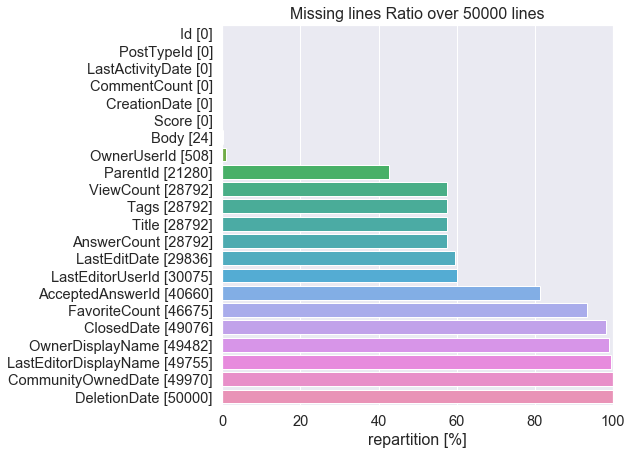

In [602]:
display_missing(df_quest)

### Filter questions

Only Questions don't have ParentId.

We filter questions with no ParentId and with non-Nan Body

In [603]:
df_quest_cleaned = df_quest[df_quest["ParentId"].isna()]
df_quest_cleaned = df_quest_cleaned[df_quest_cleaned["Body"].notna()]

,nb_missing,ratio
Id,0,0.000000
LastActivityDate,0,0.000000
Score,0,0.000000
CommentCount,0,0.000000
Body,0,0.000000
PostTypeId,0,0.000000
CreationDate,0,0.000000
ViewCount,48,0.225819
Title,48,0.225819
AnswerCount,48,0.225819


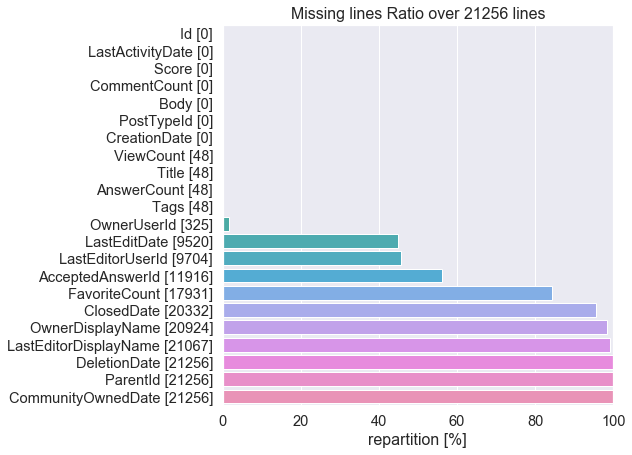

In [604]:
display_missing(df_quest_cleaned)

In [605]:
df_quest_cleaned[df_quest_cleaned.Title.isna()]

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate
655,50000860,4,NaN,NaN,2018-04-24 11:44:34,NaN,0,NaN,osgEarth is a geospatial SDK and terrain engin...,1332041.0,NaN,1332041.0,NaN,2018-04-25 07:25:46,2018-04-25 07:25:46,NaN,NaN,NaN,0,NaN,NaN,NaN
2576,50003399,5,NaN,NaN,2018-04-24 13:49:51,NaN,0,NaN,<p>This is an ambiguous tag that should not be...,1356107.0,NaN,1356107.0,NaN,2018-04-26 12:02:53,2018-04-26 12:02:53,NaN,NaN,NaN,0,NaN,NaN,NaN
2577,50003400,4,NaN,NaN,2018-04-24 13:49:51,NaN,0,NaN,DO NOT USE THIS TAG! Please find a more releva...,1481116.0,NaN,1356107.0,NaN,2018-04-26 12:06:27,2018-04-26 12:06:27,NaN,NaN,NaN,0,NaN,NaN,NaN
8467,50011191,4,NaN,NaN,2018-04-24 21:49:32,NaN,0,NaN,Use this tag for questions specific to Lightwe...,5862071.0,NaN,5862071.0,NaN,2018-04-24 21:49:32,2018-04-24 21:49:32,NaN,NaN,NaN,0,NaN,NaN,NaN
9636,50012751,5,NaN,NaN,2018-04-25 01:22:51,NaN,0,NaN,"<p><a href=""https://cloud.google.com/profiler/...",848626.0,NaN,848626.0,NaN,2018-04-25 10:21:23,2018-04-25 10:21:23,NaN,NaN,NaN,0,NaN,NaN,NaN
9637,50012752,4,NaN,NaN,2018-04-25 01:22:51,NaN,0,NaN,Google Cloud Profiler (aka Stackdriver Profile...,848626.0,NaN,848626.0,NaN,2018-04-26 04:06:31,2018-04-26 04:06:31,NaN,NaN,NaN,0,NaN,NaN,NaN
12039,50015982,5,NaN,NaN,2018-04-25 07:02:19,NaN,0,NaN,<p>Full details on downloading and using F#-Ch...,4288666.0,NaN,4288666.0,NaN,2018-04-25 12:16:54,2018-04-25 12:16:54,NaN,NaN,NaN,0,NaN,NaN,NaN
12040,50015983,4,NaN,NaN,2018-04-25 07:02:19,NaN,0,NaN,The F# Charting library implements charting su...,4288666.0,NaN,4288666.0,NaN,2018-04-25 22:24:30,2018-04-25 22:24:30,NaN,NaN,NaN,0,NaN,NaN,NaN
17297,50022969,5,NaN,NaN,2018-04-25 12:55:35,NaN,0,NaN,<p>Amazon Transcribe is an automatic speech re...,123378.0,NaN,123378.0,NaN,2018-04-25 18:45:32,2018-04-25 18:45:32,NaN,NaN,NaN,0,NaN,NaN,NaN
17298,50022970,4,NaN,NaN,2018-04-25 12:55:35,NaN,0,NaN,Amazon Transcribe is a speech recognition serv...,123378.0,NaN,123378.0,NaN,2018-04-26 05:32:48,2018-04-26 05:32:48,NaN,NaN,NaN,0,NaN,NaN,NaN


In [606]:
df_quest_cleaned[df_quest_cleaned.Id == 50060292].Body.tolist()

['<p>This library is deprecated and is no longer being used. Use <a href="/questions/tagged/boost-log" class="post-tag" title="show questions tagged &#39;boost-log&#39;" rel="tag">boost-log</a> instead. </p>\n\n<p><a href="https://meta.stackoverflow.com/questions/298315/burninate-boost-logging">Burninate boost-logging</a> </p>\n']

In [607]:
df_quest_cleaned = df_quest_cleaned[df_quest_cleaned.Title.notna()]

,nb_missing,ratio
Id,0,0.000000
LastActivityDate,0,0.000000
AnswerCount,0,0.000000
Title,0,0.000000
ViewCount,0,0.000000
Score,0,0.000000
Body,0,0.000000
CreationDate,0,0.000000
PostTypeId,0,0.000000
CommentCount,0,0.000000


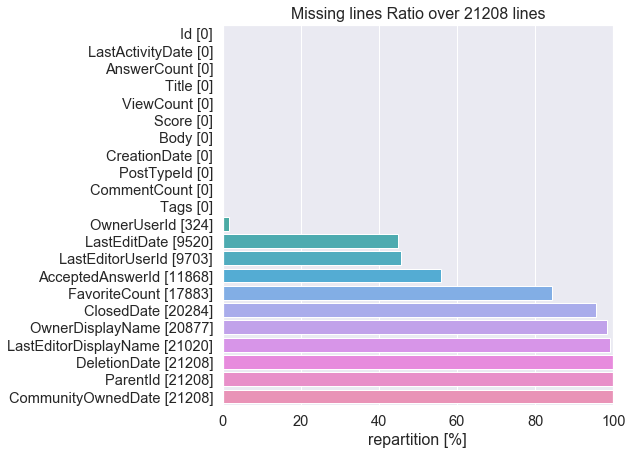

In [608]:
display_missing(df_quest_cleaned)

In [609]:
df_quest_cleaned[df_quest_cleaned["OwnerUserId"].isna()].head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate
117,50000152,1,50000270.0,NaN,2018-04-24 11:07:30,NaN,1,33.0,<p>I'm working on a blog. On its first page I ...,NaN,user9690627,3848833.0,NaN,2018-04-24 12:19:36,2018-04-24 12:19:36,Django - Combining Multiple Variables,<python><django>,1.0,0,NaN,NaN,NaN
140,50000185,1,50000460.0,NaN,2018-04-24 11:09:32,NaN,1,95.0,<p>I'm trying to write a PHP code that's a bit...,NaN,user9474945,4248328.0,NaN,2018-04-24 11:10:22,2018-04-24 15:47:15,Php date move to next month,<php>,4.0,2,NaN,NaN,NaN
179,50000239,1,50003124.0,NaN,2018-04-24 11:12:02,NaN,0,42.0,<p>I'm trying to append into the html code a j...,NaN,user9557101,NaN,user9557101,2018-04-24 11:29:35,2018-04-24 13:37:33,how to append a javascript function with 2 var...,<javascript><laravel>,1.0,3,NaN,NaN,NaN
711,50000932,1,NaN,NaN,2018-04-24 11:48:21,NaN,0,882.0,<p>I have some problems with 'entityManagerFac...,NaN,user7866438,3535298.0,NaN,2018-04-24 12:49:52,2018-04-24 12:49:52,Parameter 0 of constructor in com.springboot.D...,<java><hibernate><spring-boot><spring-data-jpa...,0.0,5,NaN,NaN,NaN
1291,50001710,1,NaN,NaN,2018-04-24 12:28:33,NaN,0,340.0,<p>i have a bottom navigation in main activity...,NaN,user9585742,7666442.0,NaN,2018-04-24 12:36:36,2018-04-24 12:36:36,putting recycler view above bottom navigation,<java><android><android-layout>,2.0,4,NaN,NaN,NaN


## Preparation data

### Tags

#### Nb Tags per Question

In [663]:
def apply_nb_tags(str_tags):
    return len(re.findall(r'(?<=\<)[^\<\>]+(?=\>)', str_tags))

df_quest_cleaned["nb_Tags"] = df_quest_cleaned["Tags"].apply(apply_nb_tags)


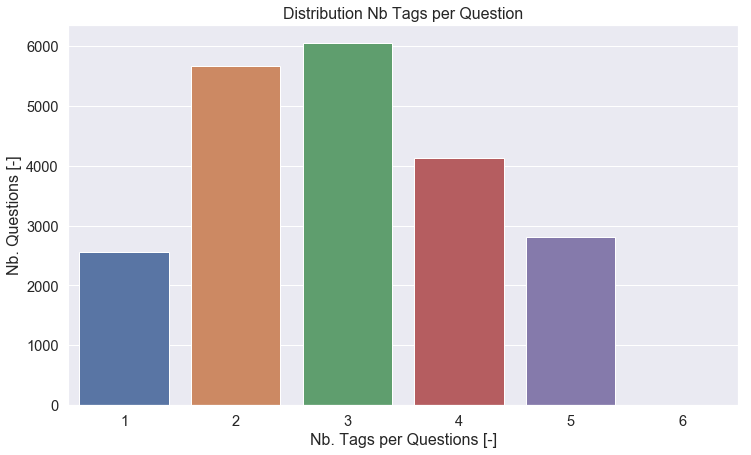

In [669]:
fig = plt.figure(figsize=(12, 7))
plt.title("Distribution Nb Tags per Question")
#ax = sns.distplot(df_quest_cleaned["nb_Tags"], kde=False, bins=6);
ax = sns.countplot(data=df_quest_cleaned, x="nb_Tags");
#ax = sns.distplot(df_Tags);
ax.set_xlabel("Nb. Tags per Questions [-]")
ax.set_ylabel("Nb. Questions [-]");
#ax.set_xlim([0,25])

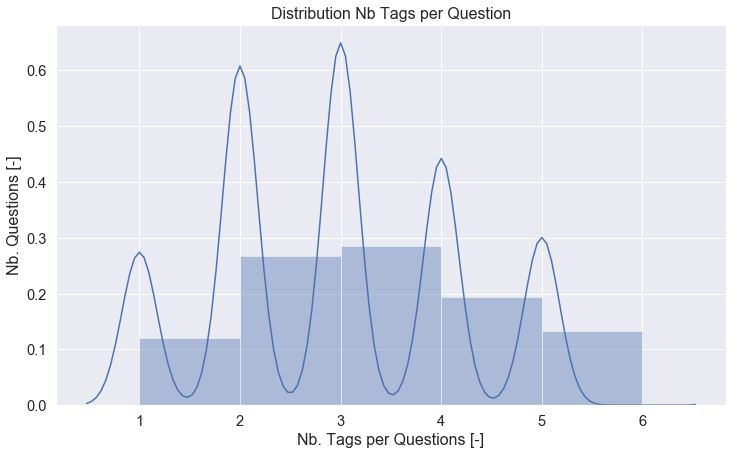

In [674]:
fig = plt.figure(figsize=(12, 7))
plt.title("Distribution Nb Tags per Question")
ax = sns.distplot(df_quest_cleaned["nb_Tags"], bins=5);
#ax = sns.countplot(data=df_quest_cleaned, x="nb_Tags");
#ax = sns.distplot(df_Tags);
ax.set_xlabel("Nb. Tags per Questions [-]")
ax.set_ylabel("Nb. Questions [-]");
#ax.set_xlim([0,25])

Only 1 Question with 6 Tags : 

In [682]:
df_quest_cleaned[df_quest_cleaned["nb_Tags"] == 6].shape[0]

1

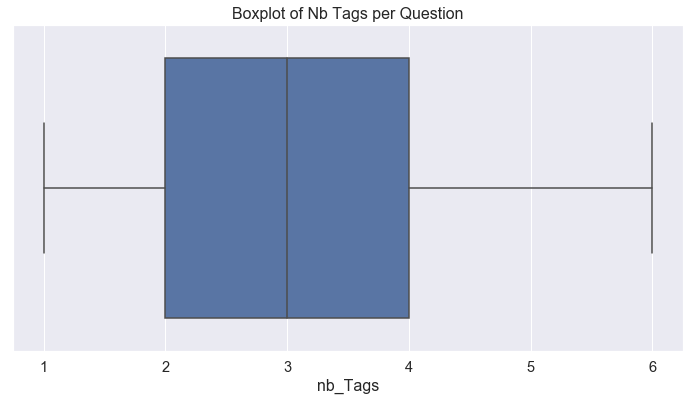

In [666]:
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplot of Nb Tags per Question")
ax = sns.boxplot(df_quest_cleaned["nb_Tags"]);
#ax.set_xlim([0,20])
#ax.set_xlabel("nb. Occurences")

#### Unique Tags

In [611]:
# extract all tags
list_tags_raw=[]
for idx in range(0, df_quest_cleaned.shape[0]):
    #print("start...",idx)
    list_tags_raw = list_tags_raw+(re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                           df_quest_cleaned.iloc[idx].Tags))
# list of unique tags over all questions (no limitation at most frequent tags)
list_unique_tags = list(np.unique(list_tags_raw)) 
print('Total Number of Tags:', len(list_tags_raw))
print("Number of Unique Tags:",len(list_unique_tags))
list_unique_tags[:10]

Total Number of Tags: 62572
Number of Unique Tags: 8765


['.app',
 '.htaccess',
 '.lib',
 '.net',
 '.net-1.1',
 '.net-4.0',
 '.net-4.5',
 '.net-4.6',
 '.net-4.6.1',
 '.net-4.6.2']

In [621]:
df_Tags = pd.DataFrame(list_tags_raw, columns=["Tag"])
df_Tags = pd.DataFrame(df_Tags.Tag.value_counts())
df_Tags.head(10)

,Tag
javascript,2229
python,2180
java,1688
c#,1183
android,1137
php,1092
html,955
css,665
r,660
jquery,639


Text(0, 0.5, 'Normalized distribution [-]')

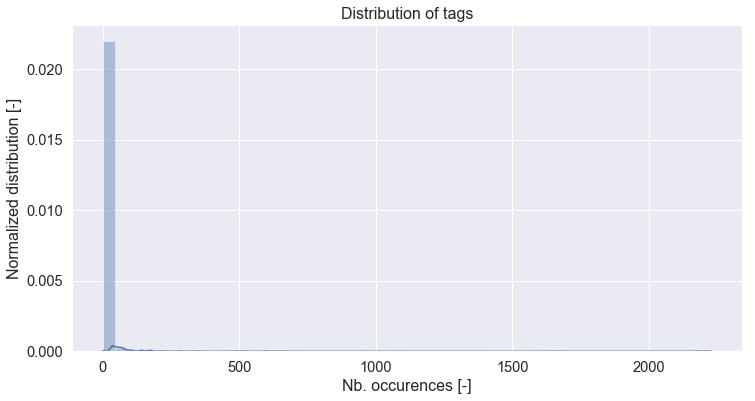

In [640]:
fig = plt.figure(figsize=(12, 6))
plt.title("Distribution of tags")
#ax = sns.distplot(df_Tags[df_Tags["Tag"] <= 100], kde=False);
ax = sns.distplot(df_Tags);
ax.set_xlabel("Nb. occurences [-]")
ax.set_ylabel("Normalized distribution [-]")

(0, 25)

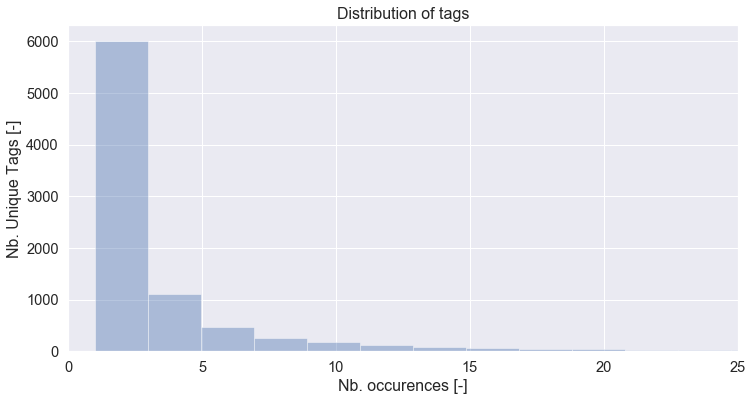

In [643]:
fig = plt.figure(figsize=(12, 6))
plt.title("Distribution of tags")
ax = sns.distplot(df_Tags[df_Tags["Tag"] <= 100], kde=False);
#ax = sns.distplot(df_Tags);
ax.set_xlabel("Nb. occurences [-]")
ax.set_ylabel("Nb. Unique Tags [-]")
ax.set_xlim([0,25])

(0.9, 1)

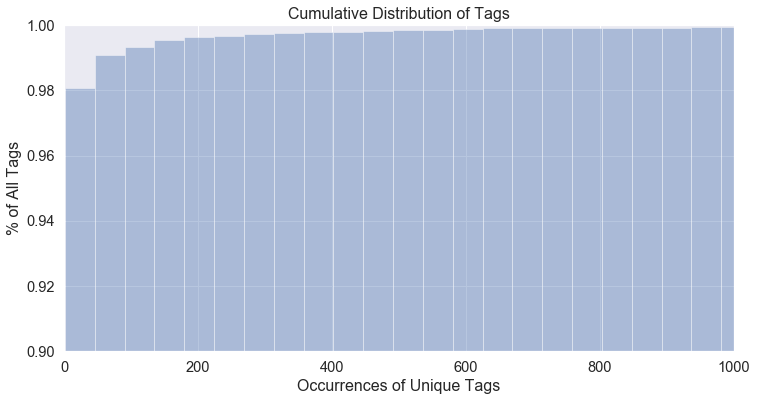

In [656]:
fig = plt.figure(figsize=(12, 6))
plt.title("Cumulative Distribution of Tags")
ax = sns.distplot(df_Tags["Tag"], kde=True,
                 hist_kws={'cumulative': True});
ax.set_xlabel("Occurrences of Unique Tags")
ax.set_ylabel("% of All Tags");
ax.set_xlim([0, 1000])
ax.set_ylim([0.9, 1])

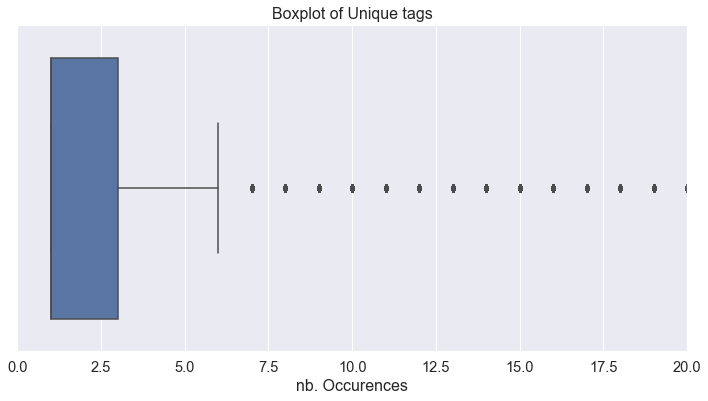

In [683]:
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplot of Unique tags")
ax = sns.boxplot(df_Tags["Tag"]);
ax.set_xlim([0,20])
ax.set_xlabel("nb. Occurences");

#### Extract Tags

In [684]:
df_quest_cleaned["Tag_0"] = df_quest_cleaned.Tags.apply(apply_extract_tag)
df_quest_cleaned["Tag_1"] = df_quest_cleaned.Tags.apply(apply_extract_tag, 
                                                        args=(1,))
df_quest_cleaned["Tag_2"] = df_quest_cleaned.Tags.apply(apply_extract_tag, 
                                                        args=(2,))
df_quest_cleaned["Tag_3"] = df_quest_cleaned.Tags.apply(apply_extract_tag, 
                                                        args=(3,))
df_quest_cleaned["Tag_4"] = df_quest_cleaned.Tags.apply(apply_extract_tag, 
                                                        args=(4,))
df_quest_cleaned.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,Tag_0,Tag_1,Tag_2,Tag_3,Tag_4,nb_Tags
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,<c#><sql><sql-server>,3.0,0,NaN,NaN,NaN,c#,sql,sql-server,NaN,NaN,3
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,<sql-server><sql-server-data-tools>,1.0,2,NaN,NaN,NaN,sql-server,sql-server-data-tools,NaN,NaN,NaN,2
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,<javascript><php><ajax>,1.0,4,NaN,NaN,NaN,javascript,php,ajax,NaN,NaN,3
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,<android><amazon-s3><file-upload><multipart>,1.0,0,NaN,NaN,NaN,android,amazon-s3,file-upload,multipart,NaN,4
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,<sql><db2><crosstab>,1.0,0,NaN,NaN,NaN,sql,db2,crosstab,NaN,NaN,3


#### Most used Tags

To have a balance between number of Tags to predict and their utilization 

In [748]:
list_nb_tags_used_min = [160, 100, 76, 40]

list_list_most_used =[]
list_nb_tags_unique_most_used = []
list_pc_tags =[]
for nb_tags_used_min in list_nb_tags_used_min:
    
    list_list_most_used.append(list(df_Tags[df_Tags["Tag"] >= \
                                            nb_tags_used_min].index))
    list_nb_tags_unique_most_used.append(
        df_Tags[df_Tags["Tag"]>=nb_tags_used_min].shape[0])
    
    list_pc_tags.append(100*df_Tags[df_Tags["Tag"]>=nb_tags_used_min].\
                 shape[0]/df_Tags.shape[0])
    
    print('Nb Tags used < {} times : {} over {} Tags [{:.2f}%]'.\
          format(nb_tags_used_min,
                 df_Tags[df_Tags["Tag"]<nb_tags_used_min].shape[0], 
                 df_Tags.shape[0],
                 100*df_Tags[df_Tags["Tag"]<nb_tags_used_min].\
                 shape[0]/df_Tags.shape[0]))

    print('Nb Tags used >= {} times : {} over {} Tags [{:.2f}%]'.\
          format(nb_tags_used_min,
                 df_Tags[df_Tags["Tag"]>=nb_tags_used_min].shape[0], 
                 df_Tags.shape[0],
                 100*df_Tags[df_Tags["Tag"]>=nb_tags_used_min].\
                 shape[0]/df_Tags.shape[0]))

df_most = pd.DataFrame(data=list_nb_tags_used_min, columns=["nb_min_used"])
df_most["nb_most_used_tags"] = list_nb_tags_unique_most_used
df_most["pc_of_unique_tags"] = list_pc_tags
df_most

Nb Tags used < 160 times : 8714 over 8765 Tags [99.42%]
Nb Tags used >= 160 times : 51 over 8765 Tags [0.58%]
Nb Tags used < 100 times : 8692 over 8765 Tags [99.17%]
Nb Tags used >= 100 times : 73 over 8765 Tags [0.83%]
Nb Tags used < 76 times : 8665 over 8765 Tags [98.86%]
Nb Tags used >= 76 times : 100 over 8765 Tags [1.14%]
Nb Tags used < 40 times : 8564 over 8765 Tags [97.71%]
Nb Tags used >= 40 times : 201 over 8765 Tags [2.29%]


,nb_min_used,nb_most_used_tags,pc_of_unique_tags
0,160,51,0.581860
1,100,73,0.832858
2,76,100,1.140901
3,40,201,2.293212


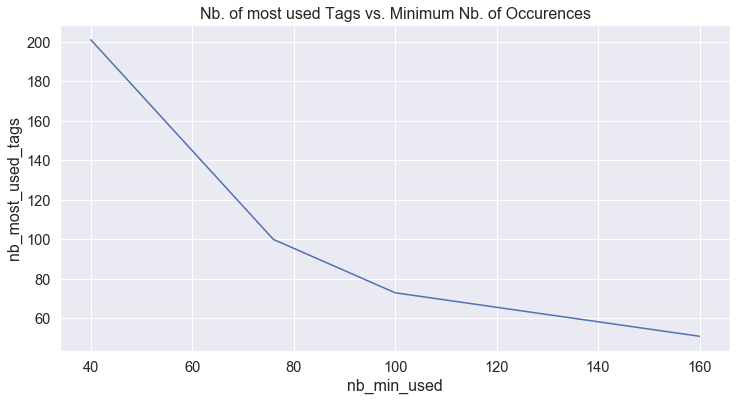

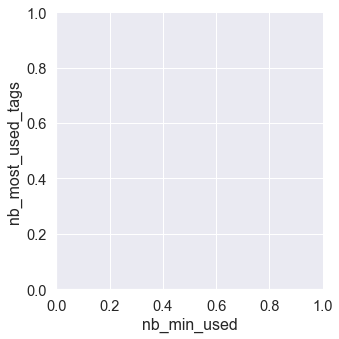

In [749]:
fig = plt.figure(figsize=(12, 6))
plt.title("Nb. of most used Tags vs. Minimum Nb. of Occurences")
ax = fig.gca()
sns.relplot(ax=ax, x="nb_min_used", y="nb_most_used_tags", data=df_most, 
            kind='line', markers=True)


#ax.set_xlim([0,20])
#ax.set_xlabel("nb. Occurences");

In [751]:
#list_tags_most_used = list(df_Tags[df_Tags["Tag"]>=nb_tags_used_min].index)
print("10 most used Tags:")
list_list_most_used[0][:10]

10 most used Tags:


['javascript',
 'python',
 'java',
 'c#',
 'android',
 'php',
 'html',
 'css',
 'r',
 'jquery']

In [738]:
len(list_list_most_used)

3

In [752]:
def check_Tags_most_used(text, list_most_used):
    '''
    Check if Tag string "text" is a most used Tag
    '''
    if text in list_most_used:
        return True
    return False


list_pc_quest=[]
for idx, list_most_used_curr in enumerate(list_list_most_used):
    df_quest_cleaned["flag_Tag_0"] = df_quest_cleaned["Tag_0"].\
        apply(check_Tags_most_used, args=(list_most_used_curr,))
    df_quest_cleaned["flag_Tag_1"] = df_quest_cleaned["Tag_1"].\
        apply(check_Tags_most_used, args=(list_most_used_curr,))
    df_quest_cleaned["flag_Tag_2"] = df_quest_cleaned["Tag_2"].\
        apply(check_Tags_most_used, args=(list_most_used_curr,))
    df_quest_cleaned["flag_Tag_3"] = df_quest_cleaned["Tag_3"].\
        apply(check_Tags_most_used, args=(list_most_used_curr,))
    df_quest_cleaned["flag_Tag_4"] = df_quest_cleaned["Tag_4"].\
        apply(check_Tags_most_used, args=(list_most_used_curr,))
    df_quest_cleaned["flag_most_Tagged_{}"\
                     .format(list_nb_tags_used_min[idx])] = \
    df_quest_cleaned["flag_Tag_0"] | \
    df_quest_cleaned["flag_Tag_1"] | df_quest_cleaned["flag_Tag_2"] | \
    df_quest_cleaned["flag_Tag_3"] | df_quest_cleaned["flag_Tag_4"]
    
    list_pc_quest.append(100*df_quest_cleaned[\
        df_quest_cleaned["flag_most_Tagged_{}".\
        format(list_nb_tags_used_min[idx])] == True].shape[0] / \
        df_quest_cleaned.shape[0])
    

In [753]:
df_most["pc_of_quest"] = list_pc_quest
df_most

,nb_min_used,nb_most_used_tags,pc_of_unique_tags,pc_of_quest
0,160,51,0.581860,76.914372
1,100,73,0.832858,80.879857
2,76,100,1.140901,83.666541
3,40,201,2.293212,88.494908


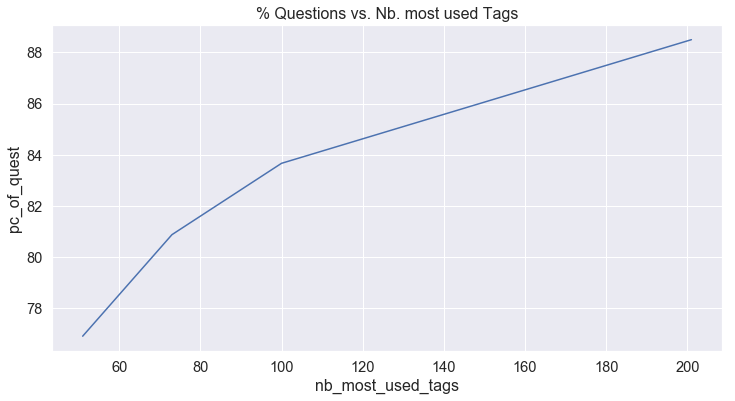

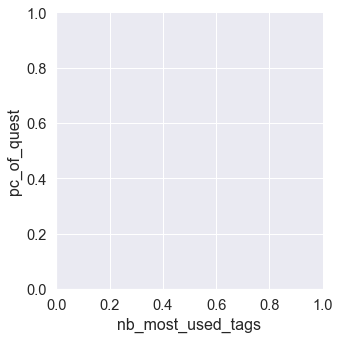

In [755]:
fig = plt.figure(figsize=(12, 6))
plt.title("% Questions vs. Nb. most used Tags")
ax = fig.gca()
sns.relplot(ax=ax, x="nb_most_used_tags", y="pc_of_quest", data=df_most, 
            kind='line', markers=True)

In [754]:
df_quest_cleaned.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Tag_3,Tag_4,nb_Tags,flag_Tag_0,flag_Tag_1,flag_Tag_2,flag_Tag_3,flag_Tag_4,flag_most_Tagged_76,flag_most_Tagged_160,flag_most_Tagged_40,flag_most_Tagged_100
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,NaN,NaN,3,True,True,True,False,False,True,True,True,True
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,NaN,NaN,2,True,False,False,False,False,True,True,True,True
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,NaN,NaN,3,True,True,True,False,False,True,True,True,True
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,multipart,NaN,4,True,True,False,False,False,True,True,True,True
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,NaN,NaN,3,True,False,False,False,False,True,True,True,True


In [742]:
df_quest_cleaned["flag_most_Tagged_40"].value_counts(dropna=False)

True     18768
False     2440
Name: flag_most_Tagged_40, dtype: int64

In [743]:
df_quest_cleaned["flag_most_Tagged_76"].value_counts(dropna=False)

True     17744
False     3464
Name: flag_most_Tagged_76, dtype: int64

In [741]:
df_quest_cleaned["flag_most_Tagged_160"].value_counts(dropna=False)

True     16312
False     4896
Name: flag_most_Tagged_160, dtype: int64

In [165]:
#df_quest_cleaned = df_quest_cleaned[df_quest_cleaned["flag_most_Tagged"] == 
#                                    True]

### Title & Body concatenation

In [169]:
df_quest_cleaned["Text"] = df_quest_cleaned["Title"] + " " + df_quest_cleaned["Body"]
df_quest_cleaned.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Tag_0,Tag_1,Tag_2,Tag_3,Tag_4,flag_Tag_0,flag_Tag_1,flag_Tag_2,flag_Tag_3,flag_Tag_4,flag_most_Tagged,Text
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,c#,sql,sql-server,NaN,NaN,True,True,True,False,False,True,How to insert an entry to a table only if it d...
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,sql-server,sql-server-data-tools,NaN,NaN,NaN,True,False,False,False,False,True,System DMV's missing from SQL Server 2017 mast...
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,javascript,php,ajax,NaN,NaN,True,True,True,False,False,True,how to insert data in databse without page rel...
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,android,amazon-s3,file-upload,multipart,NaN,True,False,False,False,False,True,How to upload image using multipart in Amazon ...
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,sql,db2,crosstab,NaN,NaN,True,False,False,False,False,True,DB2 SQL CROSSTAB <p>I would like to output a t...


In [170]:
df_quest_cleaned.head(1)

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Tag_0,Tag_1,Tag_2,Tag_3,Tag_4,flag_Tag_0,flag_Tag_1,flag_Tag_2,flag_Tag_3,flag_Tag_4,flag_most_Tagged,Text
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,c#,sql,sql-server,NaN,NaN,True,True,True,False,False,True,How to insert an entry to a table only if it d...


In [171]:
df_quest_cleaned.head(1).Title.tolist()

['How to insert an entry to a table only if it does not exist']

In [172]:
df_quest_cleaned.head(1).Body.tolist()

["<p>My table looks like this  on sql server</p>\n\n<pre><code>wordId     word      \n----------------\n1214       pen           \n1215       men    \n1216       cat  \n</code></pre>\n\n<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>\n"]

In [173]:
df_quest_cleaned.head(1).Text.tolist()

["How to insert an entry to a table only if it does not exist <p>My table looks like this  on sql server</p>\n\n<pre><code>wordId     word      \n----------------\n1214       pen           \n1215       men    \n1216       cat  \n</code></pre>\n\n<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>\n"]

##### Create questions dictionnary

In [174]:
questions = df_quest_cleaned.filter(items=["Text"]).to_dict()
questions = questions["Text"]
print('{} questions'.format(len(questions)))

17744 questions


In [175]:
questions[4]

'System DMV\'s missing from SQL Server 2017 master.dacpac in SSDT 2015 <p>I have Ola Hallengren\'s excellent Maintenance Solution scripts incorporated in to a DBA tools database project.  This is maintained using SSDT 2015 with a target platform of SQL Server 2012.  The project includes references to the built-in system databases master &amp; msdb.  The project builds successfully.</p>\n\n<p>Ola has recently <a href="https://ola.hallengren.com/versions.html" rel="nofollow noreferrer">updated</a> his scripts and they now include references to new SQL Server 2017 DMV\'s, so incorporating the updated scripts into my database project generated unresolved reference errors for the new DMV\'s.  </p>\n\n<pre><code>SQL71502: Procedure: [dbo].[DatabaseBackup] has an unresolved reference to object [sys].[dm_os_host_info]\nSQL71502: Procedure: [dbo].[DatabaseBackup] has an unresolved reference to object [sys].[dm_db_log_stats]\n</code></pre>\n\n<p>Although I don\'t have SQL Server 2017 installed a

### Words in questions

In [176]:
tokenizer = nltk.RegexpTokenizer(r'\w+')

def freq_stats_corpora():
    '''
    Statistics about words in questions
    '''
    corpora = defaultdict(list)

    # Création d'un corpus de tokens par question
    for id_curr,questions_curr in questions.items():        
        try:
            corpora[id_curr] += tokenizer.tokenize(questions_curr.lower())
        except:
            print('Question {} : Error body empty'.format(id_curr))
            
    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}
        
    return (freq, stats, corpora)

# Récupération des comptages
freq, stats, corpora = freq_stats_corpora()
df_stats = pd.DataFrame.from_dict(stats, orient='index')

# Affichage des fréquences
#df.sort(columns='total', ascending=False)
#df = df.sort_values(by=['total'], ascending=False)
#df.head(50).plot(kind='bar', color="#f56900", title='Top 50 Rappeurs par nombre de mots')

In [177]:
df_stats.head()

,total,unique
3,82,49
4,424,192
9,355,89
10,31,24
12,70,39


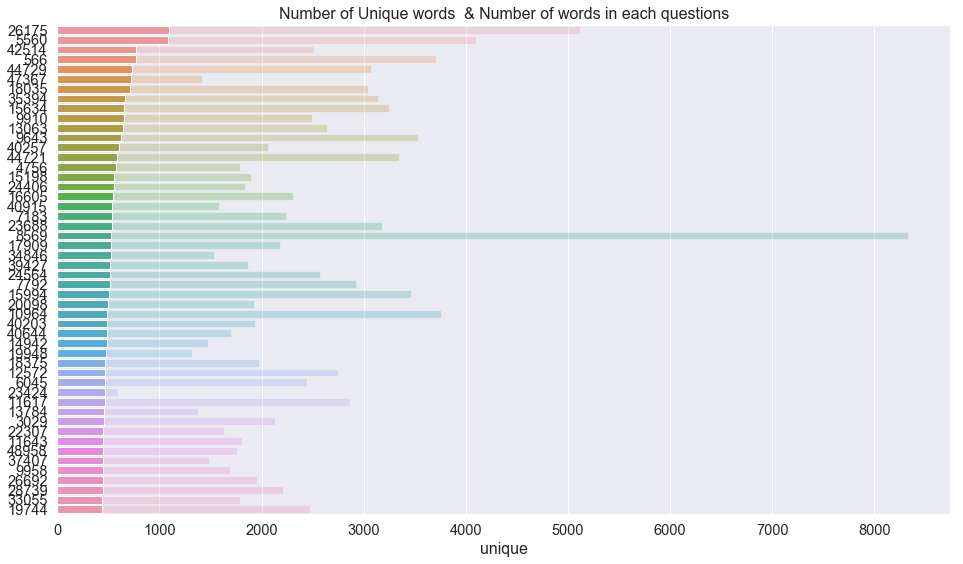

In [178]:
fig = plt.figure(figsize=(16, 9))
plt.title("Number of Unique words  & Number of words in each questions")
df_plot = df_stats.sort_values(by=['unique'], ascending=False).head(50)
ax = sns.barplot(y=df_plot.index, order= df_plot.index,
            x="total",orient="h",
            data=df_plot, alpha=0.3)
sns.barplot(y=df_plot.index, order= df_plot.index,
            x="unique",orient="h",
            data=df_plot, ax=ax)

In [179]:
df_plot.T

,26175,5560,42514,566,44729,47367,18035,35394,15634,9910,13063,9643,...,11617,13784,3029,22307,11643,48958,37407,9958,26692,28739,33055,19744
total,5119,4100,2515,3708,3076,1420,3042,3139,3243,2492,2643,3534,...,2869,1381,2130,1633,1809,1757,1489,1692,1959,2210,1784,2479
unique,1096,1087,770,767,733,719,712,667,649,648,646,622,...,465,455,453,451,449,446,446,445,445,445,442,440


In [180]:
len(df_quest_cleaned.loc[14942].Body)

9799

In [181]:
df_quest_cleaned.loc[14942].Body

"<p>My outer <code>RecyclerView</code> crashes either with</p>\n\n<pre><code>IllegalArgumentException: Scrapped or attached views may not be recycled. isScrap:false isAttached:true...\n</code></pre>\n\n<p>or</p>\n\n<pre><code>IllegalStateException: The specified child already has a parent. You must call removeView() on the child's parent first.\n</code></pre>\n\n<p>Like the title suggests I have an <code>RecyclerView</code> in the list item layout of the first <code>RecyclerView</code>. This layout is used to display messages and the \ninner <code>RecyclerView</code> to display attachments that come with the message. The inner <code>RecyclerViews</code> visibility is set to either <code>GONE</code> or <code>VISIBLE</code> depending whether the message has any attachments or not. The simplified outer list item layout looks like this</p>\n\n<pre><code>ConstraintLayout\n    TextView\n    TextView\n    TextView\n    RecyclerView\n</code></pre>\n\n<p>And the part of the adapter that handles

In [182]:
tokenizer.tokenize(df_quest_cleaned.loc[14942].Body)

['p',
 'My',
 'outer',
 'code',
 'RecyclerView',
 'code',
 'crashes',
 'either',
 'with',
 'p',
 'pre',
 'code',
 'IllegalArgumentException',
 'Scrapped',
 'or',
 'attached',
 'views',
 'may',
 'not',
 'be',
 'recycled',
 'isScrap',
 'false',
 'isAttached',
 'true',
 'code',
 'pre',
 'p',
 'or',
 'p',
 'pre',
 'code',
 'IllegalStateException',
 'The',
 'specified',
 'child',
 'already',
 'has',
 'a',
 'parent',
 'You',
 'must',
 'call',
 'removeView',
 'on',
 'the',
 'child',
 's',
 'parent',
 'first',
 'code',
 'pre',
 'p',
 'Like',
 'the',
 'title',
 'suggests',
 'I',
 'have',
 'an',
 'code',
 'RecyclerView',
 'code',
 'in',
 'the',
 'list',
 'item',
 'layout',
 'of',
 'the',
 'first',
 'code',
 'RecyclerView',
 'code',
 'This',
 'layout',
 'is',
 'used',
 'to',
 'display',
 'messages',
 'and',
 'the',
 'inner',
 'code',
 'RecyclerView',
 'code',
 'to',
 'display',
 'attachments',
 'that',
 'come',
 'with',
 'the',
 'message',
 'The',
 'inner',
 'code',
 'RecyclerViews',
 'code',
 'v

### Stops words

In [184]:
# Premièrement, on récupère la fréquence totale de chaque mot sur tout le corpus
# de questions
freq_totale = nltk.Counter()
for k, v in questions.items():
    freq_totale += freq[k]



In [185]:
freq_totale.most_common(50)

[('p', 171313),
 ('code', 115490),
 ('gt', 107593),
 ('the', 102773),
 ('i', 98692),
 ('lt', 97069),
 ('to', 72765),
 ('a', 69999),
 ('pre', 59699),
 ('in', 42991),
 ('is', 41006),
 ('0', 39568),
 ('and', 37164),
 ('this', 34708),
 ('1', 34250),
 ('of', 28099),
 ('it', 24721),
 ('for', 23610),
 ('class', 21931),
 ('if', 20813),
 ('2', 18924),
 ('with', 18399),
 ('that', 18382),
 ('data', 17960),
 ('my', 17699),
 ('from', 16879),
 ('have', 16646),
 ('com', 16203),
 ('on', 15769),
 ('div', 15757),
 ('but', 15564),
 ('not', 15471),
 ('as', 14614),
 ('id', 14349),
 ('strong', 13892),
 ('at', 13880),
 ('new', 13508),
 ('name', 13173),
 ('string', 12893),
 ('3', 12519),
 ('https', 12183),
 ('t', 12082),
 ('java', 12054),
 ('how', 11907),
 ('can', 11874),
 ('get', 11554),
 ('error', 11089),
 ('value', 11028),
 ('function', 10892),
 ('return', 10874)]

In [186]:
# Deuxièmement on décide manière un peu arbitraire du nombre de mots les plus 
# fréquents à supprimer. On pourrait afficher un graphe d'évolution du nombre 
# de mots pour se rendre compte et avoir une meilleure heuristique. 
# On créé notre set de stopwords final qui cumule ainsi les 100 mots les plus 
# fréquents du corpus ainsi que l'ensemble de stopwords par défaut présent 
# dans la librairie NLTK
most_freq = freq_totale.most_common(100)
sw = set()
for tuple_freq in most_freq:
    sw.add(tuple_freq[0])
    
sw.update(tuple(nltk.corpus.stopwords.words('english')))
sw

{'0',
 '1',
 '2',
 '3',
 '4',
 '5',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'amp',
 'an',
 'and',
 'android',
 'any',
 'app',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'c',
 'can',
 'class',
 'code',
 'com',
 'couldn',
 "couldn't",
 'd',
 'data',
 'did',
 'didn',
 "didn't",
 'div',
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'error',
 'false',
 'few',
 'file',
 'for',
 'from',
 'function',
 'further',
 'get',
 'gt',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'href',
 'html',
 'https',
 'i',
 'id',
 'if',
 'image',
 'import',
 'in',
 'int',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'java',
 'js',
 'just',
 'li',
 'like',
 'list',
 'll',
 

In [187]:
nltk.corpus.stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [188]:
def freq_stats_corpora2():
    '''
    Statistics about significant words in questions
    '''
    corpora = defaultdict(list)

    # Création d'un corpus de tokens par artiste
    for id_curr,questions_curr in questions.items():
        #print(id_curr)
        try:
            tokens = tokenizer.tokenize(questions_curr.lower())
            corpora[id_curr] += [w for w in tokens if not w in list(sw)]
        except:
            print('Question {} : Error body empty'.format(id_curr))
            

    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}
        
    return (freq, stats, corpora)

freq2, stats2, corpora2 = freq_stats_corpora2()

In [189]:
df_stats2 = pd.DataFrame.from_dict(stats2, orient='index')
df_stats2.head()

,total,unique
3,35,24
4,212,120
9,142,51
10,12,9
12,34,23


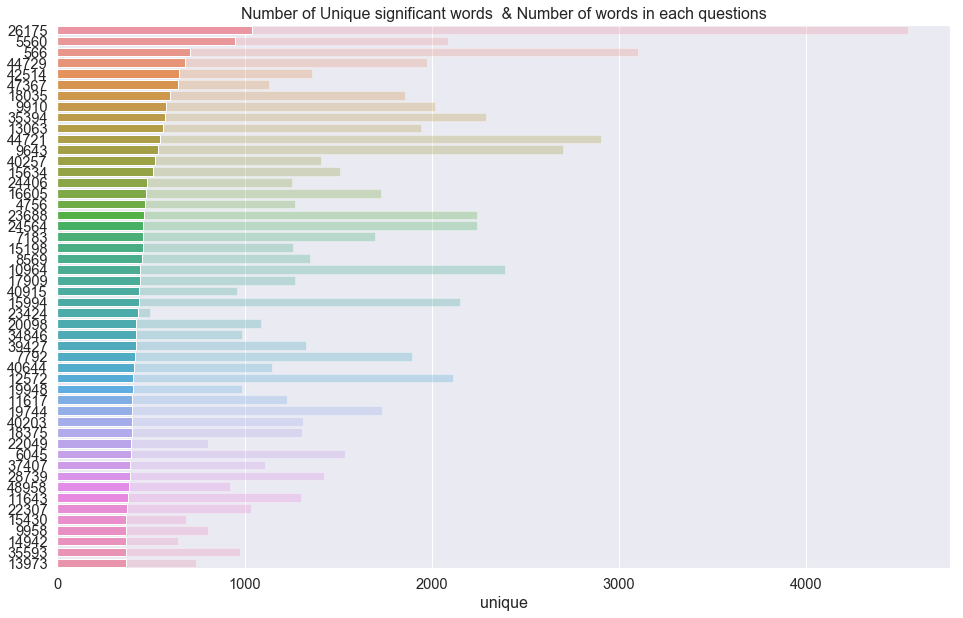

In [190]:
fig = plt.figure(figsize=(16, 10))
plt.title("Number of Unique significant words  & Number of words in each questions")
df_plot = df_stats2.sort_values(by=['unique'], ascending=False).head(50)
ax = sns.barplot(y=df_plot.index, order= df_plot.index,
            x="total",orient="h",
            data=df_plot, alpha=0.3)
sns.barplot(y=df_plot.index, order= df_plot.index,
            x="unique",orient="h",
            data=df_plot, ax=ax)

In [191]:
df_plot.head()

,total,unique
26175,4541,1038
5560,2088,950
566,3100,709
44729,1975,684
42514,1358,648


In [192]:
df_stats2.loc[26175]

total     4541
unique    1038
Name: 26175, dtype: int64

In [193]:
df_stats.loc[26175]

total     5119
unique    1096
Name: 26175, dtype: int64

### Stems of words in questions

In [194]:
def freq_stats_corpora3():
    '''
    Statistics about stems of words in questions
    '''
    corpora = defaultdict(list)
    stemmer = EnglishStemmer()
    # Création d'un corpus de tokens par artiste
    for id_curr,questions_curr in questions.items():
        try:
            tokens = tokenizer.tokenize(questions_curr.lower())
            corpora[id_curr] += \
                [stemmer.stem(w) for w in tokens if not w in list(sw)]
        except:
            print('Question {} : Error body empty'.format(id_curr))
            
    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}
        
    return (freq, stats, corpora)

freq3, stats3, corpora3 = freq_stats_corpora3()

df_stats3 = pd.DataFrame.from_dict(stats3, orient='index')
df_stats3.head()

,total,unique
3,35,23
4,212,109
9,142,51
10,12,9
12,34,23


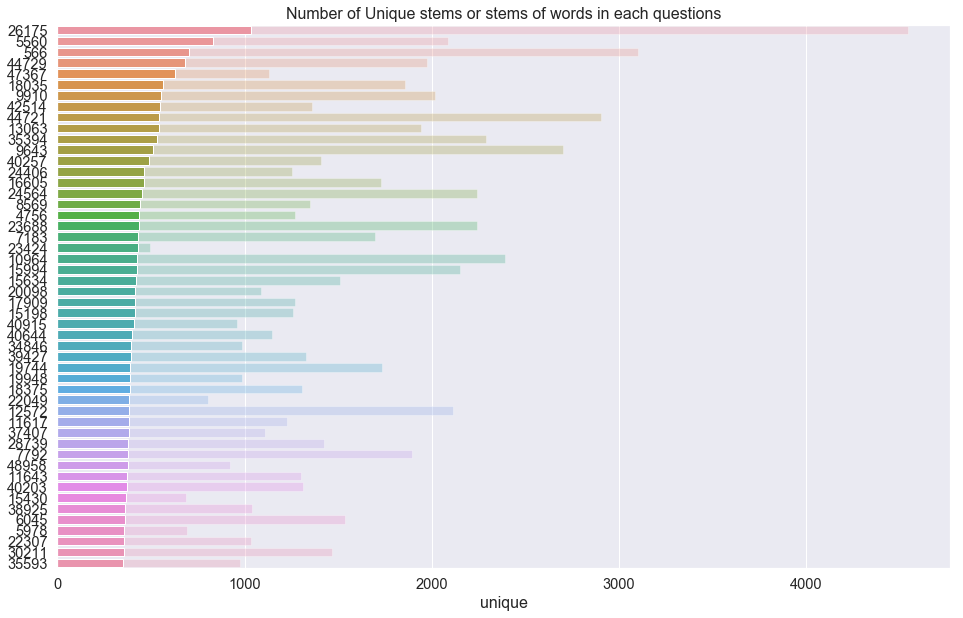

In [195]:
fig = plt.figure(figsize=(16, 10))
plt.title("Number of Unique stems or stems of words in each questions")
df_plot = df_stats3.sort_values(by=['unique'], ascending=False).head(50)
ax = sns.barplot(y=df_plot.index, order= df_plot.index,
            x="total",orient="h",
            data=df_plot, alpha=0.3)
sns.barplot(y=df_plot.index, order= df_plot.index,
            x="unique",orient="h",
            data=df_plot, ax=ax)

In [196]:
df_plot.head()

,total,unique
26175,4541,1032
5560,2088,830
566,3100,702
44729,1975,683
47367,1133,626


### Cleaning Text

In [197]:
token_dict = dict()
# for each questions, prepare token : lower, no ponctuation
for id_curr, questions_curr in questions.items():
    try:
        # save cleaned text into dict output
        token_dict[id_curr] = cleaning_text(questions_curr) 
    except:
        print('Question {} : Error body empty'.format(id_curr))

Cleaning Example : 

In [198]:
questions[3]

"How to insert an entry to a table only if it does not exist <p>My table looks like this  on sql server</p>\n\n<pre><code>wordId     word      \n----------------\n1214       pen           \n1215       men    \n1216       cat  \n</code></pre>\n\n<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>\n"

In [199]:
token_dict[3]

'insert entry table exist   table looks sql server       wordid word                          pen  men  cat       wordid word passed stored procedure   need check stored procedure wordid already exists table   wordid n t exists need execute insert statement    '

In [200]:
#df_token = pd.DataFrame(token_dict)
df_token = pd.DataFrame.from_dict(token_dict, orient='index', columns=["token_text"])
df_token.head()

,token_text
3,insert entry table exist table looks sql ser...
4,system dmv s missing sql server master dacpa...
9,insert databse without page reload insert ...
10,upload multipart amazon s3 upload amazon s3 ...
12,db2 sql crosstab would output table transf...


In [201]:
df_token.shape

(17744, 1)

In [202]:
df_quest_cleaned.shape

(17744, 34)

In [203]:
np.all(df_quest_cleaned.index == df_token.index)

True

In [204]:
df_quest_cleaned["token_text"] = df_token["token_text"]
df_quest_cleaned.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Tag_1,Tag_2,Tag_3,Tag_4,flag_Tag_0,flag_Tag_1,flag_Tag_2,flag_Tag_3,flag_Tag_4,flag_most_Tagged,Text,token_text
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,sql,sql-server,NaN,NaN,True,True,True,False,False,True,How to insert an entry to a table only if it d...,insert entry table exist table looks sql ser...
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,sql-server-data-tools,NaN,NaN,NaN,True,False,False,False,False,True,System DMV's missing from SQL Server 2017 mast...,system dmv s missing sql server master dacpa...
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,php,ajax,NaN,NaN,True,True,True,False,False,True,how to insert data in databse without page rel...,insert databse without page reload insert ...
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,amazon-s3,file-upload,multipart,NaN,True,False,False,False,False,True,How to upload image using multipart in Amazon ...,upload multipart amazon s3 upload amazon s3 ...
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,db2,crosstab,NaN,NaN,True,False,False,False,False,True,DB2 SQL CROSSTAB <p>I would like to output a t...,db2 sql crosstab would output table transf...


### TF-IDF

In [205]:
corpus = [
...     'This is the first document.',
...     'This document is the second document.',
...     'And this is the third one.',
...     'Is this the first document?',
... ]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
print(X.shape)
(4, 9)

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
(4, 9)


(4, 9)

In [206]:
X

<4x9 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in Compressed Sparse Row format>

In [207]:
print(X)

  (0, 8)	0.38408524091481483
  (0, 3)	0.38408524091481483
  (0, 6)	0.38408524091481483
  (0, 2)	0.5802858236844359
  (0, 1)	0.46979138557992045
  (1, 8)	0.281088674033753
  (1, 3)	0.281088674033753
  (1, 6)	0.281088674033753
  (1, 1)	0.6876235979836938
  (1, 5)	0.5386476208856763
  (2, 8)	0.267103787642168
  (2, 3)	0.267103787642168
  (2, 6)	0.267103787642168
  (2, 0)	0.511848512707169
  (2, 7)	0.511848512707169
  (2, 4)	0.511848512707169
  (3, 8)	0.38408524091481483
  (3, 3)	0.38408524091481483
  (3, 6)	0.38408524091481483
  (3, 2)	0.5802858236844359
  (3, 1)	0.46979138557992045


In [208]:
# prepare tf-idf calculation
tfidf = TfidfVectorizer(tokenizer=myTokenizer, analyzer='word')
# calculate tf-idf
values = tfidf.fit_transform(token_dict.values())

In [209]:
df_quest_cleaned.iloc[0].Body

"<p>My table looks like this  on sql server</p>\n\n<pre><code>wordId     word      \n----------------\n1214       pen           \n1215       men    \n1216       cat  \n</code></pre>\n\n<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>\n"

In [210]:
names = tfidf.get_feature_names()

In [211]:
names[40401:40421]

['focuss',
 'focusvisualstyl',
 'focusx',
 'fodi',
 'foe',
 'foer0000',
 'foerderpi',
 'fof',
 'fog',
 'foggi',
 'foi',
 'fold',
 'foldabl',
 'folder',
 'folder1',
 'folder1forlambda1',
 'folder2',
 'folder2forlambda2',
 'folder3',
 'folder3forlambda3']

In [212]:
print(values[4])

  (0, 95184)	0.09598221223619378
  (0, 91759)	0.2300210786872127
  (0, 92666)	0.1332244189934423
  (0, 83094)	0.2966387694771388
  (0, 103210)	0.08310675160042953
  (0, 29091)	0.47807052939430633
  (0, 26848)	0.6067522238906479
  (0, 106534)	0.07901683033089678
  (0, 71316)	0.09776412510862109
  (0, 99156)	0.14844298279142162
  (0, 85739)	0.0924495112246216
  (0, 25712)	0.09498219578692105
  (0, 23494)	0.09972702154618718
  (0, 23495)	0.22866767446469363
  (0, 23496)	0.2299472244603756
  (0, 23497)	0.2408579370978031


In [213]:
values[4].indices

array([ 95184,  91759,  92666,  83094, 103210,  29091,  26848, 106534,
        71316,  99156,  85739,  25712,  23494,  23495,  23496,  23497],
      dtype=int32)

In [214]:
values[4].indices.shape

(16,)

In [215]:
n_quest = 0

dict_names_quest_curr = dict()
for indice_curr, value_curr in zip(values[n_quest].indices, 
                                   values[n_quest].data):
    dict_names_quest_curr[names[indice_curr]] = value_curr
pd.DataFrame(data=dict_names_quest_curr, index=[n_quest]).T

,0
insert,0.166349
entri,0.093707
tabl,0.191440
exist,0.232372
look,0.060221
sql,0.076464
server,0.065640
wordid,0.806791
word,0.187323
pen,0.131211


In [216]:
test = "Bonjour, je suis un texte d'exemple pour le cours d'Openclassrooms. Soyez attentifs à ce cours !"
tokens = tokenizer.tokenize(test.lower())
list(nltk.bigrams(tokens))

[('bonjour', 'je'),
 ('je', 'suis'),
 ('suis', 'un'),
 ('un', 'texte'),
 ('texte', 'd'),
 ('d', 'exemple'),
 ('exemple', 'pour'),
 ('pour', 'le'),
 ('le', 'cours'),
 ('cours', 'd'),
 ('d', 'openclassrooms'),
 ('openclassrooms', 'soyez'),
 ('soyez', 'attentifs'),
 ('attentifs', 'à'),
 ('à', 'ce'),
 ('ce', 'cours')]

### Separation train/test

In [217]:
train_percent = 0.8
np.random.seed(0)
indices_permut = np.random.permutation(df_quest_cleaned.shape[0])
df_quest_cleaned['Train'] = False
indices_permut_train = indices_permut[0:np.int(len(indices_permut)*train_percent)]
df_quest_cleaned['Train'].iloc[indices_permut_train] = True
df_quest_cleaned['Train'].value_counts()

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


True     14195
False     3549
Name: Train, dtype: int64

In [218]:
list_tags_raw_train=[]
for idx in range(0, 
                 df_quest_cleaned[df_quest_cleaned['Train'] == True].shape[0]):

    list_tags_raw_train = list_tags_raw_train + \
                            (re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                            df_quest_cleaned.iloc[idx].Tags))
list_tags_train = np.unique(list_tags_raw_train).tolist()

list_tags_raw_test=[]
for idx in range(0, 
                 df_quest_cleaned[df_quest_cleaned['Train'] == False].shape[0]):

    list_tags_raw_test = list_tags_raw_test + \
                            (re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                            df_quest_cleaned.iloc[idx].Tags))
list_tags_test = np.unique(list_tags_raw_test).tolist()

In [219]:
len(list_tags_train)

6367

In [220]:
len(list_tags_test)

2746

#### Check tags

##### For tags used more then 76 times :

In [226]:
print('Nb Tags in test but not in train :')
len(set(list(list_tags_test)).difference(set(list(list_tags_train))))

Nb Tags in test but not in train :


0

In [222]:
print('Nb Tags in train but not in test :')
len(set(list(list_tags_train)).difference(set(list(list_tags_test))))

Nb Tags in train but not in test :


3621

##### For most used Tags :

Check if some Tags, most used from Test set are not into most used from Train set

In [223]:
list_tags_most_test = set(list_tags_test).intersection(set(list_tags_most_used))
list_tags_most_train = set(list_tags_train).\
    intersection(set(list_tags_most_used))
print('Tags most used in Test not in Train set ?')
list_tags_most_test.difference(list_tags_most_train)   

Tags most used in Test not in Train set ?


set()

In [224]:
len(list_tags_most_test)

100

In [225]:
len(list_tags_most_train)

100

## Models unsupervised

### List of list of all Tags

In [569]:
# create list of list of Tags to be able to encode multi label outputs
print('\nFor train set...')  
list_list_all_tags_train = \
    create_tags_list_of_list(
    df_quest_cleaned[df_quest_cleaned.Train == True]["Tags"],
                            list_tags_most_used=None)
print(list_list_all_tags_train[:10])

print('\nFor test set...')  
list_list_all_tags_test = \
    create_tags_list_of_list(
    df_quest_cleaned[df_quest_cleaned.Train == False]["Tags"],
                            list_tags_most_used=None)
print(list_list_all_tags_test[:10])


For train set...
[['c#', 'sql', 'sql-server'], ['sql-server', 'sql-server-data-tools'], ['sql', 'db2', 'crosstab'], ['php', 'laravel'], ['python', 'anaconda', 'conda', 'spacy'], ['java', 'jackson'], ['javascript', 'json', 'reactjs', 'object'], ['android'], ['javascript', 'arrays', 'typescript', 'angular5'], ['apache-spark', 'apache-spark-sql']]

For test set...
[['javascript', 'php', 'ajax'], ['android', 'amazon-s3', 'file-upload', 'multipart'], ['ios', 'objective-c'], ['ios', 'swift', 'storekit'], ['c++', 'qt', 'qt5', 'qchart', 'qchartview'], ['excel', 'vba', 'excel-vba'], ['sql-server', 'c#-4.0', 'isolation-level'], ['asp.net', 'windows', 'web-services', 'iis-7.5', 'w3wp'], ['ruby-on-rails', 'heroku', 'webpack', 'webpacker'], ['c#', 'unit-testing', 'mocking', 'moq', 'npgsql']]


### LDA example

#### Example test

In [230]:
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
     'Is this the first document?']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
pd.DataFrame(data=X.toarray(), columns=[vectorizer.get_feature_names()]).T

,0,1,2,3
and,0,0,1,0
document,1,2,0,1
first,1,0,0,1
is,1,1,1,1
one,0,0,1,0
second,0,1,0,0
the,1,1,1,1
third,0,0,1,0
this,1,1,1,1


In [231]:
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?']
vectorizer = CountVectorizer(max_df=3/5, min_df=1)
X = vectorizer.fit_transform(corpus)
pd.DataFrame(data=X.toarray(), columns=[vectorizer.get_feature_names()]).T

,0,1,2,3
and,0,0,1,0
first,1,0,0,1
one,0,0,1,0
second,0,1,0,0
third,0,0,1,0


In [232]:
5/22

0.22727272727272727

#### 1st test LDA

In [233]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, 
                                stop_words=sw)
tf = tf_vectorizer.fit_transform(token_dict.values())

no_topics = 200

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=0).fit(tf)
'''
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
'''
no_top_words = 10
display_topics(lda, tf_vectorizer.get_feature_names(), no_top_words)

Topic 0:
enable student timer im work simple download group maven components
Topic 1:
server client connection connect host port socket localhost ip proxy
Topic 2:
result current src document getelementbyid second source script click page
Topic 3:
span products handler compile making configure environment register around match
Topic 4:
http www fill svg xmlns schemas content none enable able
Topic 5:
val api support red blue space green color normal example
Topic 6:
element angular ng controller hello elements scope ts alert click
Topic 7:
contain transaction styles opt sure wrap engine package tableview firebase
Topic 8:
users access location core token provider client api invalid getting
Topic 9:
empty non expected without exists variable private displayed schema wrong
Topic 10:
forkjoinpool queue azure real storage extension also local able unable
Topic 11:
resources date h2 lot plot based named super cache datasource
Topic 12:
time day icon seconds vue duration desc start clear dif

{0: 'enable student timer im work simple download group maven components',
 1: 'server client connection connect host port socket localhost ip proxy',
 2: 'result current src document getelementbyid second source script click page',
 3: 'span products handler compile making configure environment register around match',
 4: 'http www fill svg xmlns schemas content none enable able',
 5: 'val api support red blue space green color normal example',
 6: 'element angular ng controller hello elements scope ts alert click',
 7: 'contain transaction styles opt sure wrap engine package tableview firebase',
 8: 'users access location core token provider client api invalid getting',
 9: 'empty non expected without exists variable private displayed schema wrong',
 10: 'forkjoinpool queue azure real storage extension also local able unable',
 11: 'resources date h2 lot plot based named super cache datasource',
 12: 'time day icon seconds vue duration desc start clear difference',
 13: 'border profi

In [116]:
# nombre de mots different important sur 200 sujets  comptant 10 mots par sujet
# : 2000*0.75  (25% des mot sont redondant)
# frequence maxi : nombre de mot important / nombre de questions
1500/ 20000


0.075

In [117]:
# frequence mini :  2 documents parlant d'un sujet / nombre de questions
2/20000

0.0001

In [118]:
token_dict[3] 

'insert entry table exist   table looks sql server       wordid word                          pen  men  cat       wordid word passed stored procedure   need check stored procedure wordid already exists table   wordid n t exists need execute insert statement    '

##### Check frequency for some special words : 

In [119]:
def find_doc_freq_word(word_curr, token_dict=token_dict):
    '''
    Calculate document frequency of a word into token_dict
    '''
    tf_vectorizer_special = CountVectorizer(vocabulary=[word_curr])
    tf_special = tf_vectorizer_special.fit_transform(token_dict.values())
    return tf_special.count_nonzero()/len(token_dict)

In [120]:
def find_doc_freq_list_words(list_words, token_dict=token_dict):
    '''
    Calculate document frequency of a list of words into token_dict
    '''
    nb_docs = len(token_dict)
    tf_vectorizer_special = CountVectorizer(vocabulary=list_words)
    tf_special = tf_vectorizer_special.fit_transform(token_dict.values())
    
    freqs_dict = []
    for id_list, word_curr in enumerate(list_words):
        freq_curr = np.nonzero(tf_special[:,id_list].todense())[0]\
            .shape[0]/nb_docs
        freqs_dict.append(freq_curr)
        print("{} = {}".format(word_curr, freq_curr))
    return freqs_dict

special_words = ["sql","c#","apple","ios","microsoft", "windows",
                 "android","google","javascript","php","css","html"]

print("Document Frequencies for")
doc_freqs = find_doc_freq_list_words(special_words)
print("max df = ",np.max(doc_freqs))

Document Frequencies for
sql = 0.057384910485933506
c# = 0.0
apple = 0.007299658994032396
ios = 0.01758312020460358
microsoft = 0.018329070758738276
windows = 0.033674339300937765
android = 0.02632139812446718
google = 0.04065430520034101
javascript = 0.05056479113384484
php = 0.05296248934356351
css = 0.0436381074168798
html = 0.06654944586530265
max df =  0.06654944586530265


In [121]:
wordnet_lemmatizer = WordNetLemmatizer()

wordnet_lemmatizer.lemmatize('went','v')

'go'

In [122]:
2000/20000

0.1

In [123]:
10/20000

0.0005

In [124]:
'''

def lem_tokens(tokens, wordnet_lemmatizer):
    lemmed = []
    for item in tokens:
        lemmed.append(wordnet_lemmatizer.lemmatize(item))
    return lemmed

def lem_tokenize(text):
    tokens = nltk.word_tokenize(text)
    lems = lem_tokens(tokens, wordnet_lemmatizer)
    return lems
'''

# questions : 20000
# topics : questions / 100 = 200
# minimum count : 10
# maximum frequency : appears max 10 times into 100 documents
# count only words with more than 3 characters, 10 times in questions, 
# look for 200 topics over 20000 docs : 100 docs per topics

#tf_vectorizer = CountVectorizer(max_df=0.11, min_df=10, max_features=1000, 
#                                token_pattern='[a-zA-Z0-9]{3,}', stop_words=sw)

tf_vectorizer = CountVectorizer(max_df=0.11, min_df=10, max_features=1000, 
                                tokenizer=myTokenizer, stop_words=sw)

tf = tf_vectorizer.fit_transform(token_dict.values())

no_topics = 200

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, 
                                max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=0).fit(tf)

# create & display topic dictionnary 
no_top_words = 10
topic_dict = display_topics(lda, tf_vectorizer.get_feature_names(), 
                            no_top_words)

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'fals', 'imag', 'might', 'must', 'need', 'noreferr', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'valu', 'veri', 'whi', 'would', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Topic 0:
case write sort break switch dictionari read default close continu
Topic 1:
imag custom field img tag png jpg mark src media
Topic 2:
tabl store insert word primari varchar procedur sql exist sequenc
Topic 3:
email phone real number pleas inform address success post abl
Topic 4:
instal download extract packag catalina applicationfilterchain via fail zip sourc
Topic 5:
server connect login host port net authent domain asp kafka
Topic 6:
hello remot router loop area img shape css receiv vertic
Topic 7:
concurr tostr stop oper style write either overflow super fill
Topic 8:
materi split jdbc packag auth rule transact uri numpi expect
Topic 9:
format issu entri fix tostr appear publish due pars sometim
Topic 10:
properti springframework spring releas depend bean jar boot groupid artifactid
Topic 11:
remot curl green local platform authent month studio box csv
Topic 12:
though exact item namespac high link loader master step datetim
Topic 13:
git master develop github branch featur

In [125]:
lda.components_.shape

(200, 1000)

In [126]:
len(tf_vectorizer.get_feature_names())

1000

In [127]:
"celery" in tf_vectorizer.get_feature_names()

False

In [128]:
"sql" in tf_vectorizer.get_feature_names()

True

In [129]:
"android" in tf_vectorizer.get_feature_names()

False

In [130]:
"css" in tf_vectorizer.get_feature_names()

True

In [131]:
"html" in tf_vectorizer.get_feature_names()

False

In [132]:
"excel" in tf_vectorizer.get_feature_names()

True

In [133]:
"appl" in tf_vectorizer.get_feature_names()

True

In [134]:
lda.score(tf)

-7553306.560408863

In [135]:
lda.perplexity(tf)

436.1900364934859

In [136]:
lda.components_.shape

(200, 1000)

In [137]:
lda_distrib = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
df_lda = pd.DataFrame(data=lda_distrib,columns=tf_vectorizer.get_feature_names())
df_lda.head()

,abc,abl,absolut,accept,access,accord,account,achiev,action,activ,actual,ad,...,written,wrong,www,x86,xml,xmlns,xsl,year,yes,yet,zero,zip
0,4.866090e-07,0.000289,4.865959e-07,4.865743e-07,4.866771e-07,2.184285e-03,4.866011e-07,2.425428e-03,4.917212e-07,4.872422e-07,5.669361e-05,4.971446e-07,...,8.788102e-03,5.040669e-07,4.866299e-07,4.865434e-07,4.865656e-07,4.865563e-07,4.865531e-07,4.990338e-07,4.867408e-07,5.457554e-07,4.865948e-07,4.867746e-07
1,2.918376e-07,0.000979,2.934416e-07,4.044910e-04,2.919712e-07,2.969614e-07,2.919631e-07,2.931826e-07,2.921504e-07,2.922494e-07,2.923755e-07,2.805622e-03,...,2.924167e-07,6.583945e-04,2.927151e-07,2.919311e-07,2.917995e-07,2.917977e-07,2.917998e-07,2.919432e-07,2.918636e-07,1.346758e-06,2.929489e-07,2.923289e-07
2,2.777656e-07,0.001091,2.777656e-07,5.029398e-04,2.777551e-07,2.777482e-07,2.777601e-07,1.301257e-03,3.065554e-07,2.837657e-07,9.658892e-04,4.816153e-03,...,8.413844e-04,7.489241e-04,2.783161e-07,2.793189e-07,2.777833e-07,2.777476e-07,2.777385e-07,2.783479e-07,1.159839e-03,2.819952e-07,2.780418e-07,2.778485e-07
3,1.143557e-06,0.000813,1.143620e-06,1.143596e-06,1.144121e-06,1.143620e-06,1.144174e-06,1.815744e-05,1.146178e-06,1.143565e-06,1.143565e-06,1.143637e-06,...,1.143628e-06,1.145050e-06,1.143578e-06,1.143641e-06,1.143511e-06,1.143631e-06,1.143538e-06,1.143547e-06,1.143559e-06,1.143548e-06,1.143621e-06,1.143565e-06
4,7.951346e-07,0.001742,9.741971e-07,7.951265e-07,7.952104e-07,8.089813e-07,7.953334e-07,7.954004e-07,7.951693e-07,7.951490e-07,1.410634e-06,7.999995e-07,...,8.997270e-07,3.295335e-06,8.047790e-07,8.132731e-07,7.952200e-07,7.951575e-07,7.951231e-07,7.952886e-07,8.065128e-07,7.952158e-07,7.951634e-07,1.319667e-02


In [138]:
df_lda.iloc[0].idxmax()

'case'

In [139]:
df_lda["sql"].idxmax()

120

##### Predict topics for each questions :

In [140]:
topics_pred = lda.transform(tf)

topicNames_1 = []
for idx in range(0, no_topics):
    topicNames_1.append("Topic_{}".format(idx))

df_topics_pred = pd.DataFrame(data=topics_pred,
                                index=df_quest_cleaned.index,
                               columns=topicNames_1)
#df_topics_pred = pd.DataFrame(data=topics_pred)
df_topics_pred.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_188,Topic_189,Topic_190,Topic_191,Topic_192,Topic_193,Topic_194,Topic_195,Topic_196,Topic_197,Topic_198,Topic_199
3,0.000208,0.000208,0.792718,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.041847,0.000208,0.000208,...,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208
4,0.000042,0.000042,0.020070,0.000042,0.047718,0.096806,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,...,0.000042,0.000042,0.017494,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042
9,0.000051,0.000051,0.038635,0.082473,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,...,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.039697,0.000051,0.000051,0.000051
10,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,...,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714
12,0.000455,0.000455,0.132971,0.000455,0.000455,0.000455,0.000455,0.000455,0.000455,0.000455,0.000455,0.000455,...,0.000455,0.000455,0.000455,0.000455,0.000455,0.000455,0.000455,0.000455,0.000455,0.000455,0.000455,0.000455


In [141]:
df_topics_pred.shape

(18768, 200)

##### Useful function to find topics

##### Check results with some examples :

In [142]:
topic_dict

{0: 'case write sort break switch dictionari read default close continu',
 1: 'imag custom field img tag png jpg mark src media',
 2: 'tabl store insert word primari varchar procedur sql exist sequenc',
 3: 'email phone real number pleas inform address success post abl',
 4: 'instal download extract packag catalina applicationfilterchain via fail zip sourc',
 5: 'server connect login host port net authent domain asp kafka',
 6: 'hello remot router loop area img shape css receiv vertic',
 7: 'concurr tostr stop oper style write either overflow super fill',
 8: 'materi split jdbc packag auth rule transact uri numpi expect',
 9: 'format issu entri fix tostr appear publish due pars sometim',
 10: 'properti springframework spring releas depend bean jar boot groupid artifactid',
 11: 'remot curl green local platform authent month studio box csv',
 12: 'though exact item namespac high link loader master step datetim',
 13: 'git master develop github branch featur merg commit repositori repo',

Cleaned question n°0:
insert entry table exist   table looks sql server       wordid word                          pen  men  cat       wordid word passed stored procedure   need check stored procedure wordid already exists table   wordid n t exists need execute insert statement    

Tags :  <c#><sql><sql-server>

Index(['Topic_2'], dtype='object')
[2]
Topic 2 : tabl store insert word primari varchar procedur sql exist sequenc


[2]

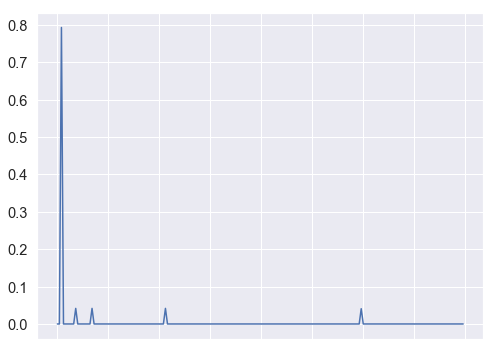

In [143]:
find_topics(0, df_topics_pred=df_topics_pred, topic_dict=topic_dict)

In [144]:
find_doc_freq_word("entry")

0.017849531116794545

In [145]:
find_doc_freq_word("table")

0.10208866155157716

Cleaned question n°1:
system dmv  s missing sql server  master dacpac ssdt    ola hallengren  s excellent maintenance solution scripts incorporated dba tools database project   maintained ssdt  target platform sql server    project includes references built in system databases master     msdb   project builds successfully      ola recently   updated   scripts include references sql server  dmv  s   incorporating updated scripts database project generated unresolved reference errors dmv  s         sql71502   procedure     dbo       databasebackup   unresolved reference object   sys       dm os host info   sql71502   procedure     dbo       databasebackup   unresolved reference object   sys       dm db log stats         although n t sql server  installed anywhere   tried updating target platform sql server  deleting recreating master database reference   i e   update master dacpac sql server  version     remove build errors       path referenced dacpac            program files   x86    m

[155, 13, 120]

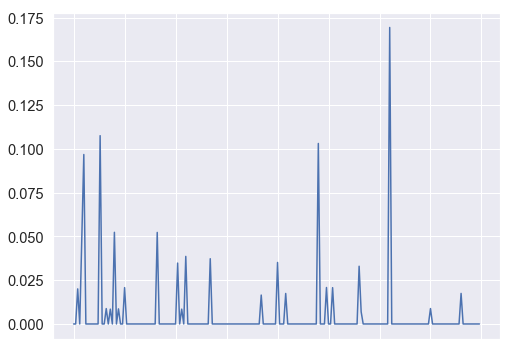

In [146]:
find_topics(1, df_topics_pred=df_topics_pred, topic_dict=topic_dict)

In [147]:
find_doc_freq_word("sql")

0.057384910485933506

Cleaned question n°123:
sql partition columns listofcolumnnames   would number rows table according many times given row occured table   tried define table columns follows         select column name cl information schema columns table name    test        would run following query        select     row number       partition cols cl order   select     rn test       second query works nicely manually specify column names partition   otherwise fails   way   motivation behind table without   row duplicates rid   second query inspired answers     question   ms sql       sample           column1   column2   column3                                                         aaaa             bbbb             cccc             dddd             bbbb             aaaa             aaaa                 sample           column1   column2   column3                                                         aaaa             bbbb             cccc             dddd             bbbb             aaaa              

[160, 2, 25]

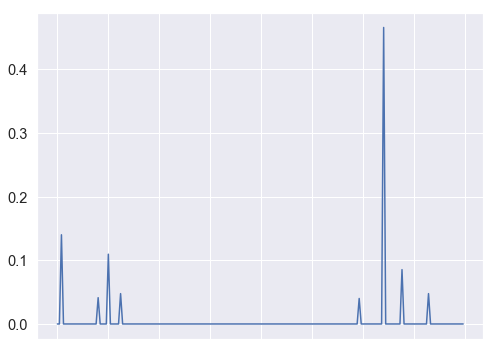

In [148]:
find_topics(123, df_topics_pred=df_topics_pred, topic_dict=topic_dict)

Cleaned question n°18:
display properties looping errors   spring bear       trying adjust display properties entity spring boot      form following inside display errors             ul         th   each     e         fields detailederrors          th   class         e global     globalerr   fielderr            span th   text         e global                e fieldname          field      span         span th   text         e message          message      span          li          ul           results following message upon invalid input         saving   please try lastname must empty   firstname size must    lastname size must    firstname must empty         tried adjusting property accommodate display avail           notempty   size   min     max        displayname      last      lastname                 display applicable field    

Tags :  <java><spring><spring-boot>

Index(['Topic_87', 'Topic_104', 'Topic_10'], dtype='object')
[87, 104, 10]
Topic 87 : span entiti global firstnam l

[87, 104, 10]

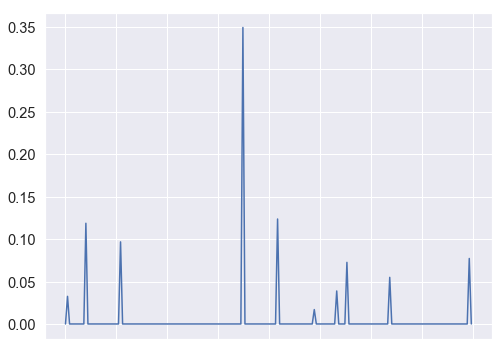

In [149]:
find_topics(18, df_topics_pred=df_topics_pred, topic_dict=topic_dict)

In [150]:
df_topics_pred.shape

(18768, 200)

In [151]:
df_quest_cleaned.shape

(18768, 36)

### LDA Optimization 1

#### Features

max_df=0.11, min_df=10

Train set used only

In [258]:
# init features
tf_vectorizer_1 = CountVectorizer(max_df=0.11, min_df=10, max_features=1000, 
                                tokenizer=myTokenizer)
tf_1 = tf_vectorizer_1.fit_transform(df_quest_cleaned[df_quest_cleaned.Train ==\
                                                 True]["token_text"])

# Define Search Param
search_params = {'n_components': [45, 50, 55], 
                 'learning_decay': [.7]}# Init the Model
lda_for_gcv_1 = LatentDirichletAllocation(max_iter=5, learning_method='online', 
                                        learning_offset=50.,random_state=0,
                                       n_jobs=-1)# Init Grid Search Class
gcv_lda_1 = GridSearchCV(lda_for_gcv_1, param_grid=search_params)

# Do the Grid Search
gcv_lda_1.fit(tf_1)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [45, 50, 55], 'learning_decay': [0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [488]:
gcv_lda_1.best_params_

{'learning_decay': 0.7, 'n_components': 45}

In [260]:
# Best Model
best_lda_model_1 = gcv_lda_1.best_estimator_# Model Parameters
print("Best Model's Params: ", gcv_lda_1.best_params_)# Log Likelihood Score
print("Best Log Likelihood Score: ", gcv_lda_1.best_score_)# Perplexity
print("Model Perplexity: ", best_lda_model_1.perplexity(tf_1))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 45}
Best Log Likelihood Score:  -2004030.5738902376
Model Perplexity:  359.49207446944934


In [261]:
df_res_1 = pd.DataFrame(data=gcv_lda_1.cv_results_)
df_res_1[df_res_1["rank_test_score"]<5].T

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

,0,1,2
mean_fit_time,20.5598,20.2284,22.2318
std_fit_time,1.30633,0.1052,1.82209
mean_score_time,0.959958,1.01729,1.01874
std_score_time,0.0212708,0.0265088,0.0209199
param_learning_decay,0.7,0.7,0.7
param_n_components,45,50,55
params,"{'learning_decay': 0.7, 'n_components': 45}","{'learning_decay': 0.7, 'n_components': 50}","{'learning_decay': 0.7, 'n_components': 55}"
split0_test_score,-2.074e+06,-2.07418e+06,-2.0714e+06
split1_test_score,-1.98545e+06,-1.99154e+06,-1.99148e+06
split2_test_score,-1.95263e+06,-1.95684e+06,-1.95815e+06


Topics : 

In [262]:
# create & display topic dictionnary 
no_top_words = 10
topic_dict_1 = display_topics(best_lda_model_1, 
                              tf_vectorizer_1.get_feature_names(), 
                              no_top_words)

Topic 0:
springframework org jar spring releas depend bean categori boot version
Topic 1:
icon devic visibl summari articl topic snapshot desc retriev clear
Topic 2:
anim modal player game account compani play employe report progress
Topic 3:
packag lib modul python instal site local usr download python3
Topic 4:
generat product step worker mysqli real base main mark structur
Topic 5:
imag img tag list src tab png target jpg firstnam
Topic 6:
let properti updat func role nil assign schedul complet swift
Topic 7:
item custom menu descript nav quantiti ion navbar list theme
Topic 8:
app path action address rout home group admin domain uri
Topic 9:
end cell rang sub next dim sort entri excel sheet
Topic 10:
array convert pdf branch page arr push obj featur integ
Topic 11:
php echo access store word root vue cat var stat
Topic 12:
paramet pass param job argument direct consum indexpath tableview publish
Topic 13:
queri number sql order count insert databas join record total
Topic 14:
key l

#### Predict Topics for each documents

##### TF transform for all questions (Train & Test)

(TF vectoriser fitted already on Train set)

In [263]:
tf_all_1 = tf_vectorizer_1.transform(df_quest_cleaned["token_text"])

In [264]:
topics_pred_1 = best_lda_model_1.transform(tf_all_1)


In [265]:
topicNames_1 = []
for idx in range(0, gcv_lda_1.best_params_["n_components"]):
    topicNames_1.append("Topic_{}".format(idx))

df_topics_pred_1 = pd.DataFrame(data=topics_pred_1,
                                index=df_quest_cleaned.index,
                               columns=topicNames_1)
df_model_1 = df_quest_cleaned.join(
    df_topics_pred_1)

In [266]:
df_topics_pred_1.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_33,Topic_34,Topic_35,Topic_36,Topic_37,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44
3,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.564474,...,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058
4,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.020667,0.000185,0.000185,0.020201,0.000185,0.022970,...,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.630006,0.000185,0.000185,0.009507,0.000185
9,0.000202,0.000202,0.000202,0.000202,0.000202,0.000202,0.000202,0.000202,0.000202,0.000202,0.000202,0.030760,...,0.036755,0.000202,0.000202,0.000202,0.000202,0.000202,0.101439,0.000202,0.000202,0.082239,0.067982,0.000202
10,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,...,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.156835,0.003175,0.003175
12,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,...,0.002222,0.102222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222


In [267]:
df_topics_pred_1.shape

(17744, 45)

In [268]:
df_quest_cleaned.shape

(17744, 36)

In [269]:
df_model_1.shape

(17744, 81)

In [270]:
df_model_1.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Topic_33,Topic_34,Topic_35,Topic_36,Topic_37,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.630006,0.000185,0.000185,0.009507,0.000185
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,0.036755,0.000202,0.000202,0.000202,0.000202,0.000202,0.101439,0.000202,0.000202,0.082239,0.067982,0.000202
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.156835,0.003175,0.003175
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,0.002222,0.102222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222


In [271]:
np.max(df_model_1.Tags.str.findall('\<').apply(lambda x: len(x)))

6

In [272]:
topic_dict_1

{0: 'springframework org jar spring releas depend bean categori boot version',
 1: 'icon devic visibl summari articl topic snapshot desc retriev clear',
 2: 'anim modal player game account compani play employe report progress',
 3: 'packag lib modul python instal site local usr download python3',
 4: 'generat product step worker mysqli real base main mark structur',
 5: 'imag img tag list src tab png target jpg firstnam',
 6: 'let properti updat func role nil assign schedul complet swift',
 7: 'item custom menu descript nav quantiti ion navbar list theme',
 8: 'app path action address rout home group admin domain uri',
 9: 'end cell rang sub next dim sort entri excel sheet',
 10: 'array convert pdf branch page arr push obj featur integ',
 11: 'php echo access store word root vue cat var stat',
 12: 'paramet pass param job argument direct consum indexpath tableview publish',
 13: 'queri number sql order count insert databas join record total',
 14: 'key load spark scala temp cach note s

Cleaned question n°0:
insert entry table exist   table looks sql server       wordid word                          pen  men  cat       wordid word passed stored procedure   need check stored procedure wordid already exists table   wordid n t exists need execute insert statement    

Tags :  <c#><sql><sql-server>

Index(['Topic_11', 'Topic_13'], dtype='object')
[11, 13]
Topic 11 : php echo access store word root vue cat var stat
Topic 13 : queri number sql order count insert databas join record total


[11, 13]

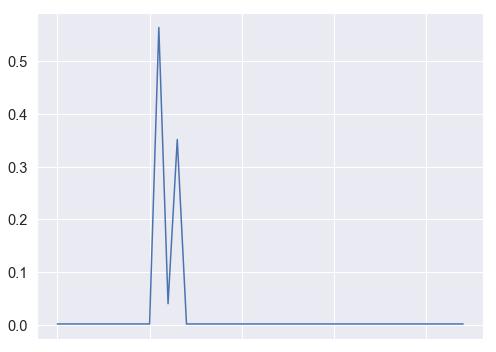

In [273]:
find_topics(0, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

Cleaned question n°123:
change sender email credentials according application rails     give different sender email credentials according application rails fetched database     

Tags :  <ruby-on-rails><ruby-on-rails-3>

Index(['Topic_18', 'Topic_42', 'Topic_31'], dtype='object')
[18, 42, 31]
Topic 18 : server connect client applic except net host port send close
Topic 42 : user request email respons password post usernam status token login
Topic 31 : servic http info config configur default web plugin applic bundl


[18, 42, 31]

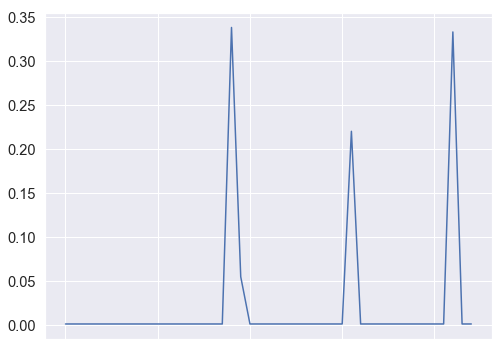

In [274]:
find_topics(123, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

Cleaned question n°132:
clear input fields angular2             description     textarea type          refrence class     form control    id     description    pattern         a za z0              required minlength         maxlength             ngmodel          model description    name     description      description     ngmodel             textarea     amount     input type        id     myinput      refrence   amountinput     ngmodel    class     form control    id     amount    required minlength        maxlength            model amountinput    name     amount        customer     input type          refrence placeholder     customer    class     form control    id     customer    pattern         a za z             required minlength        maxlength         name     customer      customer     ngmodel            span style     float   right              click        refrence value                class     fa fa clean o    style     font size 36px             i          a          

[29, 7, 43]

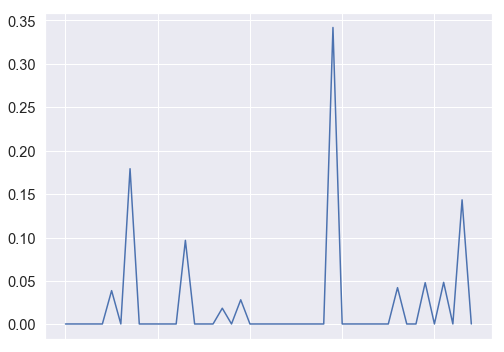

In [275]:
find_topics(132, df_topics_pred=df_topics_pred_1, topic_dict=topic_dict_1)

#### Predict tags

Extract unique train tags : 

In [276]:
list_tags = list(np.unique(list_tags_raw_train)) 
print("number of tags:",len(list_tags))
list_tags[:10]

number of tags: 6367


['.htaccess',
 '.lib',
 '.net',
 '.net-1.1',
 '.net-4.5',
 '.net-4.6.1',
 '.net-4.6.2',
 '.net-assembly',
 '.net-core',
 '.net-framework-version']

In [277]:
re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                           df_model_1.iloc[0].Tags)

['c#', 'sql', 'sql-server']

##### Create table linking Tags & Topics :

Method :
- For each documents, and for each tags of the document : 
    - we add to its Tag line, its distribution by topics.
- So, Each tags line contains the sum of all topics distribution

In [278]:
# init dataFrame
df_topics_tags_raw = pd.DataFrame(index=list_unique_tags, columns=topicNames_1, data=0)

df_model_1_topics = df_model_1[df_model_1["Train"] == True].filter(
    items=topicNames_1)

t_0 = time.time()
# for each docs, for each of its tags, add its topics distrib  
for idx in range(0, df_model_1_topics.shape[0]):
    list_tags_curr = re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                           df_model_1[df_model_1["Train"] == True].\
                                iloc[idx].Tags)
    for tag_curr in list_tags_curr:
        if tag_curr in list_unique_tags:
            df_topics_tags_raw.loc[tag_curr] += df_model_1_topics.iloc[idx]
        #else:
            #print('Tag {} not into most frequent tags !', tag_curr)

t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))


timing total: 170.82429099082947 s


In [279]:
df_topics_tags = df_topics_tags_raw.copy()

In [584]:
df_topics_tags.shape

(6367, 45)

In [585]:
df_topics_tags.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_33,Topic_34,Topic_35,Topic_36,Topic_37,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44
.htaccess,1.666277e-04,4.559883e-05,1.635116e-04,0.000043,0.000240,6.520951e-04,0.000131,1.647461e-04,1.217153e-03,5.249140e-05,1.426973e-04,3.560176e-03,...,1.686115e-04,8.039130e-05,5.297827e-05,1.206098e-04,1.498967e-05,0.000091,8.742653e-05,0.000148,5.640794e-06,4.757781e-04,1.477818e-04,0.000035
.lib,3.670463e-07,9.952789e-07,5.504157e-07,0.000076,0.000021,3.275505e-07,0.000017,4.468985e-07,3.661843e-07,2.188018e-07,2.540265e-07,3.244453e-07,...,3.710657e-07,3.481768e-07,3.584307e-07,2.422975e-07,3.271774e-07,0.000025,1.388491e-07,0.000112,1.231208e-07,1.233678e-07,2.921289e-07,0.000630
.net,1.249225e-03,3.215856e-03,1.290676e-03,0.002179,0.003391,2.686978e-03,0.002998,3.016020e-03,2.509501e-03,4.351147e-03,3.656886e-03,2.671670e-03,...,2.839515e-03,4.493420e-03,1.075699e-03,1.717293e-03,7.139048e-04,0.001150,1.614457e-03,0.012648,6.430509e-04,3.029674e-03,3.346183e-03,0.004562
.net-1.1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
.net-4.5,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000


In [280]:
df_model_1[df_model_1["Train"] == True].shape

(14195, 81)

In [281]:
df_model_1.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Topic_33,Topic_34,Topic_35,Topic_36,Topic_37,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.630006,0.000185,0.000185,0.009507,0.000185
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,0.036755,0.000202,0.000202,0.000202,0.000202,0.000202,0.101439,0.000202,0.000202,0.082239,0.067982,0.000202
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.003175,0.156835,0.003175,0.003175
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,0.002222,0.102222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222


In [282]:
df_model_1_topics.shape

(14195, 45)

In [283]:
df_model_1_topics.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_33,Topic_34,Topic_35,Topic_36,Topic_37,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44
3,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.564474,...,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058
4,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.020667,0.000185,0.000185,0.020201,0.000185,0.022970,...,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.000185,0.630006,0.000185,0.000185,0.009507,0.000185
12,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,...,0.002222,0.102222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222,0.002222
13,0.000377,0.000377,0.000377,0.000377,0.017479,0.000377,0.000377,0.000377,0.094104,0.000377,0.018426,0.215914,...,0.000377,0.000377,0.000377,0.000377,0.000377,0.000377,0.058389,0.000377,0.000377,0.000377,0.000377,0.000377
14,0.001058,0.001058,0.001058,0.463921,0.001058,0.001058,0.070105,0.001058,0.001058,0.001058,0.001058,0.001058,...,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058,0.001058


In [284]:
df_topics_tags.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_33,Topic_34,Topic_35,Topic_36,Topic_37,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44
.htaccess,0.096078,0.009696,0.062872,0.049295,0.096244,0.421338,0.116473,0.078020,0.703467,0.050773,0.118887,2.322353,...,0.096169,0.048866,0.031282,0.105349,0.009696,0.112259,0.133260,0.172602,0.009696,0.816208,0.107064,0.035067
.lib,0.000212,0.000212,0.000212,0.087679,0.008599,0.000212,0.014655,0.000212,0.000212,0.000212,0.000212,0.000212,...,0.000212,0.000212,0.000212,0.000212,0.000212,0.030946,0.000212,0.130290,0.000212,0.000212,0.000212,0.637122
.net,0.720307,0.683833,0.496277,2.516219,1.360091,1.736137,2.661724,1.428313,1.450394,4.208731,3.046707,1.742768,...,1.619539,2.731338,0.635161,1.500009,0.461801,1.415274,2.460831,14.775684,1.105381,5.197475,2.424227,4.614495
.net-1.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
.net-4.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


##### Normalisation by Tags

In [285]:
df_topics_tags_norm = df_topics_tags.copy()

for idx, row_curr in df_topics_tags_norm.iterrows():
    #print(idx)
    df_topics_tags_norm.loc[idx] = row_curr/row_curr.sum()
df_topics_tags_norm.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_33,Topic_34,Topic_35,Topic_36,Topic_37,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44
.htaccess,0.006405,0.000646,0.004191,0.003286,0.006416,0.028089,0.007765,0.005201,0.046898,0.003385,0.007926,0.154824,...,0.006411,0.003258,0.002085,0.007023,0.000646,0.007484,0.008884,0.011507,0.000646,0.054414,0.007138,0.002338
.lib,0.000212,0.000212,0.000212,0.087679,0.008599,0.000212,0.014655,0.000212,0.000212,0.000212,0.000212,0.000212,...,0.000212,0.000212,0.000212,0.000212,0.000212,0.030946,0.000212,0.130290,0.000212,0.000212,0.000212,0.637122
.net,0.004739,0.004499,0.003265,0.016554,0.008948,0.011422,0.017511,0.009397,0.009542,0.027689,0.020044,0.011466,...,0.010655,0.017969,0.004179,0.009868,0.003038,0.009311,0.016190,0.097208,0.007272,0.034194,0.015949,0.030359
.net-1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
.net-4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Normalisation by Topics

In [286]:
df_topics_tags_norm = df_topics_tags.copy()
#for label, content in df.items():
for topic_label, col_values in df_topics_tags_norm.items():
    #print(idx)
    df_topics_tags_norm[topic_label] = col_values/col_values.sum()
df_topics_tags_norm.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_33,Topic_34,Topic_35,Topic_36,Topic_37,Topic_38,Topic_39,Topic_40,Topic_41,Topic_42,Topic_43,Topic_44
.htaccess,1.666277e-04,4.559883e-05,1.635116e-04,0.000043,0.000240,6.520951e-04,0.000131,1.647461e-04,1.217153e-03,5.249140e-05,1.426973e-04,3.560176e-03,...,1.686115e-04,8.039130e-05,5.297827e-05,1.206098e-04,1.498967e-05,0.000091,8.742653e-05,0.000148,5.640794e-06,4.757781e-04,1.477818e-04,0.000035
.lib,3.670463e-07,9.952789e-07,5.504157e-07,0.000076,0.000021,3.275505e-07,0.000017,4.468985e-07,3.661843e-07,2.188018e-07,2.540265e-07,3.244453e-07,...,3.710657e-07,3.481768e-07,3.584307e-07,2.422975e-07,3.271774e-07,0.000025,1.388491e-07,0.000112,1.231208e-07,1.233678e-07,2.921289e-07,0.000630
.net,1.249225e-03,3.215856e-03,1.290676e-03,0.002179,0.003391,2.686978e-03,0.002998,3.016020e-03,2.509501e-03,4.351147e-03,3.656886e-03,2.671670e-03,...,2.839515e-03,4.493420e-03,1.075699e-03,1.717293e-03,7.139048e-04,0.001150,1.614457e-03,0.012648,6.430509e-04,3.029674e-03,3.346183e-03,0.004562
.net-1.1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
.net-4.5,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000


In [287]:
np.sum(df_topics_tags_norm, axis=0)

Topic_0     1.0
Topic_1     1.0
Topic_2     1.0
Topic_3     1.0
Topic_4     1.0
Topic_5     1.0
Topic_6     1.0
Topic_7     1.0
Topic_8     1.0
Topic_9     1.0
Topic_10    1.0
Topic_11    1.0
Topic_12    1.0
Topic_13    1.0
Topic_14    1.0
Topic_15    1.0
Topic_16    1.0
Topic_17    1.0
Topic_18    1.0
Topic_19    1.0
Topic_20    1.0
Topic_21    1.0
Topic_22    1.0
Topic_23    1.0
Topic_24    1.0
Topic_25    1.0
Topic_26    1.0
Topic_27    1.0
Topic_28    1.0
Topic_29    1.0
Topic_30    1.0
Topic_31    1.0
Topic_32    1.0
Topic_33    1.0
Topic_34    1.0
Topic_35    1.0
Topic_36    1.0
Topic_37    1.0
Topic_38    1.0
Topic_39    1.0
Topic_40    1.0
Topic_41    1.0
Topic_42    1.0
Topic_43    1.0
Topic_44    1.0
dtype: float64

In [288]:
df_topics_tags = df_topics_tags_norm.copy()
df_topics_tags.shape

(6367, 45)

In [289]:
find_tags_from_topic(8, df_topics_tags=df_topics_tags)

['javascript',
 'php',
 'laravel',
 'python',
 'android',
 'java',
 'c#',
 'angular',
 'reactjs',
 'node.js']

In [290]:
# exemple : Topic 8 : url page link default icon www browser tab website chrome => .htaccess (5.17..)
topic_dict_1[8]

'app path action address rout home group admin domain uri'

In [291]:
topic_dict_1[1]

'icon devic visibl summari articl topic snapshot desc retriev clear'

In [292]:
find_tags_from_topic(1, df_topics_tags=df_topics_tags)

['android',
 'javascript',
 'java',
 'c#',
 'ios',
 'html',
 'css',
 'python',
 'swift',
 'angular']

In [293]:
topic_dict_1[2]

'anim modal player game account compani play employe report progress'

In [294]:
find_tags_from_topic(2, df_topics_tags=df_topics_tags)

['javascript',
 'java',
 'python',
 'android',
 'html',
 'c#',
 'jquery',
 'css',
 'sql',
 'ios']

In [295]:
topic_dict_1[3]

'packag lib modul python instal site local usr download python3'

In [296]:
find_tags_from_topic(3, df_topics_tags=df_topics_tags)

['python',
 'node.js',
 'python-3.x',
 'javascript',
 'django',
 'r',
 'java',
 'angular',
 'linux',
 'android']

##### Find predicted Tags from questions : 
- Find Topics from Questions
- Find Tags from Topics

Example for question n° 0:


Cleaned question n°0:
insert entry table exist   table looks sql server       wordid word                          pen  men  cat       wordid word passed stored procedure   need check stored procedure wordid already exists table   wordid n t exists need execute insert statement    

Tags :  <c#><sql><sql-server>

Index(['Topic_11', 'Topic_13'], dtype='object')
[11, 13]
Topic 11 : php echo access store word root vue cat var stat
Topic 13 : queri number sql order count insert databas join record total


['php',
 'javascript',
 'python',
 'mysql',
 'html',
 'laravel',
 'vue.js',
 'java',
 'wordpress',
 'sql']

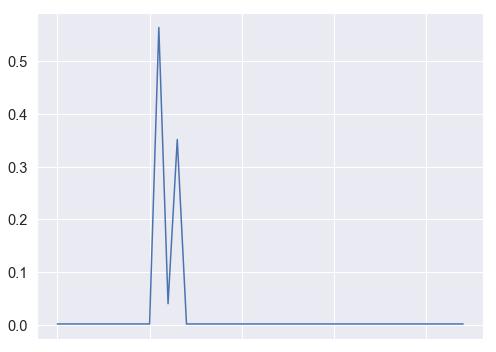

In [297]:
list_topic_id = find_topics(quest_iloc=0, freq_min=0.1, 
                            df_topics_pred=df_topics_pred_1,
                            topic_dict=topic_dict_1)

find_tags_from_topic(iloc_topic=list_topic_id[0], df_topics_tags=df_topics_tags)

Cleaned question n°1:
system dmv  s missing sql server  master dacpac ssdt    ola hallengren  s excellent maintenance solution scripts incorporated dba tools database project   maintained ssdt  target platform sql server    project includes references built in system databases master     msdb   project builds successfully      ola recently   updated   scripts include references sql server  dmv  s   incorporating updated scripts database project generated unresolved reference errors dmv  s         sql71502   procedure     dbo       databasebackup   unresolved reference object   sys       dm os host info   sql71502   procedure     dbo       databasebackup   unresolved reference object   sys       dm db log stats         although n t sql server  installed anywhere   tried updating target platform sql server  deleting recreating master database reference   i e   update master dacpac sql server  version     remove build errors       path referenced dacpac            program files   x86    m

['c#',
 'c++',
 'java',
 'android',
 'python',
 'visual-studio',
 'javascript',
 '.net',
 'r',
 'php']

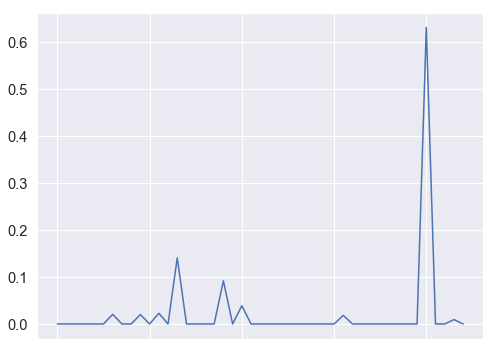

In [298]:
find_pred_tags_from_quest(quest_iloc=1, freq_min=0.1, 
                          df_topics_pred=df_topics_pred_1,
                          topic_dict=topic_dict_1,
                          df_topics_tags=df_topics_tags)


Cleaned question n°18:
display properties looping errors   spring bear       trying adjust display properties entity spring boot      form following inside display errors             ul         th   each     e         fields detailederrors          th   class         e global     globalerr   fielderr            span th   text         e global                e fieldname          field      span         span th   text         e message          message      span          li          ul           results following message upon invalid input         saving   please try lastname must empty   firstname size must    lastname size must    firstname must empty         tried adjusting property accommodate display avail           notempty   size   min     max        displayname      last      lastname                 display applicable field    

Tags :  <java><spring><spring-boot>

Index(['Topic_5', 'Topic_29', 'Topic_43'], dtype='object')
[5, 29, 43]
Topic 5 : imag img tag list src tab png targ

['javascript',
 'html',
 'python',
 'css',
 'android',
 'php',
 'jquery',
 'java',
 'c#',
 'image']

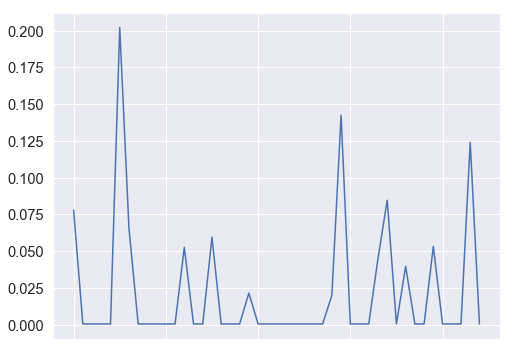

In [299]:
find_pred_tags_from_quest(quest_iloc=18, freq_min=0.1, 
                          df_topics_pred=df_topics_pred_1,
                          topic_dict=topic_dict_1,
                          df_topics_tags=df_topics_tags)


Cleaned question n°123:
change sender email credentials according application rails     give different sender email credentials according application rails fetched database     

Tags :  <ruby-on-rails><ruby-on-rails-3>

Index(['Topic_18', 'Topic_42', 'Topic_31'], dtype='object')
[18, 42, 31]
Topic 18 : server connect client applic except net host port send close
Topic 42 : user request email respons password post usernam status token login
Topic 31 : servic http info config configur default web plugin applic bundl


['c#',
 'java',
 'python',
 'javascript',
 'php',
 'android',
 'node.js',
 'mysql',
 'asp.net',
 'sql-server']

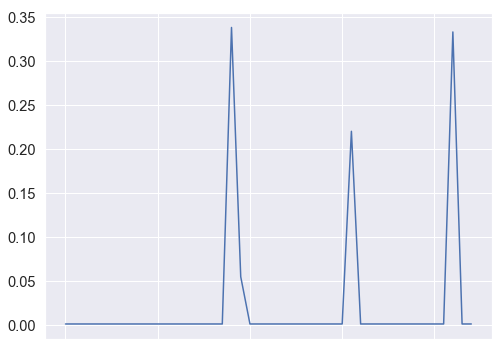

In [300]:
find_pred_tags_from_quest(quest_iloc=123, freq_min=0.1, 
                          df_topics_pred=df_topics_pred_1,
                          topic_dict=topic_dict_1,
                          df_topics_tags=df_topics_tags)

##### Predict Tags from question Text :

- Text -> Features
- Features -> TF -> LDA.transfom -> topic ditrib

In [301]:
df_quest_cleaned.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Tag_2,Tag_3,Tag_4,flag_Tag_0,flag_Tag_1,flag_Tag_2,flag_Tag_3,flag_Tag_4,flag_most_Tagged,Text,token_text,Train
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,sql-server,NaN,NaN,True,True,True,False,False,True,How to insert an entry to a table only if it d...,insert entry table exist table looks sql ser...,True
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,NaN,NaN,NaN,True,False,False,False,False,True,System DMV's missing from SQL Server 2017 mast...,system dmv s missing sql server master dacpa...,True
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,ajax,NaN,NaN,True,True,True,False,False,True,how to insert data in databse without page rel...,insert databse without page reload insert ...,False
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,file-upload,multipart,NaN,True,False,False,False,False,True,How to upload image using multipart in Amazon ...,upload multipart amazon s3 upload amazon s3 ...,False
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,crosstab,NaN,NaN,True,False,False,False,False,True,DB2 SQL CROSSTAB <p>I would like to output a t...,db2 sql crosstab would output table transf...,True


In [302]:
# example 1st question
text_test = df_quest_cleaned.iloc[0]["Text"]
print(text_test)
# clean the text
text_cleaned = cleaning_text(text_test)

# calculate feature from text
feat_curr =  tf_vectorizer_1.transform([text_cleaned])

# calculate topic distrib
topic_distrib_pred = best_lda_model_1.transform(feat_curr)

# find best topic
find_tags_from_topic(topic_distrib_pred.argmax(), 
                     df_topics_tags=df_topics_tags, 
                     no_max=10)

How to insert an entry to a table only if it does not exist <p>My table looks like this  on sql server</p>

<pre><code>wordId     word      
----------------
1214       pen           
1215       men    
1216       cat  
</code></pre>

<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>



['php',
 'javascript',
 'python',
 'mysql',
 'html',
 'laravel',
 'vue.js',
 'java',
 'wordpress',
 'sql']

In [303]:
# example  question
text_test = df_quest_cleaned.iloc[1]["Text"]
print(text_test)
 
find_tags_from_text(text=text_test, tf_vectorizer=tf_vectorizer_1,
                    lda_model = best_lda_model_1, df_topics_tags=df_topics_tags,
                    no_max=10)

System DMV's missing from SQL Server 2017 master.dacpac in SSDT 2015 <p>I have Ola Hallengren's excellent Maintenance Solution scripts incorporated in to a DBA tools database project.  This is maintained using SSDT 2015 with a target platform of SQL Server 2012.  The project includes references to the built-in system databases master &amp; msdb.  The project builds successfully.</p>

<p>Ola has recently <a href="https://ola.hallengren.com/versions.html" rel="nofollow noreferrer">updated</a> his scripts and they now include references to new SQL Server 2017 DMV's, so incorporating the updated scripts into my database project generated unresolved reference errors for the new DMV's.  </p>

<pre><code>SQL71502: Procedure: [dbo].[DatabaseBackup] has an unresolved reference to object [sys].[dm_os_host_info]
SQL71502: Procedure: [dbo].[DatabaseBackup] has an unresolved reference to object [sys].[dm_db_log_stats]
</code></pre>

<p>Although I don't have SQL Server 2017 installed anywhere, I tri

['c#',
 'c++',
 'java',
 'android',
 'python',
 'visual-studio',
 'javascript',
 '.net',
 'r',
 'php']

In [304]:
# example  question
text_test = df_quest_cleaned.iloc[18]["Text"]
print(text_test)

# predicted tags
find_tags_from_text(text=text_test, tf_vectorizer=tf_vectorizer_1,
                    lda_model = best_lda_model_1, df_topics_tags=df_topics_tags,
                    no_max=10)

Display name of properties when looping through errors <p>I am new to Spring so bear with me!</p>

<p>I am trying to adjust the display name of properties of an entity in Spring boot.</p>

<p>I have a form with the following inside to display all errors:</p>

<pre><code>&lt;ul&gt;
    &lt;li th:each="e : ${#fields.detailedErrors()}" th:class="${e.global}? globalerr : fielderr"&gt;
        &lt;span th:text="${e.global}? '*' : ${e.fieldName}"&gt;The field name&lt;/span&gt;
        &lt;span th:text="${e.message}"&gt;The error message&lt;/span&gt;
    &lt;/li&gt;
&lt;/ul&gt;
</code></pre>

<p>That results in the following message upon invalid input:</p>

<blockquote>
  <p>Error Saving New User - Please Try Again
  lastName must not be empty <br>
  firstName size must be between 1 and 30<br>
  lastName size must be between 1 and 30<br>
  firstName must not be empty<br></p>
</blockquote>

<p>I have tried adjusting the property to accommodate a display name to no avail:</p>

<pre><code>@NotEm

['javascript',
 'html',
 'python',
 'css',
 'android',
 'php',
 'jquery',
 'java',
 'c#',
 'image']

In [305]:
# example  question
text_test = df_quest_cleaned.iloc[123]["Text"]
print(text_test)
print("Tags : ", df_quest_cleaned.iloc[123]["Tags"])
# predicted tags
find_tags_from_text(text=text_test, tf_vectorizer=tf_vectorizer_1,
                    lda_model = best_lda_model_1, df_topics_tags=df_topics_tags,
                    no_max=10)


how to change the sender email credentials according to the user of application in rails <p><em>I want to give different sender email credentials according to the user of application in rails which will be fetched from database.</em></p>

Tags :  <ruby-on-rails><ruby-on-rails-3>


['c#',
 'java',
 'python',
 'javascript',
 'php',
 'android',
 'node.js',
 'mysql',
 'asp.net',
 'sql-server']

#### Evaluation
Method : Check if real Tags are into the 5 or 10 first predicted Tags

In [306]:
nb_tags_eval_max = 10

t_0 = time.time()

df_model_1["score_lda_1"] = 0

list_scores = []
for idx in range(0, df_model_1.shape[0]):
    
    # predict tags
    text_test = df_model_1.iloc[idx]["Text"]
    tags_pred = find_tags_from_text(text=text_test, 
                                    tf_vectorizer=tf_vectorizer_1,
                                    lda_model=best_lda_model_1, 
                                    df_topics_tags=df_topics_tags,
                                    no_max=nb_tags_eval_max)
    # real tags
    tags_real = re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                           df_quest_cleaned.iloc[idx]["Tags"])
    # score
    list_scores.append(score_eval_tags(tags_real, tags_pred))

t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))

df_model_1["score_lda_1"] = list_scores  

timing total: 256.10280203819275 s


In [573]:
def predict_tags_from_list_texts(list_texts,tf_vectorizer,
                                    lda_model, 
                                    df_topics_tags,
                                    no_max):
    '''
    Predict a list of list of tags from list of text
    
    no_max determined the maximum number of tags predicted for each text in
    input.
    '''
    list_predicted_tags = []
    for text_curr in list_texts:
        # predict tags
        tags_pred = find_tags_from_text(text=text_curr, 
                                    tf_vectorizer=tf_vectorizer,
                                    lda_model=lda_model, 
                                    df_topics_tags=df_topics_tags,
                                    no_max=no_max)
        list_predicted_tags.append(tags_pred)
        
    return list_predicted_tags


t_0 = time.time()        

list_tags_predicted_train = predict_tags_from_list_texts(
    df_model_1[df_model_1["Train"] == True]["Text"],
                                    tf_vectorizer=tf_vectorizer_1,
                                    lda_model=best_lda_model_1, 
                                    df_topics_tags=df_topics_tags,
                                    no_max=nb_tags_eval_max)

list_tags_predicted_test = predict_tags_from_list_texts(
    df_model_1[df_model_1["Train"] == False]["Text"],
                                    tf_vectorizer=tf_vectorizer_1,
                                    lda_model=best_lda_model_1, 
                                    df_topics_tags=df_topics_tags,
                                    no_max=nb_tags_eval_max)

t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))

print("\nFor Train:\n", list_tags_predicted_train[:10])
print("\nFor Test:\n", list_tags_predicted_test[:10])

timing total: 263.5440239906311 s

For Train:
 [['php', 'javascript', 'python', 'mysql', 'html', 'laravel', 'vue.js', 'java', 'wordpress', 'sql'], ['c#', 'c++', 'java', 'android', 'python', 'visual-studio', 'javascript', '.net', 'r', 'php'], ['python', 'r', 'pandas', 'dataframe', 'sql', 'excel', 'javascript', 'numpy', 'python-3.x', 'c#'], ['python', 'java', 'docker', 'javascript', 'php', 'c#', 'android', 'node.js', 'bash', 'python-3.x'], ['python', 'node.js', 'python-3.x', 'javascript', 'django', 'r', 'java', 'angular', 'linux', 'android'], ['android', 'java', 'c#', 'android-fragments', 'ios', 'javascript', 'swift', 'firebase', 'spring', 'php'], ['javascript', 'json', 'java', 'python', 'c#', 'php', 'android', 'node.js', 'jquery', 'reactjs'], ['python', 'sql', 'javascript', 'r', 'php', 'java', 'c#', 'datetime', 'mysql', 'sql-server'], ['swift', 'ios', 'javascript', 'c#', 'python', 'java', 'android', 'xcode', 'php', 'angular'], ['apache-spark', 'python', 'javascript', 'java', 'scala', 'c

In [ ]:
list_list_tags_train

In [595]:
mlb_lda = MultiLabelBinarizer()
enc_lda_y_train = mlb_lda.fit_transform(list_list_all_tags_train \
                                        + list_list_all_tags_test)
print("Train shape:", enc_lda_y_train.shape)
enc_lda_y_test = mlb_lda.transform(list_list_all_tags_test)
print("Test shape:", enc_lda_y_test.shape)

Train shape: (17744, 7182)
Test shape: (3549, 7182)


In [ ]:
list_list_all_tags_train
list_tags_predicted_train

list_list_all_tags_test
list_tags_predicted_test

In [574]:
len(list_list_all_tags_train)

14195

In [575]:
len(list_tags_predicted_train)

14195

In [576]:
len(list_list_all_tags_test)

3549

In [577]:
len(list_tags_predicted_test)

3549

In [534]:
precision_score([tags_real], [tags_pred], average='samples')

ValueError: multiclass-multioutput is not supported

In [540]:
tags_pred

['javascript',
 'html',
 'php',
 'python',
 'jquery',
 'java',
 'c#',
 'android',
 'css',
 'angular']

In [545]:
tags_real

['vb.net', 'forms', 'dll', 'fffff', 'ppoo', 'mkllmklmklkm', 'lmklmklmjiji']

In [307]:
#fig = plt.figure(figsize=(8, 8))
#plt.title("title")
df_model_1["score_lda_1"].value_counts()

0.000000    4192
0.500000    3363
0.333333    2795
1.000000    2154
0.250000    1847
0.200000    1241
0.666667    1007
0.400000     633
0.750000     234
0.600000     209
0.800000      69
Name: score_lda_1, dtype: int64

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


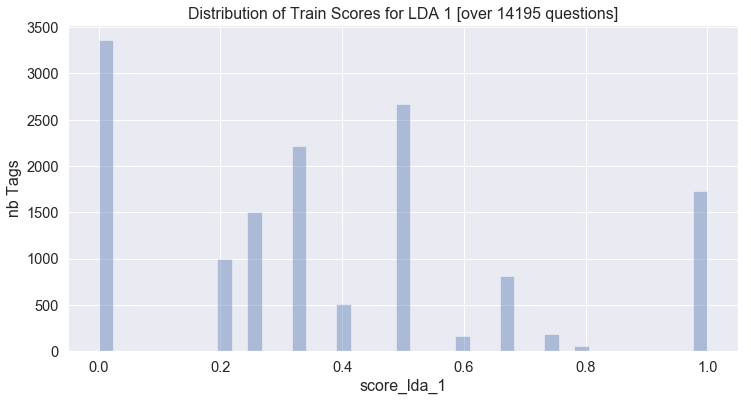

In [308]:
fig = plt.figure(figsize=(12, 6))
plt.title("Distribution of Train Scores for LDA 1 [over {} questions]".format(
    df_model_1[df_model_1.Train == True].shape[0]))
ax = sns.distplot(df_model_1[df_model_1.Train == True]["score_lda_1"], 
                  kde=False)
ax.set_ylabel('nb Tags');

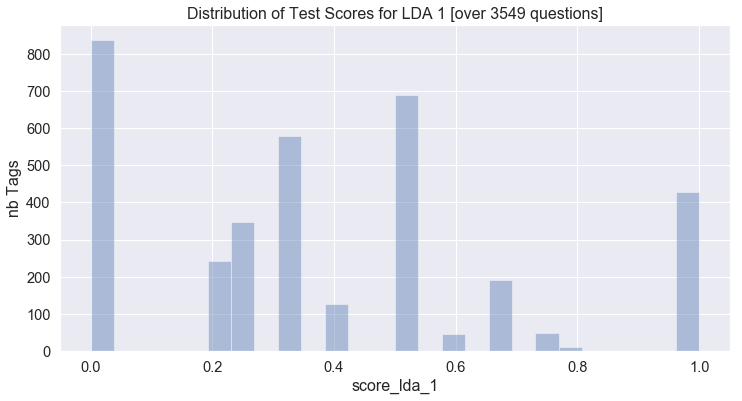

In [309]:
fig = plt.figure(figsize=(12, 6))
plt.title("Distribution of Test Scores for LDA 1 [over {} questions]".format(
    df_model_1[df_model_1.Train == False].shape[0]))
ax = sns.distplot(df_model_1[df_model_1.Train == False]["score_lda_1"], 
                  kde=False)
ax.set_ylabel('nb Tags');

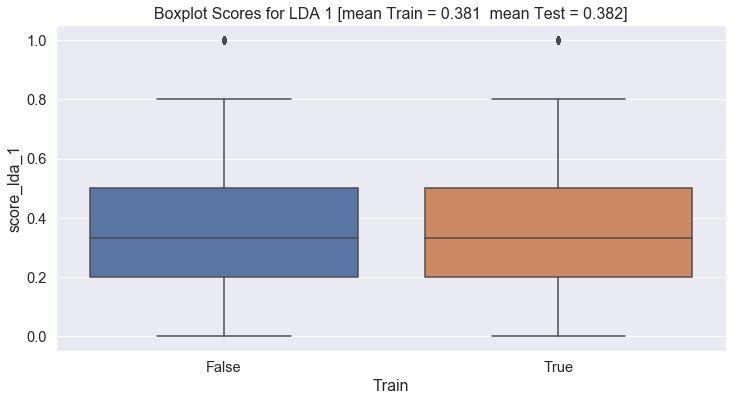

In [310]:
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplot Scores for LDA 1 [mean Train = {:.3f}  mean Test = {:.3f}]".\
          format(df_model_1[df_model_1.Train == True]["score_lda_1"].mean(),
                df_model_1[df_model_1.Train == False]["score_lda_1"].mean()))
ax = sns.boxplot(y="score_lda_1", x='Train', data=df_model_1)


##### At least one Tag ok

In [311]:
df_model_1["score_OK_lda_1"] = df_model_1["score_lda_1"] > 0

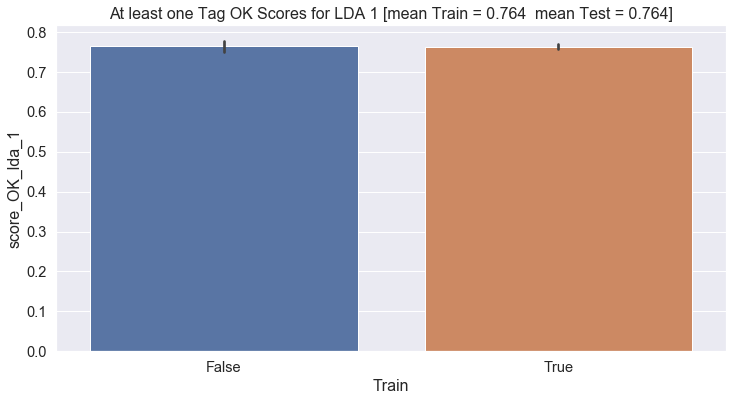

In [312]:
fig = plt.figure(figsize=(12, 6))
plt.title("At least one Tag OK Scores for LDA 1 [mean Train = {:.3f}  mean Test = {:.3f}]".\
          format(df_model_1[df_model_1.Train == True]["score_OK_lda_1"].mean(),
                df_model_1[df_model_1.Train == False]["score_OK_lda_1"].mean()))
ax = sns.barplot(y="score_OK_lda_1", x='Train', data=df_model_1)
#ax = sns.barplot(x="day", y="total_bill", data=tips)

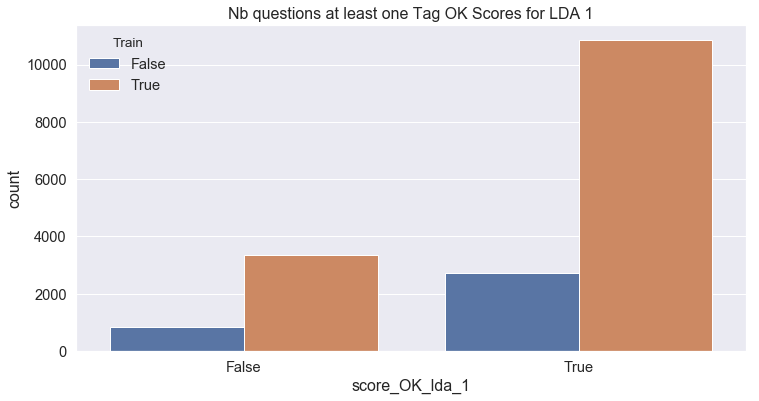

In [313]:
fig = plt.figure(figsize=(12, 6))
plt.title("Nb questions at least one Tag OK Scores for LDA 1")
ax = sns.countplot(x="score_OK_lda_1", hue="Train", data=df_model_1)

##### Precision

##### Sensitivity / Recall

##### F1-score

### LDA Optim 2

#### Features

max_df=0.04, min_df=10

Train set used only

In [263]:
# init features
tf_vectorizer_2 = CountVectorizer(max_df=0.04, min_df=10, max_features=1000, 
                                tokenizer=myTokenizer)
tf_2 = tf_vectorizer_2.fit_transform(df_quest_cleaned[df_quest_cleaned.Train ==\
                                                 True]["token_text"])

# Define Search Param
search_params = {'n_components': [55, 60, 65], 
                 'learning_decay': [ .7]}# Init the Model
lda_for_gcv_2 = LatentDirichletAllocation(max_iter=5, learning_method='online', 
                                        learning_offset=50.,random_state=0,
                                       n_jobs=-1)# Init Grid Search Class
gcv_lda_2 = GridSearchCV(lda_for_gcv_2, param_grid=search_params)

# Do the Grid Search
gcv_lda_2.fit(tf_2)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [55, 60, 65], 'learning_decay': [0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [264]:
gcv_lda_2.best_params_

{'learning_decay': 0.7, 'n_components': 60}

In [265]:
# Best Model
best_lda_model_2 = gcv_lda_2.best_estimator_# Model Parameters
print("Best Model's Params: ", gcv_lda_2.best_params_)# Log Likelihood Score
print("Best Log Likelihood Score: ", gcv_lda_2.best_score_)# Perplexity
print("Model Perplexity: ", best_lda_model_2.perplexity(tf_2))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 60}
Best Log Likelihood Score:  -1118541.0672432913
Model Perplexity:  351.4459298827758


In [266]:
df_res_2 = pd.DataFrame(data=gcv_lda_2.cv_results_)
df_res_2[df_res_2["rank_test_score"]<5].T

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

,0,1,2
mean_fit_time,19.7157,18.7358,20.4582
std_fit_time,2.40745,1.90972,0.717182
mean_score_time,0.728038,0.702213,1.0499
std_score_time,0.0364867,0.00946077,0.239981
param_learning_decay,0.7,0.7,0.7
param_n_components,55,60,65
params,"{'learning_decay': 0.7, 'n_components': 55}","{'learning_decay': 0.7, 'n_components': 60}","{'learning_decay': 0.7, 'n_components': 65}"
split0_test_score,-1.16016e+06,-1.15327e+06,-1.15442e+06
split1_test_score,-1.10538e+06,-1.10892e+06,-1.10968e+06
split2_test_score,-1.09094e+06,-1.09342e+06,-1.09711e+06


Topics : 

In [267]:
# create & display topic dictionnary 
no_top_words = 10
topic_dict_2 = display_topics(best_lda_model_2, 
                              tf_vectorizer_2.get_feature_names(), 
                              no_top_words)

Topic 0:
col tag btn django img submit ajax section phone bootstrap
Topic 1:
layout android intent parent tostr wrap fragment textview context toast
Topic 2:
springframework jar spring releas bean boot artifactid groupid annot scope
Topic 3:
product categori price modal oper mysqli real dialog trim id
Topic 4:
out println serial person side extract peopl arraylist todo ioexcept
Topic 5:
frame char integ printf fill mat structur camera edg ident
Topic 6:
amount quantiti registr sale histori convers payment invoic dont ticket
Topic 7:
android support firebas push notif transform io npm nativ jpg
Topic 8:
stream receiv async websit alert await queue azur wait bool
Topic 9:
level mode asp compani proxi runtim employe articl previous guid
Topic 10:
download sort chart tree channel axi curl choic relat selector
Topic 11:
templat func arg hello languag nil sender appear tableview swift
Topic 12:
condit assign confirm con bot rank associ footer elif troubl
Topic 13:
report non addit review dir

#### Predict Topics for each documents

##### TF transform for all questions (Train & Test)

(TF vectoriser fitted already on Train set)

In [268]:
tf_2 = tf_vectorizer_2.transform(df_quest_cleaned["token_text"])

In [269]:
topics_pred_2 = best_lda_model_2.transform(tf)


In [270]:
topicNames_2 = []
for idx in range(0, gcv_lda_2.best_params_["n_components"]):
    topicNames_2.append("Topic_{}".format(idx))

df_topics_pred_2 = pd.DataFrame(data=topics_pred_2,
                                index=df_quest_cleaned.index,
                               columns=topicNames_2)
df_model_2 = df_quest_cleaned.join(
    df_topics_pred_2)

In [271]:
df_topics_pred_2.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_48,Topic_49,Topic_50,Topic_51,Topic_52,Topic_53,Topic_54,Topic_55,Topic_56,Topic_57,Topic_58,Topic_59
3,0.000694,0.000694,0.000694,0.000694,0.042361,0.042361,0.000694,0.226262,0.042361,0.000694,0.000694,0.000694,...,0.000694,0.000694,0.000694,0.096355,0.042361,0.042361,0.000694,0.000694,0.000694,0.000694,0.000694,0.084028
4,0.000141,0.064892,0.000141,0.000141,0.008616,0.000141,0.000141,0.000141,0.000141,0.042961,0.000141,0.008669,...,0.000141,0.084805,0.000141,0.000141,0.075068,0.017377,0.000141,0.065309,0.011095,0.000141,0.008843,0.008629
9,0.011102,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.082766,0.000170,0.053092,0.000170,0.030783,...,0.000170,0.000170,0.041008,0.000170,0.010765,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.085155
10,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,...,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.145238
12,0.101217,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,...,0.001515,0.001515,0.001515,0.092424,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515


In [272]:
df_topics_pred_2.shape

(18768, 60)

In [273]:
df_quest_cleaned.shape

(18768, 36)

In [274]:
df_model_2.shape

(18768, 96)

In [275]:
df_model_2.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Topic_48,Topic_49,Topic_50,Topic_51,Topic_52,Topic_53,Topic_54,Topic_55,Topic_56,Topic_57,Topic_58,Topic_59
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,0.000694,0.000694,0.000694,0.096355,0.042361,0.042361,0.000694,0.000694,0.000694,0.000694,0.000694,0.084028
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,0.000141,0.084805,0.000141,0.000141,0.075068,0.017377,0.000141,0.065309,0.011095,0.000141,0.008843,0.008629
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,0.000170,0.000170,0.041008,0.000170,0.010765,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.085155
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.145238
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,0.001515,0.001515,0.001515,0.092424,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515


In [276]:
topic_dict_2

{0: 'col tag btn django img submit ajax section phone bootstrap',
 1: 'layout android intent parent tostr wrap fragment textview context toast',
 2: 'springframework jar spring releas bean boot artifactid groupid annot scope',
 3: 'product categori price modal oper mysqli real dialog trim id',
 4: 'out println serial person side extract peopl arraylist todo ioexcept',
 5: 'frame char integ printf fill mat structur camera edg ident',
 6: 'amount quantiti registr sale histori convers payment invoic dont ticket',
 7: 'android support firebas push notif transform io npm nativ jpg',
 8: 'stream receiv async websit alert await queue azur wait bool',
 9: 'level mode asp compani proxi runtim employe articl previous guid',
 10: 'download sort chart tree channel axi curl choic relat selector',
 11: 'templat func arg hello languag nil sender appear tableview swift',
 12: 'condit assign confirm con bot rank associ footer elif troubl',
 13: 'report non addit review direct github anyth virtual ask r

Cleaned question n°0:
insert entry table exist   table looks sql server       wordid word                          pen  men  cat       wordid word passed stored procedure   need check stored procedure wordid already exists table   wordid n t exists need execute insert statement    

Tags :  <c#><sql><sql-server>

Index(['Topic_7', 'Topic_45'], dtype='object')
[7, 45]
Topic 7 : android support firebas push notif transform io npm nativ jpg
Topic 45 : train worker sampl job shape layer batch schedul weight conn


[7, 45]

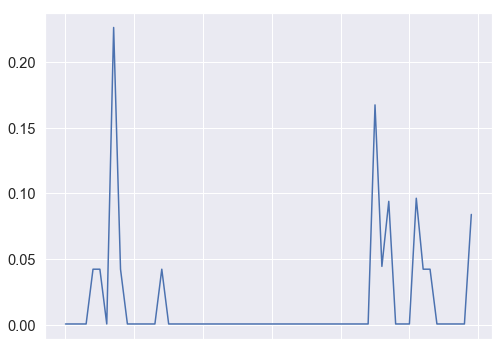

In [277]:
find_topics(0, df_topics_pred=df_topics_pred_2, topic_dict=topic_dict_2)

Cleaned question n°123:
sql partition columns listofcolumnnames   would number rows table according many times given row occured table   tried define table columns follows         select column name cl information schema columns table name    test        would run following query        select     row number       partition cols cl order   select     rn test       second query works nicely manually specify column names partition   otherwise fails   way   motivation behind table without   row duplicates rid   second query inspired answers     question   ms sql       sample           column1   column2   column3                                                         aaaa             bbbb             cccc             dddd             bbbb             aaaa             aaaa                 sample           column1   column2   column3                                                         aaaa             bbbb             cccc             dddd             bbbb             aaaa              

[40, 45, 0, 32]

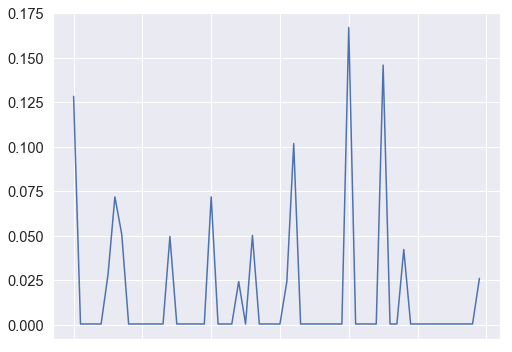

In [278]:
find_topics(123, df_topics_pred=df_topics_pred_2, topic_dict=topic_dict_2)

Cleaned question n°132:
google grpc powershell    m trying build simple grpc client powershell   find information   anybody pointers examples        ve tried loading grpc core dll   however throws         system reflection assembly      loadfile         grpc core dll      gac version location                             v4      users vagrant  nuget packages grpc core    lib netstandard1  grpc core dll       however   ca n t access methods                grpctest     reflection assembly      loadfile        grpc core dll        grpctest   get member  static    

Tags :  <powershell><grpc>

Index(['Topic_46', 'Topic_50', 'Topic_52'], dtype='object')
[46, 50, 52]
Topic 46 : core target master microsoft studio visual cpp x86 sys exe
Topic 50 : doc video rest abc develop author cooki meta publish separ
Topic 52 : charact encod dynam import contact yes dictionari decod utf consum


[46, 50, 52]

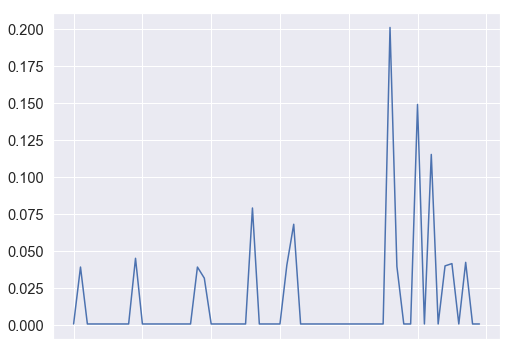

In [279]:
find_topics(132, df_topics_pred=df_topics_pred_2, topic_dict=topic_dict_2)

#### Predict tags

Extract unique train tags : Already done in first optimization

##### Create table linking Tags & Topics :

Method :
- For each documents, and for each tags of the document : 
    - we add to its Tag line, its distribution by topics.
- So, Each tags line contains the sum of all topics distribution

In [280]:
# init dataFrame
df_topics_tags_2 = pd.DataFrame(index=list_unique_tags, columns=topicNames_2, data=0)

df_model_2_topics = df_model_2[df_model_2["Train"] == True].filter(
    items=topicNames_2)

t_0 = time.time()
# for each docs, for each of its tags, add its topics distrib  
for idx in range(0, df_model_2_topics.shape[0]):
    list_tags_curr = re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                           df_model_2[df_model_2["Train"] == True].\
                                iloc[idx].Tags)
    for tag_curr in list_tags_curr:
        if tag_curr in list_unique_tags:
            df_topics_tags_2.loc[tag_curr] += df_model_2_topics.iloc[idx]
        #else:
            #print('Tag {} not into most frequent tags !', tag_curr)

t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))


timing total: 248.20429706573486 s


In [281]:
df_model_2[df_model_2["Train"] == True].shape

(15014, 96)

In [282]:
df_model_2.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Topic_48,Topic_49,Topic_50,Topic_51,Topic_52,Topic_53,Topic_54,Topic_55,Topic_56,Topic_57,Topic_58,Topic_59
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,0.000694,0.000694,0.000694,0.096355,0.042361,0.042361,0.000694,0.000694,0.000694,0.000694,0.000694,0.084028
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,0.000141,0.084805,0.000141,0.000141,0.075068,0.017377,0.000141,0.065309,0.011095,0.000141,0.008843,0.008629
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,0.000170,0.000170,0.041008,0.000170,0.010765,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.085155
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.145238
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,0.001515,0.001515,0.001515,0.092424,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515


In [283]:
df_model_2_topics.shape

(15014, 60)

In [284]:
df_model_2_topics.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_48,Topic_49,Topic_50,Topic_51,Topic_52,Topic_53,Topic_54,Topic_55,Topic_56,Topic_57,Topic_58,Topic_59
3,0.000694,0.000694,0.000694,0.000694,0.042361,0.042361,0.000694,0.226262,0.042361,0.000694,0.000694,0.000694,...,0.000694,0.000694,0.000694,0.096355,0.042361,0.042361,0.000694,0.000694,0.000694,0.000694,0.000694,0.084028
4,0.000141,0.064892,0.000141,0.000141,0.008616,0.000141,0.000141,0.000141,0.000141,0.042961,0.000141,0.008669,...,0.000141,0.084805,0.000141,0.000141,0.075068,0.017377,0.000141,0.065309,0.011095,0.000141,0.008843,0.008629
9,0.011102,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.082766,0.000170,0.053092,0.000170,0.030783,...,0.000170,0.000170,0.041008,0.000170,0.010765,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.085155
12,0.101217,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,...,0.001515,0.001515,0.001515,0.092424,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515,0.001515
13,0.000321,0.020780,0.077811,0.000321,0.000321,0.000321,0.000321,0.000321,0.000321,0.022036,0.000321,0.051071,...,0.040157,0.000321,0.000321,0.000321,0.023828,0.000321,0.000321,0.022427,0.000321,0.000321,0.000321,0.000321


In [285]:
df_topics_tags_2.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,...,Topic_48,Topic_49,Topic_50,Topic_51,Topic_52,Topic_53,Topic_54,Topic_55,Topic_56,Topic_57,Topic_58,Topic_59
.htaccess,0.938592,1.065163,0.286817,0.059124,0.274647,0.315856,0.106155,0.038274,0.274615,0.344096,0.572844,0.632492,...,1.147747,0.287664,0.345582,0.417427,0.546506,0.017458,0.429913,1.394502,0.190679,0.184568,0.310413,0.787838
.lib,0.000185,0.000185,0.033398,0.000185,0.000185,0.012111,0.000185,0.000185,0.361748,0.054605,0.000185,0.000185,...,0.011542,0.000185,0.000185,0.000185,0.000185,0.000185,0.084631,0.061037,0.000185,0.019337,0.000185,0.000185
.net,2.874317,6.553691,3.426816,0.243669,2.709945,3.815503,1.360014,1.638643,2.721558,3.397671,1.564199,1.049943,...,2.658563,2.583097,2.809530,2.280620,3.485674,0.639549,1.023664,8.376150,0.855091,2.445622,2.734933,2.153441
.net-1.1,0.000926,0.000926,0.000926,0.000926,0.072757,0.000926,0.000926,0.000926,0.000926,0.000926,0.000926,0.000926,...,0.000926,0.000926,0.000926,0.000926,0.000926,0.000926,0.000926,0.278704,0.000926,0.000926,0.000926,0.000926
.net-4.5,0.001190,0.001190,0.001190,0.001190,0.001190,0.001190,0.001190,0.001190,0.001190,0.001190,0.001190,0.001190,...,0.001190,0.001190,0.001190,0.001190,0.072619,0.001190,0.001190,0.001190,0.001190,0.001190,0.001190,0.001190


In [286]:
find_tags_from_topic(8, df_topics_tags=df_topics_tags_2)

['python',
 'c++',
 'javascript',
 'java',
 'c#',
 'android',
 'r',
 'php',
 'node.js',
 'ios']

In [287]:
# exemple : Topic 8 : url page link default icon www browser tab website chrome => .htaccess (5.17..)
topic_dict_2[8]

'stream receiv async websit alert await queue azur wait bool'

In [288]:
topic_dict_2[1]

'layout android intent parent tostr wrap fragment textview context toast'

In [289]:
find_tags_from_topic(1, df_topics_tags=df_topics_tags_2)

['python',
 'android',
 'java',
 'javascript',
 'c#',
 'php',
 'html',
 'ios',
 'swift',
 'node.js']

In [290]:
topic_dict_2[2]

'springframework jar spring releas bean boot artifactid groupid annot scope'

In [291]:
find_tags_from_topic(2, df_topics_tags=df_topics_tags_2)

['java',
 'android',
 'spring',
 'javascript',
 'spring-boot',
 'c#',
 'angular',
 'python',
 'html',
 'angularjs']

In [292]:
topic_dict_1[3]

'button click link page action url tab modal open browser'

In [293]:
find_tags_from_topic(3, df_topics_tags=df_topics_tags_2)

['java',
 'python',
 'javascript',
 'html',
 'css',
 'numpy',
 'android',
 'jquery',
 'c#',
 'python-3.x']

##### Find predicted Tags from questions : 
- Find Topics from Questions
- Find Tags from Topics

Example for question n° 0:


Cleaned question n°0:
insert entry table exist   table looks sql server       wordid word                          pen  men  cat       wordid word passed stored procedure   need check stored procedure wordid already exists table   wordid n t exists need execute insert statement    

Tags :  <c#><sql><sql-server>

Index(['Topic_7', 'Topic_45'], dtype='object')
[7, 45]
Topic 7 : android support firebas push notif transform io npm nativ jpg
Topic 45 : train worker sampl job shape layer batch schedul weight conn


['javascript',
 'java',
 'python',
 'php',
 'android',
 'c#',
 'sql',
 'mysql',
 'html',
 'jquery']

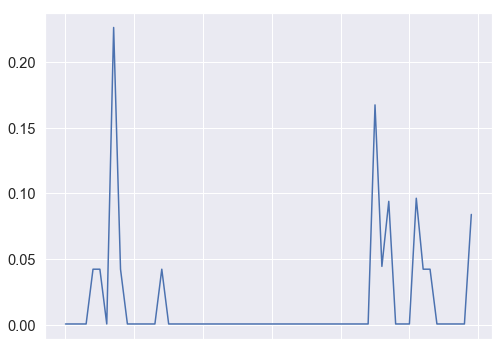

In [294]:
list_topic_id = find_topics(quest_iloc=0, freq_min=0.1, 
                            df_topics_pred=df_topics_pred_2,
                            topic_dict=topic_dict_2)

find_tags_from_topic(iloc_topic=list_topic_id[0], 
                     df_topics_tags=df_topics_tags_2)

Cleaned question n°1:
system dmv  s missing sql server  master dacpac ssdt    ola hallengren  s excellent maintenance solution scripts incorporated dba tools database project   maintained ssdt  target platform sql server    project includes references built in system databases master     msdb   project builds successfully      ola recently   updated   scripts include references sql server  dmv  s   incorporating updated scripts database project generated unresolved reference errors dmv  s         sql71502   procedure     dbo       databasebackup   unresolved reference object   sys       dm os host info   sql71502   procedure     dbo       databasebackup   unresolved reference object   sys       dm db log stats         although n t sql server  installed anywhere   tried updating target platform sql server  deleting recreating master database reference   i e   update master dacpac sql server  version     remove build errors       path referenced dacpac            program files   x86    m

['javascript',
 'java',
 'python',
 'c#',
 'android',
 'c++',
 'html',
 'php',
 'r',
 'eclipse']

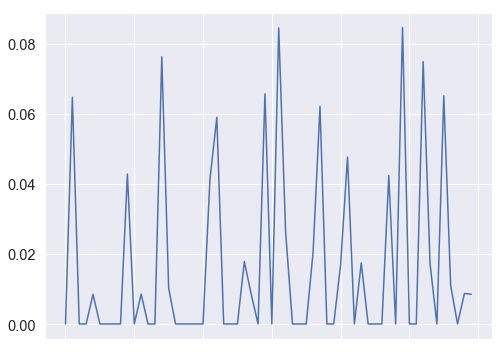

In [295]:
find_pred_tags_from_quest(quest_iloc=1, freq_min=0.08, 
                          df_topics_pred=df_topics_pred_2,
                          topic_dict=topic_dict_2,
                          df_topics_tags=df_topics_tags_2)


Cleaned question n°18:
display properties looping errors   spring bear       trying adjust display properties entity spring boot      form following inside display errors             ul         th   each     e         fields detailederrors          th   class         e global     globalerr   fielderr            span th   text         e global                e fieldname          field      span         span th   text         e message          message      span          li          ul           results following message upon invalid input         saving   please try lastname must empty   firstname size must    lastname size must    firstname must empty         tried adjusting property accommodate display avail           notempty   size   min     max        displayname      last      lastname                 display applicable field    

Tags :  <java><spring><spring-boot>

Index(['Topic_58', 'Topic_57'], dtype='object')
[58, 57]
Topic 58 : num str sum split random len matrix calcul cons

['python',
 'javascript',
 'java',
 'php',
 'node.js',
 'c#',
 'html',
 'r',
 'android',
 'css']

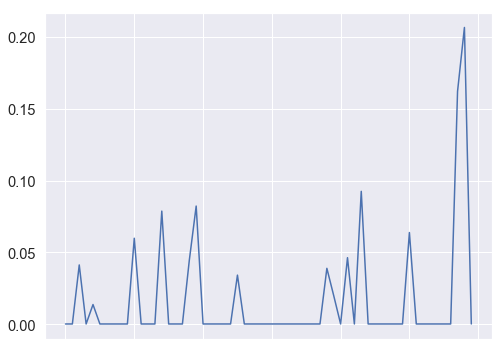

In [296]:
find_pred_tags_from_quest(quest_iloc=18, freq_min=0.1, 
                          df_topics_pred=df_topics_pred_2,
                          topic_dict=topic_dict_2,
                          df_topics_tags=df_topics_tags_2)


Cleaned question n°123:
sql partition columns listofcolumnnames   would number rows table according many times given row occured table   tried define table columns follows         select column name cl information schema columns table name    test        would run following query        select     row number       partition cols cl order   select     rn test       second query works nicely manually specify column names partition   otherwise fails   way   motivation behind table without   row duplicates rid   second query inspired answers     question   ms sql       sample           column1   column2   column3                                                         aaaa             bbbb             cccc             dddd             bbbb             aaaa             aaaa                 sample           column1   column2   column3                                                         aaaa             bbbb             cccc             dddd             bbbb             aaaa              

['python',
 'javascript',
 'sql',
 'java',
 'php',
 'angular',
 'c#',
 'mysql',
 'html',
 'android']

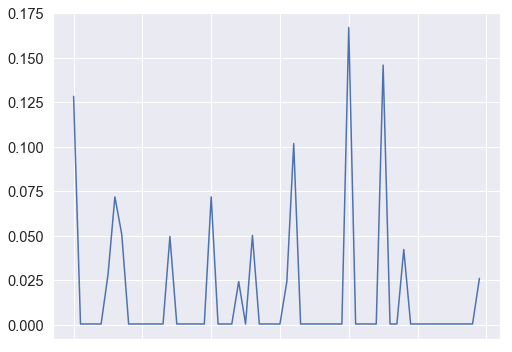

In [297]:
find_pred_tags_from_quest(quest_iloc=123, freq_min=0.1, 
                          df_topics_pred=df_topics_pred_2,
                          topic_dict=topic_dict_2,
                          df_topics_tags=df_topics_tags_2)

##### Predict Tags from question Text :

- Text -> Features
- Features -> TF -> LDA.transfom -> topic ditrib

In [298]:
df_quest_cleaned.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Tag_2,Tag_3,Tag_4,flag_Tag_0,flag_Tag_1,flag_Tag_2,flag_Tag_3,flag_Tag_4,flag_most_Tagged,Text,token_text,Train
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,sql-server,NaN,NaN,True,True,True,False,False,True,How to insert an entry to a table only if it d...,insert entry table exist table looks sql ser...,True
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,NaN,NaN,NaN,True,False,False,False,False,True,System DMV's missing from SQL Server 2017 mast...,system dmv s missing sql server master dacpa...,True
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,ajax,NaN,NaN,True,True,True,False,False,True,how to insert data in databse without page rel...,insert databse without page reload insert ...,True
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,file-upload,multipart,NaN,True,True,False,False,False,True,How to upload image using multipart in Amazon ...,upload multipart amazon s3 upload amazon s3 ...,False
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,crosstab,NaN,NaN,True,False,False,False,False,True,DB2 SQL CROSSTAB <p>I would like to output a t...,db2 sql crosstab would output table transf...,True


In [299]:
# example 1st question
text_test = df_quest_cleaned.iloc[0]["Text"]
print(text_test)
# clean the text
text_cleaned = cleaning_text(text_test)

# calculate feature from text
feat_curr =  tf_vectorizer_2.transform([text_cleaned])

# calculate topic distrib
topic_distrib_pred = best_lda_model_2.transform(feat_curr)

# find best topic
find_tags_from_topic(topic_distrib_pred.argmax(), 
                     df_topics_tags=df_topics_tags_2, 
                     no_max=10)

How to insert an entry to a table only if it does not exist <p>My table looks like this  on sql server</p>

<pre><code>wordId     word      
----------------
1214       pen           
1215       men    
1216       cat  
</code></pre>

<p>WordId and word is being passed with the stored procedure and,I need to check on my stored procedure if the wordId already exists on the table or not, and only if the wordId doesn't exists I need to execute the insert statement.  </p>



['python',
 'javascript',
 'java',
 'c#',
 'html',
 'python-3.x',
 'android',
 'php',
 'swift',
 'jquery']

In [300]:
# example  question
text_test = df_quest_cleaned.iloc[1]["Text"]
print(text_test)
 
find_tags_from_text(text=text_test, tf_vectorizer=tf_vectorizer_2,
                    lda_model = best_lda_model_2,
                    df_topics_tags=df_topics_tags_2,
                    no_max=10)

System DMV's missing from SQL Server 2017 master.dacpac in SSDT 2015 <p>I have Ola Hallengren's excellent Maintenance Solution scripts incorporated in to a DBA tools database project.  This is maintained using SSDT 2015 with a target platform of SQL Server 2012.  The project includes references to the built-in system databases master &amp; msdb.  The project builds successfully.</p>

<p>Ola has recently <a href="https://ola.hallengren.com/versions.html" rel="nofollow noreferrer">updated</a> his scripts and they now include references to new SQL Server 2017 DMV's, so incorporating the updated scripts into my database project generated unresolved reference errors for the new DMV's.  </p>

<pre><code>SQL71502: Procedure: [dbo].[DatabaseBackup] has an unresolved reference to object [sys].[dm_os_host_info]
SQL71502: Procedure: [dbo].[DatabaseBackup] has an unresolved reference to object [sys].[dm_db_log_stats]
</code></pre>

<p>Although I don't have SQL Server 2017 installed anywhere, I tri

['android',
 'javascript',
 'python',
 'java',
 'c#',
 'ios',
 'php',
 'swift',
 'html',
 'c++']

In [301]:
# example  question
text_test = df_quest_cleaned.iloc[18]["Text"]
print(text_test)

# predicted tags
find_tags_from_text(text=text_test, tf_vectorizer=tf_vectorizer_2,
                    lda_model = best_lda_model_2,
                    df_topics_tags=df_topics_tags_2,
                    no_max=10)

Display name of properties when looping through errors <p>I am new to Spring so bear with me!</p>

<p>I am trying to adjust the display name of properties of an entity in Spring boot.</p>

<p>I have a form with the following inside to display all errors:</p>

<pre><code>&lt;ul&gt;
    &lt;li th:each="e : ${#fields.detailedErrors()}" th:class="${e.global}? globalerr : fielderr"&gt;
        &lt;span th:text="${e.global}? '*' : ${e.fieldName}"&gt;The field name&lt;/span&gt;
        &lt;span th:text="${e.message}"&gt;The error message&lt;/span&gt;
    &lt;/li&gt;
&lt;/ul&gt;
</code></pre>

<p>That results in the following message upon invalid input:</p>

<blockquote>
  <p>Error Saving New User - Please Try Again
  lastName must not be empty <br>
  firstName size must be between 1 and 30<br>
  lastName size must be between 1 and 30<br>
  firstName must not be empty<br></p>
</blockquote>

<p>I have tried adjusting the property to accommodate a display name to no avail:</p>

<pre><code>@NotEm

['javascript',
 'python',
 'java',
 'c#',
 'html',
 'php',
 'android',
 'angular',
 'regex',
 'css']

In [308]:
# example  question
text_test = df_quest_cleaned.iloc[123]["Text"]
print(text_test)
print("Tags : ", df_quest_cleaned.iloc[123]["Tags"])
# predicted tags
find_tags_from_text(text=text_test, tf_vectorizer=tf_vectorizer_2,
                    lda_model = best_lda_model_2,
                    df_topics_tags=df_topics_tags_2,
                    no_max=10)


SQL Partition by columns IN listOfColumnNames <p>I would like to number all rows of my table according to how many times a given row has occured in the table. I tried to define a table of my columns as follows:</p>

<pre><code>select COLUMN_NAME as cl from information_schema.columns where table_name = 'TEST'
</code></pre>

<p>Then I would like to run the following query.</p>

<pre><code>SELECT *,
ROW_NUMBER() OVER(PARTITION BY Cols IN cl ORDER BY (SELECT 0)) AS rn
FROM TEST 
</code></pre>

<p>The second query works nicely if I manually specify the column names for partition. But otherwise it fails. Is there a way of doing this? 
The motivation behind all this is that I have a table without an ID, where there can be row duplicates which I want to get rid of. 
The second query is inspired by answers to <a href="https://stackoverflow.com/questions/18932/how-can-i-remove-duplicate-rows">this</a> question.
I use MS SQL 2008.</p>

<p>Sample data before:</p>

<pre><code>| Column1 | Column2 | 

['javascript',
 'python',
 'java',
 'angular',
 'reactjs',
 'android',
 'c#',
 'php',
 'node.js',
 'html']

#### Evaluation
Method : Check if real Tags are into the 5 or 10 first predicted Tags

In [365]:


nb_tags_eval_max = 10

t_0 = time.time()

df_model_2["score_lda_2"] = 0

list_scores = []
for idx in range(0, df_model_2.shape[0]):
    
    # predicted tags
    text_test = df_model_2.iloc[idx]["Text"]
    tags_pred = find_tags_from_text(text=text_test, 
                                    tf_vectorizer=tf_vectorizer_2,
                                    lda_model = best_lda_model_2, 
                                    df_topics_tags=df_topics_tags_2,
                                    no_max=nb_tags_eval_max)
    
    tags_real = re.findall(r'(?<=\<)[^\<\>]+(?=\>)', 
                           df_model_2.iloc[idx]["Tags"])
    #print("")
    #print(tags_pred)
    #print(tags_real)
    #print(score_eval_tags(tags_real,tags_pred))
    list_scores.append(score_eval_tags(tags_real, tags_pred))

t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))

df_model_2["score_lda_2"] = list_scores  

timing total: 350.26113986968994 s


In [366]:
df_model_2["score_lda_2"].value_counts()

0.000000    8098
0.333333    2771
0.500000    2706
0.250000    1912
0.200000    1369
1.000000     982
0.666667     427
0.400000     344
0.600000      84
0.750000      70
0.800000       5
Name: score_lda_2, dtype: int64

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


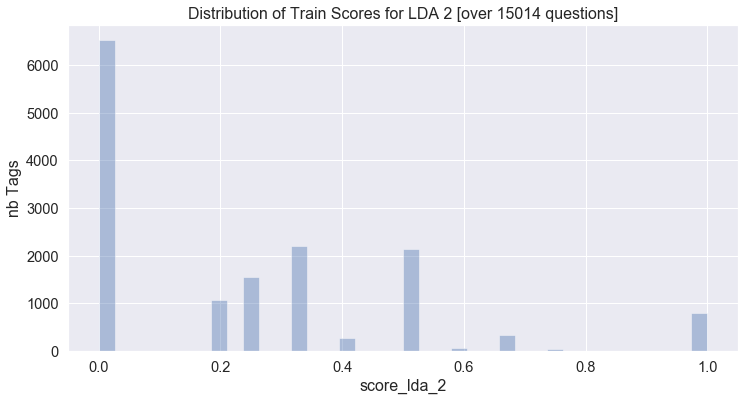

In [367]:
fig = plt.figure(figsize=(12, 6))
plt.title("Distribution of Train Scores for LDA 2 [over {} questions]".format(
    df_model_2[df_model_2.Train == True].shape[0]))
ax = sns.distplot(df_model_2[df_model_2.Train == True]["score_lda_2"], 
                  kde=False)
ax.set_ylabel('nb Tags');

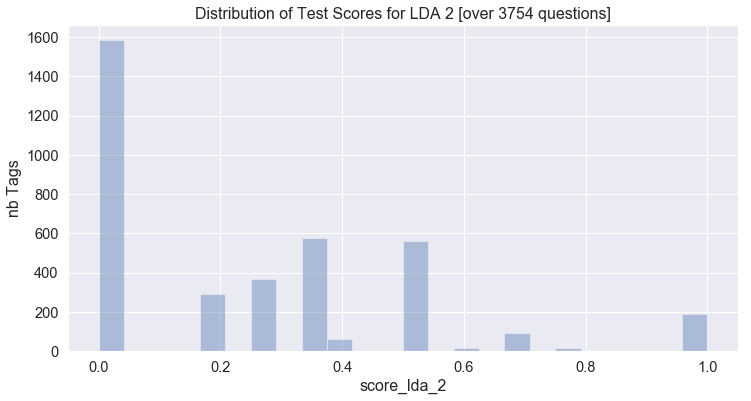

In [368]:
fig = plt.figure(figsize=(12, 6))
plt.title("Distribution of Test Scores for LDA 2 [over {} questions]".format(
    df_model_2[df_model_2.Train == False].shape[0]))
ax = sns.distplot(df_model_2[df_model_1.Train == False]["score_lda_2"], 
                  kde=False)
ax.set_ylabel('nb Tags');

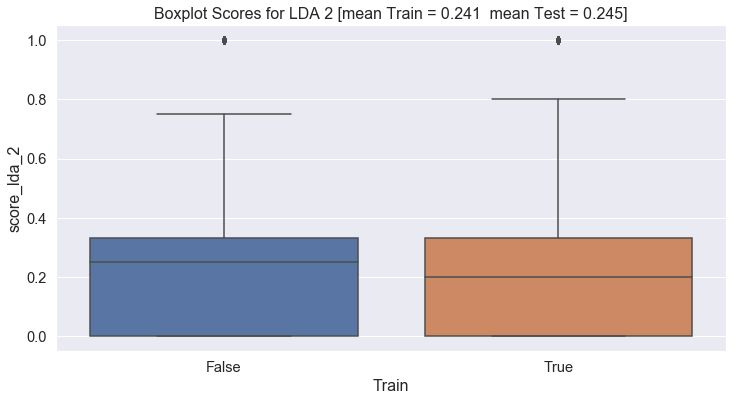

In [369]:
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplot Scores for LDA 2 [mean Train = {:.3f}  mean Test = {:.3f}]".\
          format(df_model_2[df_model_2.Train == True]["score_lda_2"].mean(),
                df_model_2[df_model_2.Train == False]["score_lda_2"].mean()))
ax = sns.boxplot(y="score_lda_2", x='Train', data=df_model_2)


##### At least one Tag ok

In [370]:
df_model_2["score_OK_lda_2"] = df_model_2["score_lda_2"] > 0

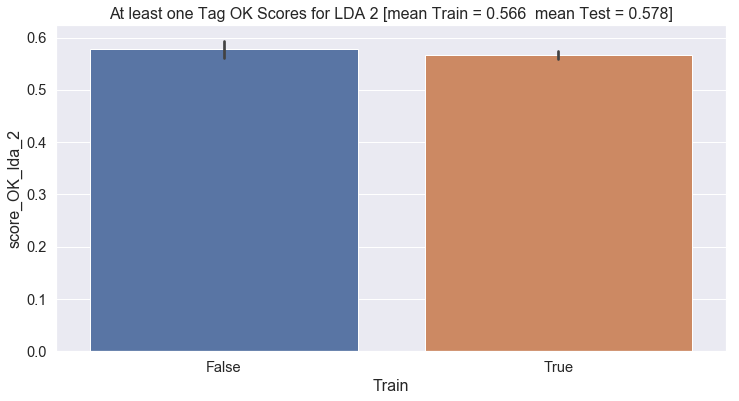

In [371]:
fig = plt.figure(figsize=(12, 6))
plt.title("At least one Tag OK Scores for LDA 2 [mean Train = {:.3f}  mean Test = {:.3f}]".\
          format(df_model_2[df_model_2.Train == True]["score_OK_lda_2"].mean(),
                df_model_2[df_model_2.Train == False]["score_OK_lda_2"].mean()))
ax = sns.barplot(y="score_OK_lda_2", x='Train', data=df_model_2)
#ax = sns.barplot(x="day", y="total_bill", data=tips)

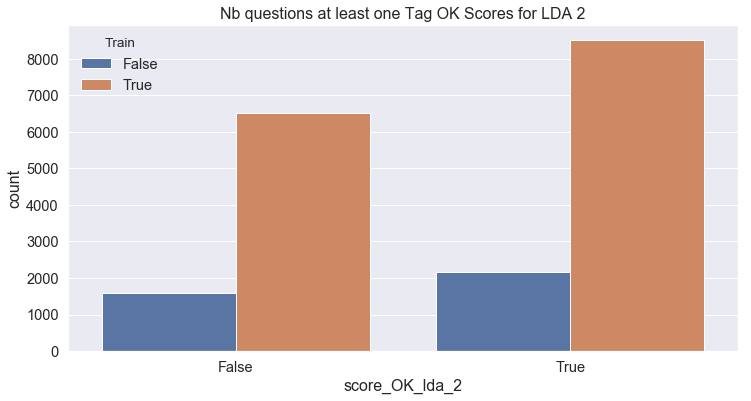

In [372]:
fig = plt.figure(figsize=(12, 6))
plt.title("Nb questions at least one Tag OK Scores for LDA 2")
ax = sns.countplot(x="score_OK_lda_2", hue="Train", data=df_model_2)

## Models Supervised

### Extract n-th first tags from data

In [314]:
df_mdl_sup_1 = df_quest_cleaned.copy()
df_mdl_sup_1["Tag_0"] = df_mdl_sup_1.Tags.apply(apply_extract_tag)
df_mdl_sup_1["Tag_1"] = df_mdl_sup_1.Tags.apply(apply_extract_tag, args=(1,))
df_mdl_sup_1["Tag_2"] = df_mdl_sup_1.Tags.apply(apply_extract_tag, args=(2,))
df_mdl_sup_1["Tag_3"] = df_mdl_sup_1.Tags.apply(apply_extract_tag, args=(3,))
df_mdl_sup_1["Tag_4"] = df_mdl_sup_1.Tags.apply(apply_extract_tag, args=(4,))

df_mdl_sup_1.head()

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Tag_2,Tag_3,Tag_4,flag_Tag_0,flag_Tag_1,flag_Tag_2,flag_Tag_3,flag_Tag_4,flag_most_Tagged,Text,token_text,Train
3,50000005,1,50000164.0,NaN,2018-04-24 11:00:01,NaN,-4,63.0,<p>My table looks like this on sql server</p>...,8217447.0,NaN,3876565.0,...,sql-server,NaN,NaN,True,True,True,False,False,True,How to insert an entry to a table only if it d...,insert entry table exist table looks sql ser...,True
4,50000006,1,50117317.0,NaN,2018-04-24 11:00:01,NaN,0,199.0,<p>I have Ola Hallengren's excellent Maintenan...,9690333.0,NaN,NaN,...,NaN,NaN,NaN,True,False,False,False,False,True,System DMV's missing from SQL Server 2017 mast...,system dmv s missing sql server master dacpa...,True
9,50000012,1,NaN,NaN,2018-04-24 11:00:25,NaN,-3,37.0,<p>i want to insert data without page reload.\...,9690673.0,NaN,9690673.0,...,ajax,NaN,NaN,True,True,True,False,False,True,how to insert data in databse without page rel...,insert databse without page reload insert ...,False
10,50000013,1,NaN,NaN,2018-04-24 11:00:27,NaN,-1,42.0,<p>How to upload file in amazon s3 without cre...,5821228.0,NaN,NaN,...,file-upload,multipart,NaN,True,False,False,False,False,True,How to upload image using multipart in Amazon ...,upload multipart amazon s3 upload amazon s3 ...,False
12,50000015,1,50000099.0,NaN,2018-04-24 11:00:31,NaN,1,133.0,"<p>I would like to output a table, transformed...",1570450.0,NaN,NaN,...,crosstab,NaN,NaN,True,False,False,False,False,True,DB2 SQL CROSSTAB <p>I would like to output a t...,db2 sql crosstab would output table transf...,True


### Extracting features from text files

#### Clean text

already done

#### Tokenizing text with scikit-learn

already done

#### TF occurrences

In [315]:
# init features
tf_vectorizer_sup_1 = CountVectorizer(max_df=0.11, min_df=10, max_features=1000,
                                      tokenizer=myTokenizer)

# train counts
tf_1 = tf_vectorizer_sup_1.\
    fit_transform(df_quest_cleaned[\
                                   df_quest_cleaned.Train\
                                   == True]["token_text"])

X_train_counts_sup_1 = tf_1
X_train_counts_sup_1.shape

(14195, 1000)

In [316]:
# test counts
X_test_counts_sup_1 = tf_vectorizer_sup_1.transform(
    df_mdl_sup_1[df_mdl_sup_1.Train == False]["token_text"])
X_test_counts_sup_1.shape

(3549, 1000)

#### From occurrences to frequencies

In [317]:
# calculate tf-idf
tfidf_transformer_sup_1 = TfidfTransformer().fit(X_train_counts_sup_1)

In [318]:
# train
X_train_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_train_counts_sup_1)
X_train_tfidf_sup_1.shape

(14195, 1000)

In [319]:
# test
X_test_tfidf_sup_1 = tfidf_transformer_sup_1.transform(X_test_counts_sup_1)
X_test_tfidf_sup_1.shape

(3549, 1000)

In [320]:
print("Nb unique tags in Train: ", df_mdl_sup_1[df_mdl_sup_1.Train == True].\
      Tag_0.nunique())

Nb unique tags in Train:  161


In [321]:
print("Nb unique tags in Test: ", df_mdl_sup_1[df_mdl_sup_1.Train == False].\
      Tag_0.nunique())

Nb unique tags in Test:  114


### Dummy classifier 1st Tag

In [322]:
clf_dummy = DummyClassifier(strategy='stratified', random_state=0)
clf_dummy.fit(X_train_tfidf_sup_1, 
              df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0)
print("Train Score : ",
      clf_dummy.score(X_train_tfidf_sup_1, 
                      df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0))
print("Test Score : ",
      clf_dummy.score(X_test_tfidf_sup_1, 
                      df_mdl_sup_1[df_mdl_sup_1.Train == False].Tag_0))

Train Score :  0.0562874251497006
Test Score :  0.060016906170752324


In [323]:
predicted_train = clf_dummy.predict(X_train_tfidf_sup_1)
predicted_test  = clf_dummy.predict(X_test_tfidf_sup_1)

In [324]:
df_mdl_sup_1.loc[df_mdl_sup_1.Train == True ,"Tag_0_dummy_1"] = predicted_train
df_mdl_sup_1.loc[df_mdl_sup_1.Train == False ,"Tag_0_dummy_1"] = predicted_test
df_mdl_sup_1.filter(items=["token_text",'Tags',"Tag_0_dummy_1"]).head()

,token_text,Tags,Tag_0_dummy_1
3,insert entry table exist table looks sql ser...,<c#><sql><sql-server>,ios
4,system dmv s missing sql server master dacpa...,<sql-server><sql-server-data-tools>,javascript
9,insert databse without page reload insert ...,<javascript><php><ajax>,ios
10,upload multipart amazon s3 upload amazon s3 ...,<android><amazon-s3><file-upload><multipart>,javascript
12,db2 sql crosstab would output table transf...,<sql><db2><crosstab>,python


### MultinomialNB classifier 1st Tag

In [325]:
clf_mnb_1 = MultinomialNB().fit(X_train_tfidf_sup_1, 
                              df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0)

In [326]:
print("Train Score : ",
      clf_mnb_1.score(X_train_tfidf_sup_1, 
                      df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0))
print("Test Score : ",
      clf_mnb_1.score(X_test_tfidf_sup_1, 
                      df_mdl_sup_1[df_mdl_sup_1.Train == False].Tag_0))

Train Score :  0.5150405072208524
Test Score :  0.46689208227669765


In [327]:
predicted_train = clf_mnb_1.predict(X_train_tfidf_sup_1)
predicted_test  = clf_mnb_1.predict(X_test_tfidf_sup_1)

In [328]:
df_mdl_sup_1.loc[df_mdl_sup_1.Train == True ,"Tag_0_mnb_1"] = predicted_train
df_mdl_sup_1.loc[df_mdl_sup_1.Train == False ,"Tag_0_mnb_1"] = predicted_test
df_mdl_sup_1.filter(items=["token_text",'Tags',"Tag_0_mnb_1"]).head()

,token_text,Tags,Tag_0_mnb_1
3,insert entry table exist table looks sql ser...,<c#><sql><sql-server>,sql
4,system dmv s missing sql server master dacpa...,<sql-server><sql-server-data-tools>,c#
9,insert databse without page reload insert ...,<javascript><php><ajax>,javascript
10,upload multipart amazon s3 upload amazon s3 ...,<android><amazon-s3><file-upload><multipart>,javascript
12,db2 sql crosstab would output table transf...,<sql><db2><crosstab>,sql


### SGDClassifier 

#### 1st Tag : Tag_0

In [690]:
print("For Tag_0:")
print('- Nb Tags in Test but not in Train :',
      len(set(list(df_mdl_sup_1[df_mdl_sup_1["Train"] == False]["Tag_0"].\
                 unique())).\
        difference(set(list(df_mdl_sup_1[df_mdl_sup_1["Train"] == True]\
                            ["Tag_0"].unique())))))

For Tag_0:
- Nb Tags in Test but not in Train : 19


In [597]:
# list of tags in Test set but not in Train set :
list_tags_test_no_train = set(list(df_mdl_sup_1[df_mdl_sup_1["Train"] \
        == False]["Tag_0"].unique())).\
        difference(set(list(df_mdl_sup_1[df_mdl_sup_1["Train"] == True]\
                            ["Tag_0"].unique())))
# creation of dataframe with these special tags
df_count = pd.DataFrame(data=list(list_tags_test_no_train), columns=["Tag_0"])
# add columns of count of every special tags into Test:
df_count["nb_tags"] = 0
def apply_fun_nb(tag_curr):
    return df_mdl_sup_1[(df_mdl_sup_1["Train"] == False) & \
                 (df_mdl_sup_1["Tag_0"] == tag_curr)].shape[0]
df_count["nb_tags"] = df_count["Tag_0"].apply(apply_fun_nb)
df_count

,Tag_0,nb_tags
0,jsp,1
1,intellij-idea,1
2,generics,1
3,twitter-bootstrap-3,1
4,asynchronous,1
5,pagination,1
6,iphone,1


Text(0, 0.5, 'nb Tags 1 [-]')

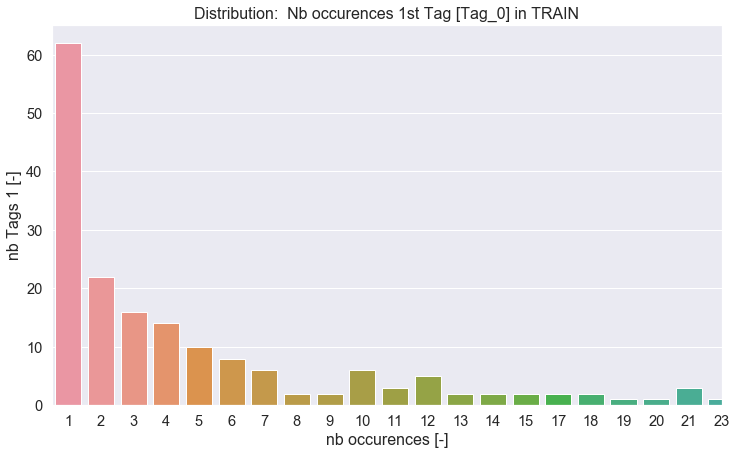

In [725]:
fig = plt.figure(figsize=(12, 7))
plt.title("Distribution:  Nb occurences 1st Tag [Tag_0] in TRAIN")
ax = sns.countplot(df_mdl_sup_1[df_mdl_sup_1["Train"] == False]
                  ["Tag_0"].value_counts())
ax.set_xlim(right=20)
ax.set_xlabel("nb occurences [-]")
ax.set_ylabel("nb Tags 1 [-]")

Text(0, 0.5, 'nb Tags 1 [-]')

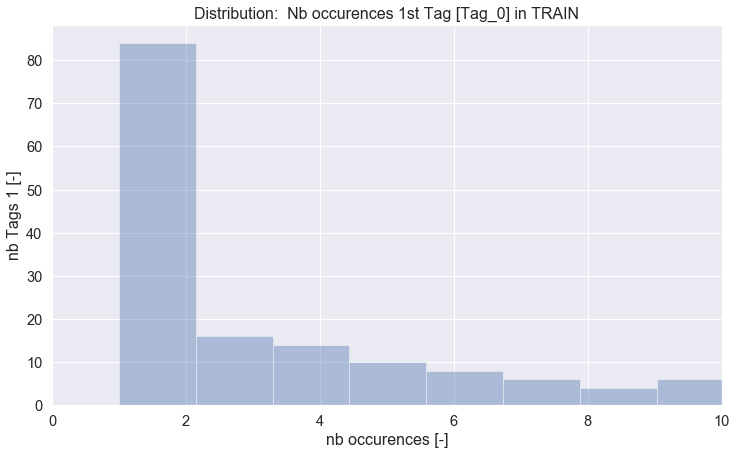

In [715]:
fig = plt.figure(figsize=(12, 7))
plt.title("Distribution:  Nb occurences 1st Tag [Tag_0] in TRAIN")
ax = sns.distplot(df_mdl_sup_1[df_mdl_sup_1["Train"] == False]
                  ["Tag_0"].value_counts(), bins=400, kde=False)
ax.set_xlim([0, 10])
ax.set_xlabel("nb occurences [-]")
ax.set_ylabel("nb Tags 1 [-]")

Text(0.5, 0, 'count of 1st Tag  [-]')

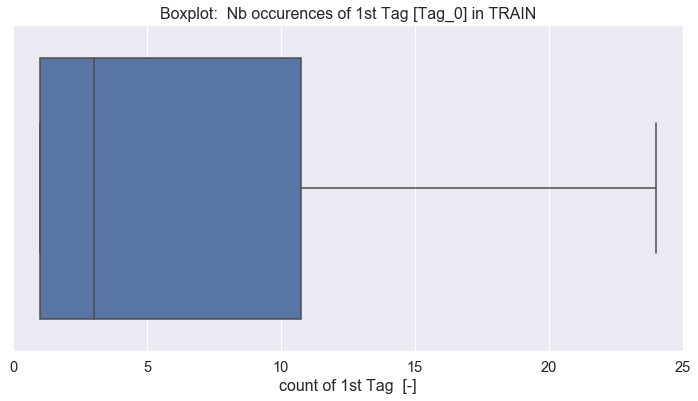

In [701]:
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplot:  Nb occurences of 1st Tag [Tag_0] in TRAIN")
ax = sns.boxplot(df_mdl_sup_1[df_mdl_sup_1["Train"]
                              == False]["Tag_0"].value_counts())
ax.set_xlim([0, 25])
ax.set_xlabel("count of 1st Tag  [-]")

Text(0, 0.5, 'nb Tags 1 [-]')

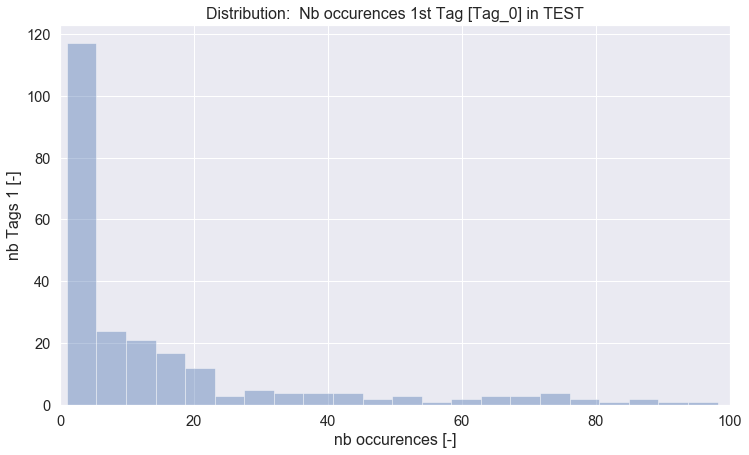

In [704]:
fig = plt.figure(figsize=(12, 7))
plt.title("Distribution:  Nb occurences 1st Tag [Tag_0] in TEST")
ax = sns.distplot(df_mdl_sup_1[df_mdl_sup_1["Train"] == True]
                  ["Tag_0"].value_counts(), bins=400, kde=False)
ax.set_xlim([0, 100])
ax.set_xlabel("nb occurences [-]")
ax.set_ylabel("nb Tags 1 [-]")

Text(0.5, 0, 'count of 1st Tag  [-]')

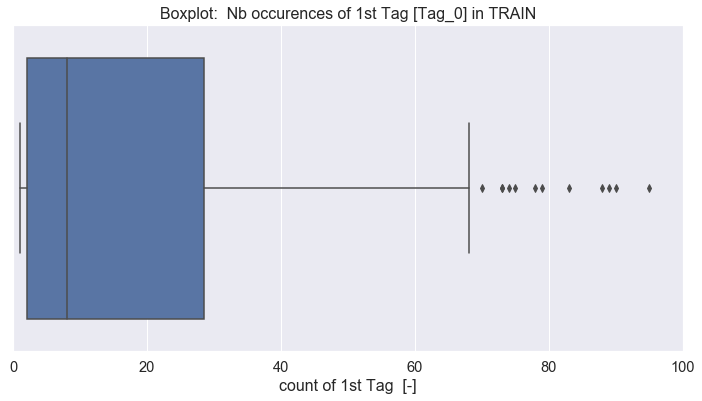

In [707]:
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplot:  Nb occurences of 1st Tag [Tag_0] in TRAIN")
ax = sns.boxplot(df_mdl_sup_1[df_mdl_sup_1["Train"]
                              == True]["Tag_0"].value_counts())
ax.set_xlim([0, 100])
ax.set_xlabel("count of 1st Tag  [-]")

In [616]:
df_mdl_sup_1.Tag_0.nunique()

279

In [518]:
clf_sgc_1 = SGDClassifier(loss='hinge', penalty='l2',
                        alpha=1e-3, random_state=0,
                        max_iter=5, tol=None)

clf_sgc_1.fit(X_train_tfidf_sup_1, 
              df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [519]:
print("Train Score : ",
      clf_sgc_1.score(X_train_tfidf_sup_1, 
                      df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0))
print("Test Score : ",
      clf_sgc_1.score(X_test_tfidf_sup_1, 
                      df_mdl_sup_1[df_mdl_sup_1.Train == False].Tag_0))

Train Score :  0.6654455794293765
Test Score :  0.5359256128486898


In [520]:
predicted_train = clf_sgc_1.predict(X_train_tfidf_sup_1) 
predicted_test = clf_sgc_1.predict(X_test_tfidf_sup_1)

In [521]:
find_nb_no_uniquetag(predicted_train)
find_nb_no_uniquetag(predicted_test)

Nb. no Tags samples : 0 over 14195 rows [0.00%]
Nb. no Tags samples : 0 over 3549 rows [0.00%]


0

In [522]:
precision_score(df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0, predicted_train, average='micro')

0.6654455794293765

In [526]:
recall_score(df_mdl_sup_1[df_mdl_sup_1.Train == True].Tag_0, predicted_train,
                average='micro')

0.6654455794293765

In [523]:
precision_score(df_mdl_sup_1[df_mdl_sup_1.Train == False].Tag_0, predicted_test, average='micro')

0.5359256128486898

In [514]:
predicted_train

array(['sql', 'sql-server', 'javascript', ..., 'javascript', 'python',
       'vb.net'], dtype='<U21')

In [517]:
df_mdl_sup_1.loc[df_mdl_sup_1.Train == True ,"Tag_0_sgc_1"] = predicted_train
df_mdl_sup_1.loc[df_mdl_sup_1.Train == False ,"Tag_0_sgc_1"] = predicted_test
df_mdl_sup_1.filter(items=["token_text",'Tags',"Tag_0_sgc_1"]).head()

,token_text,Tags,Tag_0_sgc_1
3,insert entry table exist table looks sql ser...,<c#><sql><sql-server>,sql
4,system dmv s missing sql server master dacpa...,<sql-server><sql-server-data-tools>,sql-server
9,insert databse without page reload insert ...,<javascript><php><ajax>,javascript
10,upload multipart amazon s3 upload amazon s3 ...,<android><amazon-s3><file-upload><multipart>,ios
12,db2 sql crosstab would output table transf...,<sql><db2><crosstab>,sql


In [518]:
df_mdl_sup_1[df_mdl_sup_1["Tag_0_sgc_1"].isna()]

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,OwnerDisplayName,LastEditorUserId,...,Tag_4,flag_Tag_0,flag_Tag_1,flag_Tag_2,flag_Tag_3,flag_Tag_4,flag_most_Tagged,Text,token_text,Train,Tag_0_dummy_1,Tag_0_sgc_1


#### 2nd Tag : Tag_1

In [687]:
print("For Tag_1:")
print('- Nb Tags in Test but not in Train :',
      len(set(list(df_mdl_sup_1[df_mdl_sup_1["Train"] == False]["Tag_1"].\
                 unique())).\
        difference(set(list(df_mdl_sup_1[df_mdl_sup_1["Train"] == True]\
                            ["Tag_1"].unique())))))

For Tag_1:
- Nb Tags in Test but not in Train : 309


##### 2nd Tag  : Train part

In [657]:
df_train = df_mdl_sup_1[df_mdl_sup_1.Train == True].filter(items=["Tag_1"])
df_train = df_train.reset_index()
print(df_train.shape)
df_train.head()

(15014, 2)


,index,Tag_1
0,3,sql
1,4,sql-server-data-tools
2,9,php
3,12,db2
4,13,laravel


In [658]:
df_train = df_train[df_train["Tag_1"].notna()]
df_train.head() 

,index,Tag_1
0,3,sql
1,4,sql-server-data-tools
2,9,php
3,12,db2
4,13,laravel


In [659]:
df_train.shape

(13644, 2)

In [660]:
list_idx_xtrain = df_train.index.tolist()
print(list_idx_xtrain[:10])
print("...")
print(list_idx_xtrain[-10:])

[0, 1, 2, 3, 4, 5, 6, 7, 9, 10]
...
[15002, 15003, 15004, 15005, 15007, 15009, 15010, 15011, 15012, 15013]


In [661]:
X_train_tfidf_sup_1.shape

(15014, 1000)

In [662]:
len(list_idx_xtrain)

13644

In [671]:
X_train_tfidf_sup_tag_1 = X_train_tfidf_sup_1[list_idx_xtrain,:]
X_train_tfidf_sup_tag_1.shape

(13644, 1000)

##### 2nd Tag:  Test part

In [664]:
df_test = df_mdl_sup_1[df_mdl_sup_1.Train == False].filter(items=["Tag_1"])
df_test = df_test.reset_index()
print(df_test.shape)
df_test.head()

(3754, 2)


,index,Tag_1
0,10,amazon-s3
1,21,objective-c
2,31,swift
3,54,qt
4,75,wordpress


In [665]:
df_test = df_test[df_test["Tag_1"].notna()]
df_test.head() 

,index,Tag_1
0,10,amazon-s3
1,21,objective-c
2,31,swift
3,54,qt
4,75,wordpress


In [666]:
df_test.shape

(3417, 2)

In [667]:
list_idx_xtest = df_test.index.tolist()
print(list_idx_xtest[:10])
print("...")
print(list_idx_xtest[-10:])

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10]
...
[3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752, 3753]


In [668]:
X_test_tfidf_sup_1.shape

(3754, 1000)

In [669]:
len(list_idx_xtest)

3417

In [670]:
X_test_tfidf_sup_tag_1 = X_test_tfidf_sup_1[list_idx_xtest,:]
X_test_tfidf_sup_tag_1.shape

(3417, 1000)

##### Fitting

In [674]:
clf_sgc_2 = SGDClassifier(loss='hinge', penalty='l2',
                        alpha=1e-3, random_state=0,
                        max_iter=5, tol=None)

clf_sgc_2.fit(X_train_tfidf_sup_tag_1, df_train["Tag_1"])

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

##### Scores

In [675]:
print("Train Score : ",
      clf_sgc_2.score(X_train_tfidf_sup_tag_1, df_train["Tag_1"]))
print("Test Score : ",
      clf_sgc_2.score(X_test_tfidf_sup_tag_1, df_test["Tag_1"]))

Train Score :  0.8054089709762533
Test Score :  0.2221246707638279


In [676]:
df_train["Tag_1"].nunique()

2437

In [677]:
df_train.shape

(13644, 2)

Text(0.5, 0, 'count of 2nd Tag  [-]')

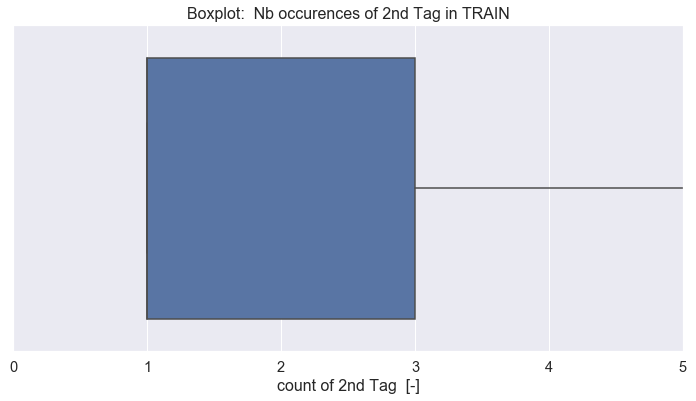

In [688]:
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplot:  Nb occurences of 2nd Tag in TRAIN")
ax = sns.boxplot(df_train["Tag_1"].value_counts())
ax.set_xlim([0,5])
ax.set_xlabel("count of 2nd Tag  [-]")

Text(0, 0.5, 'nb Tags 1 [-]')

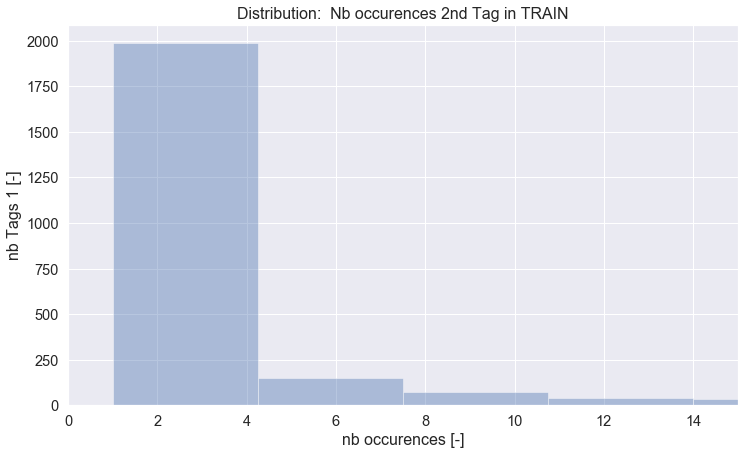

In [689]:
fig = plt.figure(figsize=(12, 7))
plt.title("Distribution:  Nb occurences 2nd Tag in TRAIN")
ax = sns.distplot(df_train["Tag_1"].value_counts(), bins=100, kde=False)
ax.set_xlim([0,15])
ax.set_xlabel("nb occurences [-]")
ax.set_ylabel("nb Tags 1 [-]")

###  RandomForest Multi-tags

In [329]:
 df_mdl_sup_1.Tag_0.count() / df_mdl_sup_1.shape[0]

1.0

In [330]:
 df_mdl_sup_1.Tag_1.count() / df_mdl_sup_1.shape[0]

0.9149008115419297

In [331]:
 df_mdl_sup_1.Tag_2.count() / df_mdl_sup_1.shape[0]

0.6598286744815148

In [332]:
 df_mdl_sup_1.Tag_3.count() / df_mdl_sup_1.shape[0]

0.3593327321911632

In [333]:
 df_mdl_sup_1.Tag_4.count() / df_mdl_sup_1.shape[0]

0.1486136158701533

#### Multi-label encoding

In [334]:
df_mdl_sup_1.filter(items=["Tag_0","Tag_1","Tag_2","Tag_3", "Tag_4"]).head()

,Tag_0,Tag_1,Tag_2,Tag_3,Tag_4
3,c#,sql,sql-server,NaN,NaN
4,sql-server,sql-server-data-tools,NaN,NaN,NaN
9,javascript,php,ajax,NaN,NaN
10,android,amazon-s3,file-upload,multipart,NaN
12,sql,db2,crosstab,NaN,NaN


##### For output to predict, extract only most used Tags

In [563]:
# create list of list of Tags to be able to encode multi label outputs
print('\nFor train set...')  
list_list_tags_train = \
    create_tags_list_of_list(df_mdl_sup_1[df_mdl_sup_1.Train == True]["Tags"],
                            list_tags_most_used=list_tags_most_used)
print(list_list_tags_train[:10])

print('\nFor test set...')  
list_list_tags_test = \
    create_tags_list_of_list(df_mdl_sup_1[df_mdl_sup_1.Train == False]["Tags"],
                            list_tags_most_used=list_tags_most_used)
print(list_list_tags_test[:10])


For train set...
[['c#', 'sql', 'sql-server'], ['sql-server'], ['sql'], ['php', 'laravel'], ['python'], ['java'], ['javascript', 'json', 'reactjs'], ['android'], ['javascript', 'arrays', 'typescript', 'angular5'], ['apache-spark']]

For test set...
[['javascript', 'php', 'ajax'], ['android'], ['ios'], ['ios', 'swift'], ['c++'], ['excel', 'vba', 'excel-vba'], ['sql-server'], ['asp.net', 'windows'], ['ruby-on-rails'], ['c#']]


##### Encoding output to predict

In [564]:
#y = [['tag3','tag1'],['tag1','tag0','tag2']]
mlb = MultiLabelBinarizer()
encoded_y_train = mlb.fit_transform(list_list_tags_train)
encoded_y_test = mlb.transform(list_list_tags_test)

In [565]:
encoded_y_train.shape

(14195, 100)

In [566]:
encoded_y_test.shape

(3549, 100)

##### Check if enough sample for each most used Tags (important for Training) :

In [341]:
#for idx in range(0, encoded_y_train.shape[1]):
print('For less used tag:')
print("- For train: ")
nb_used_tags_train = np.sum(encoded_y_train, axis=0)
print("  - Number of use: ", np.min(nb_used_tags_train))
print("\n- For test : ")
nb_used_tags_test = np.sum(encoded_y_test, axis=0)
print("  - Number of use: ", np.min(nb_used_tags_test))

For less used tag:
- For train: 
  - Number of use:  57

- For test : 
  - Number of use:  10


In [342]:
# for idx in range(0, encoded_y_train.shape[1]):
print('For each sample:')
print("- For train: ")
nb_tags_per_sample_train = np.sum(encoded_y_train, axis=1)
print("  - Minimum Number of Tags: ", np.min(nb_tags_per_sample_train))
print("\n- For test : ")
nb_tags_per_sample_test = np.sum(encoded_y_test, axis=1)
print("  - Minimum Number of Tags: ", np.min(nb_tags_per_sample_test))

For each sample:
- For train: 
  - Minimum Number of Tags:  1

- For test : 
  - Minimum Number of Tags:  1


In [464]:
df_mdl_sup_1[df_mdl_sup_1.Train == False].iloc[8]["Tags"]

'<ruby-on-rails><heroku><webpack><webpacker>'

In [344]:
mlb.classes_

array(['.net', 'ajax', 'amazon-web-services', 'android', 'android-studio',
       'angular', 'angular5', 'angularjs', 'apache-spark', 'api',
       'arrays', 'asp.net', 'asp.net-core', 'asp.net-mvc', 'azure',
       'bash', 'bootstrap-4', 'c', 'c#', 'c++', 'css', 'css3', 'database',
       'dataframe', 'django', 'docker', 'elasticsearch', 'excel',
       'excel-vba', 'express', 'firebase', 'firebase-realtime-database',
       'function', 'ggplot2', 'git', 'go', 'gradle', 'hibernate', 'html',
       'html5', 'image', 'ionic-framework', 'ios', 'java', 'javascript',
       'jenkins', 'jquery', 'json', 'keras', 'kotlin', 'laravel', 'linux',
       'list', 'loops', 'matlab', 'maven', 'mongodb', 'multithreading',
       'mysql', 'node.js', 'numpy', 'oracle', 'pandas', 'php',
       'postgresql', 'powershell', 'python', 'python-2.7', 'python-3.x',
       'r', 'react-native', 'reactjs', 'regex', 'rest', 'ruby',
       'ruby-on-rails', 'scala', 'selenium', 'shell', 'spring',
       'spring-boot

#### Distribution of Tags

(0, 250)

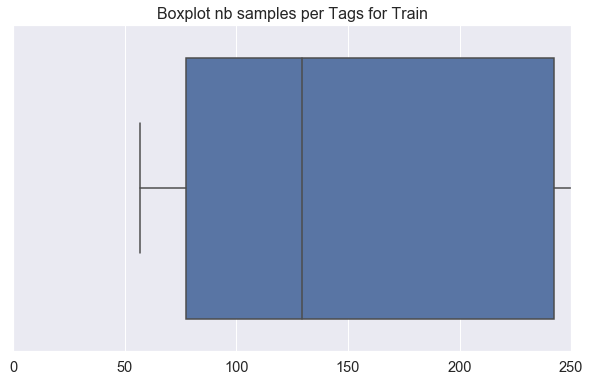

In [345]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb samples per Tags for Train")
ax = sns.boxplot(encoded_y_train.sum(axis=0))
ax.set_xlim([0,250])

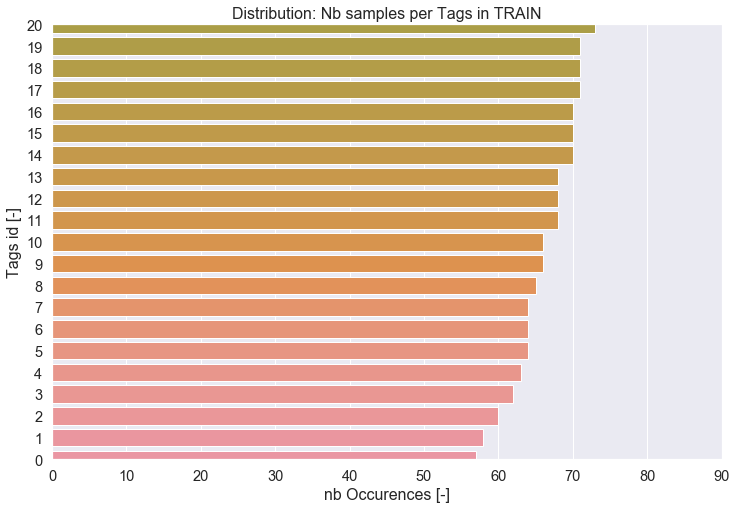

In [349]:
fig = plt.figure(figsize=(12, 8))
plt.title("Distribution: Nb samples per Tags in TRAIN")
df_count = pd.DataFrame(data=encoded_y_train.sum(axis=0), columns=['nb_samples'])
ax = sns.barplot(y=df_count.index, x=sorted(df_count["nb_samples"]), orient='h')
ax.set_xlim(right=90)
ax.set_ylim([0, 20])
ax.set_xlabel("nb Occurences [-]")
ax.set_ylabel("Tags id [-]");

In [354]:
df_count[df_count["nb_samples"] <65]

,nb_samples
16,64
26,60
40,63
48,57
55,64
78,64
88,58
93,62


Text(0, 0.5, 'nb [-]')

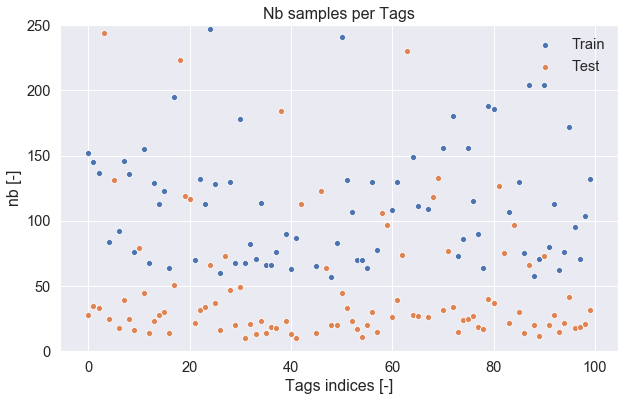

In [357]:
fig = plt.figure(figsize=(10, 6))
plt.title("Nb samples per Tags")
ax = sns.scatterplot(data=encoded_y_train.sum(axis=0), label='Train')
ax1 = sns.scatterplot(data=encoded_y_test.sum(axis=0), label='Test')
#ax1.set_xlim([0,250])
ax.set_xlabel('Tags indices [-]')
ax1.set_ylim([0,250])
ax.set_ylabel('nb [-]')

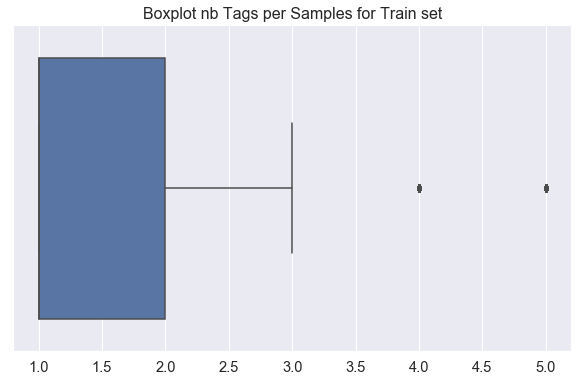

In [358]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb Tags per Samples for Train set")
ax = sns.boxplot(encoded_y_train.sum(axis=1))
#ax.set_xlim([0,250])

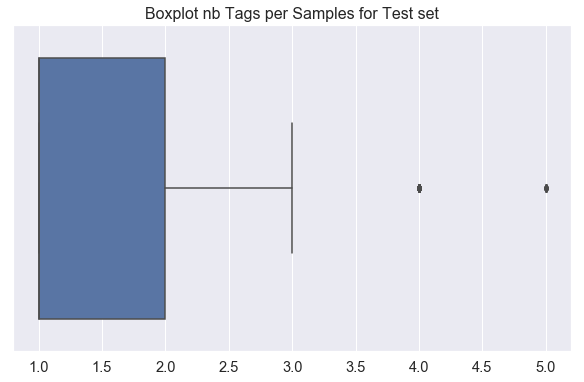

In [359]:
fig = plt.figure(figsize=(10, 6))
plt.title("Boxplot nb Tags per Samples for Test set")
ax = sns.boxplot(encoded_y_test.sum(axis=1))

#### Fit

In [360]:
X_train_tfidf_sup_1.shape

(14195, 1000)

In [361]:
encoded_y_train.shape

(14195, 100)

In [362]:
encoded_y_train[:10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [363]:
encoded_y_test[:10]

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [364]:
for idx in range(0, encoded_y_train.shape[0]):
    if sum(encoded_y_train[idx,:]) == 0:
        print('Error : row n°{} is empty!'.format(idx))

In [365]:
for idx in range(0, encoded_y_test.shape[0]):
    if sum(encoded_y_test[idx,:]) == 0:
        print('Error : row n°{} is empty!'.format(idx))
    

In [366]:
#n_estimators=100 Train Score :  0.9991341414679632 Test Score :  0.17448055407565263
#

clf_rfc_multi_1 = RandomForestClassifier(n_estimators=10, random_state=0, 
                                         n_jobs=-1)

# fitting
t_0 = time.time()
clf_rfc_multi_1.fit(X_train_tfidf_sup_1, encoded_y_train)
t_1 = time.time()
print(clf_rfc_multi_1)
print("timing total: {} s".format(t_1-t_0))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
timing total: 7.240916967391968 s


In [367]:
print("Train Score : ", 
      clf_rfc_multi_1.score(X_train_tfidf_sup_1, encoded_y_train))
print("Test Score : ",
      clf_rfc_multi_1.score(X_test_tfidf_sup_1, encoded_y_test))

Train Score :  0.8657273687918281
Test Score :  0.2166807551422936


Hamming loss : for one tag not well predicted, add  1 / (number of labels * n samples) to total losses

In [368]:
predicted_train = clf_rfc_multi_1.predict(X_train_tfidf_sup_1)
print("Train hamming loss :", hamming_loss(encoded_y_train, predicted_train))
    
predicted_test = clf_rfc_multi_1.predict(X_test_tfidf_sup_1)
print("Test hamming loss :", hamming_loss(encoded_y_test, predicted_test))

#predicted_train = clf_rfc_multi_1.predict(X_train_tfidf_sup_1)
#predicted_test = clf_rfc_multi_1.predict(X_test_tfidf_sup_1)
predicted_train
#df_mdl_sup_1["Tag_0_sgc_1"] = np.nan

#df_mdl_sup_1.loc[df_mdl_sup_1.Train == True ,"Tag_0_sgc_1"] = predicted_train
#df_mdl_sup_1.loc[df_mdl_sup_1.Train == False ,"Tag_0_sgc_1"] = predicted_test
#df_mdl_sup_1.head()

Train hamming loss : 0.0017520253610426206
Test hamming loss : 0.01247957171034094


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [369]:
find_nb_no_tags(predicted_train)
find_nb_no_tags(predicted_test)

Nb. no Tags samples : 884 over 14195 rows [6.23%]
Nb. no Tags samples : 1657 over 3549 rows [46.69%]


1657

#### Optim

In [527]:
# Split parameters
random_state = 0
n_splits = 3
test_size=0.2

# preparation des splits : choix de splits aléatoires de meme taille
cv = model_selection.ShuffleSplit(n_splits=n_splits, test_size=test_size, 
                                  random_state=random_state)


In [528]:
clf_rf_multi_cv = RandomForestClassifier(random_state=0, n_jobs=-1)

In [529]:
# Fixer les valeurs des hyperparamètres à tester
# 5th try OVR
# {'estimator__n_estimators': [25], 'estimator__max_features': [155]} 0.192585
# Train Score : 0.961302784068203
# Test Score :  0.20671283963771978
# Nb. no Tags samples : 232 over 15014 rows [1.55%]
# Nb. no Tags samples : 1158 over 3754 rows [30.85%]

# 1st try {'n_estimators': [10, 20, 30], 'max_features': [24, 31, 37]}
# - best : {'max_features': 37, 'n_estimators': 30}
#   Train Score : 0.9697780908770693
#   Test Score :  0.24260355029585798
#   Nb. no Tags samples : 173 over 14195 rows [1.22%]
#   Nb. no Tags samples : 1486 over 3549 rows [41.87%] 

#2nd Try : {'n_estimators': [30, 40], 'max_features': [37, 43, 49]}
#{'max_features': 49, 'n_estimators': 40}
#Train Score : 0.9844311377245509
#Test Score :  0.25725556494787266
#Nb. no Tags samples : 87 over 14195 rows [0.61%]
#Nb. no Tags samples : 1342 over 3549 rows [37.81%]

#{'n_estimators': [50, 60], 'max_features': [55, 62, 68]}
#{'max_features': 68, 'n_estimators': 60}
#Train Score : 0.994082423388517
#Test Score :  0.2702169625246548
#Nb. no Tags samples : 27 over 14195 rows [0.19%]
#Nb. no Tags samples : 1223 over 3549 rows [34.46%]

#{'n_estimators': [60, 70], 'max_features': [68, 93, 124]} 0.266408
#{'max_features': 124, 'n_estimators': 70}
#Train Score : 0.994082423388517
#Test Score :  0.2702169625246548
#Nb. no Tags samples : 27 over 14195 rows [0.19%]
#Nb. no Tags samples : 1223 over 3549 rows [34.46%]

#{'n_estimators': [80], 'max_features': [124, 155, 186]}    
# {'max_features': 186, 'n_estimators': 80}
#Train Score : 0.9970412116942585
#Test Score :  0.2879684418145957
#Nb. no Tags samples : 13 over 14195 rows [0.09%]
#Nb. no Tags samples : 1008 over 3549 rows [28.40%]

max_features_ideal = int(np.sqrt(X_train_tfidf_sup_1.shape[1]))
n_estimators_range = [80]
max_features_range = [int(max_features_ideal*4),
                      int(max_features_ideal*5),
                      int(max_features_ideal*6)]

# grille de paramètres
param_grid = {'n_estimators': n_estimators_range, 
              'max_features': max_features_range}
param_grid

{'n_estimators': [80], 'max_features': [124, 155, 186]}

In [402]:
# Créer  avec recherche d'hyperparamètre par validation croisée
g_clf_rf_multi_cv = model_selection.GridSearchCV(clf_rf_multi_cv,
param_grid, # hyperparamètres à tester
cv=cv) # nombre de folds de validation croisée
#scoring=score # score à optimiser)

# Optimiser ce classifieur sur le jeu d'entraînement
t_0 = time.time()
g_clf_rf_multi_cv.fit(X_train_tfidf_sup_1, encoded_y_train)
t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print (g_clf_rf_multi_cv.best_params_)

KeyboardInterrupt: 

In [397]:
df_res_rf_multi_cv = pd.DataFrame(data=g_clf_rf_multi_cv.cv_results_)
df_res_rf_multi_cv[df_res_rf_multi_cv["rank_test_score"]<5].T

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

,0,1,2
mean_fit_time,78.5129,102.774,103.4
std_fit_time,2.91357,14.1898,0.729161
mean_score_time,2.32655,2.66337,2.14935
std_score_time,0.218066,0.511942,0.0846995
param_max_features,124,155,186
param_n_estimators,80,80,80
params,"{'max_features': 124, 'n_estimators': 80}","{'max_features': 155, 'n_estimators': 80}","{'max_features': 186, 'n_estimators': 80}"
split0_test_score,0.268404,0.27087,0.271222
split1_test_score,0.287073,0.289186,0.288834
split2_test_score,0.275449,0.281789,0.287425


In [398]:
g_clf_rf_multi_cv.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 186,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 80,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

##### Eval best estimator :

In [399]:
print("Train Score :", 
      g_clf_rf_multi_cv.best_estimator_.score(X_train_tfidf_sup_1, encoded_y_train))
print("Test Score : ",
      g_clf_rf_multi_cv.best_estimator_.score(X_test_tfidf_sup_1, encoded_y_test))

Train Score : 0.9970412116942585
Test Score :  0.2879684418145957


In [400]:
predicted_train = g_clf_rf_multi_cv.best_estimator_.predict(X_train_tfidf_sup_1)
print("Train hamming loss :", hamming_loss(encoded_y_train, predicted_train))
    
predicted_test = g_clf_rf_multi_cv.best_estimator_.predict(X_test_tfidf_sup_1)
print("Test hamming loss :", hamming_loss(encoded_y_test, predicted_test))

Train hamming loss : 3.945051074321944e-05
Test hamming loss : 0.011290504367427444


In [401]:
find_nb_no_tags(predicted_train)
find_nb_no_tags(predicted_test)

Nb. no Tags samples : 13 over 14195 rows [0.09%]
Nb. no Tags samples : 1008 over 3549 rows [28.40%]


1008

### SGDClassifier OneVsRestClassifier

In [480]:
#clf_sgd_multi_1 = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l2',
#                        alpha=1e-3, random_state=0,
#                        max_iter=5, tol=None), n_jobs=-1)
#clf_sgd_multi_1.fit(X_train_tfidf_sup_1, encoded_y_train)

In [481]:
#10.0**-np.arange(1,7)

#### First try

In [417]:
#Train Score :  0.6276808312241907 Test Score :  0.17474693660095897
clf_sgd_multi_1 = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2',
                    alpha=1e-6, 
                    max_iter = np.ceil(10**6 / X_train_tfidf_sup_1.shape[0]),
                    random_state=0, n_jobs=-1), n_jobs=-1)
t_0 = time.time()
clf_sgd_multi_1.fit(X_train_tfidf_sup_1, encoded_y_train)
t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))

timing total: 11.967247009277344 s


In [418]:
print("Train Score :", 
      clf_sgd_multi_1.score(X_train_tfidf_sup_1, encoded_y_train))
print("Test Score : ",
      clf_sgd_multi_1.score(X_test_tfidf_sup_1, encoded_y_test))

Train Score : 0.655371609721733
Test Score :  0.2355593124823894


In [419]:
predicted_train = clf_sgd_multi_1.predict(X_train_tfidf_sup_1)
print("Train hamming loss :", hamming_loss(encoded_y_train, predicted_train))
    
predicted_test = clf_sgd_multi_1.predict(X_test_tfidf_sup_1)
print("Test hamming loss :", hamming_loss(encoded_y_test, predicted_test))

Train hamming loss : 0.004159915463191264
Test hamming loss : 0.01326007326007326


In [420]:
find_nb_no_tags(predicted_train)
find_nb_no_tags(predicted_test)

Nb. no Tags samples : 1227 over 14195 rows [8.64%]
Nb. no Tags samples : 808 over 3549 rows [22.77%]


808

In [421]:
np.nonzero(predicted_test.sum(axis=1))[0].shape[0] / predicted_test.shape[0]

0.7723302338686954

#### Optim OneVsRestClassifier(SGDClassifier)

In [455]:
# Choisir un score à optimiser
#score = 'r2'
#score ='neg_mean_squared_error'
# Choisir des jeux train/test fixe
random_state = 0
n_splits = 3
test_size=0.2

# preparation des splits : choix de splits aléatoires de meme taille
cv = model_selection.ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)


In [456]:
clf_sgd_multi_cv = OneVsRestClassifier(SGDClassifier(random_state=0, n_jobs=-1),
                                       n_jobs=-1)

In [457]:
# Fixer les valeurs des hyperparamètres à tester


'''
nb_iter_ideal = np.ceil(10**6 / X_train_tfidf_sup_1.shape[0])
max_iter_range = [np.ceil(nb_iter_ideal/3), nb_iter_ideal, nb_iter_ideal*3]
alpha_range = 10.0**-np.arange(1,7)
loss_range = ['hinge','log']
penalty_range = ['l2', 'l1', 'elasticnet']
'''
#test 0.245973
#{'estimator__alpha': 1e-05, 'estimator__loss': 'log', 'estimator__max_iter': 23.0, 'estimator__penalty': 'l1'}
#Train Score : 0.4661500528355055
#Test Score :  0.25387433079740773
#Nb. no Tags samples : 2740 over 14195 rows [19.30%]
#Nb. no Tags samples : 982 over 3549 rows [27.67%]

#0.251145
#Train Score : 0.4661500528355055 
#Test Score :  0.25387433079740773
#Nb. no Tags samples : 2740 over 14195 rows [19.30%]
#Nb. no Tags samples : 982 over 3549 rows [27.67%]
    
max_iter_range = [23]
alpha_range = [1e-05]
loss_range = ['log']
penalty_range = ['l1']


# grille de paramètres
param_grid = {'estimator__max_iter': max_iter_range, 
              'estimator__loss': loss_range, 
              'estimator__alpha': alpha_range, 
              'estimator__penalty': penalty_range}
param_grid

{'estimator__max_iter': [23],
 'estimator__loss': ['log'],
 'estimator__alpha': [1e-05],
 'estimator__penalty': ['l1']}

In [458]:
# Créer  avec recherche d'hyperparamètre par validation croisée
g_clf_sgd_multi_cv = model_selection.GridSearchCV(clf_sgd_multi_cv,
param_grid, # hyperparamètres à tester
cv=cv) # nombre de folds de validation croisée
#scoring=score # score à optimiser)


# Optimiser ce classifieur sur le jeu d'entraînement
# clf.fit(X_train, y_train)
t_0 = time.time()
g_clf_sgd_multi_cv.fit(X_train_tfidf_sup_1, encoded_y_train)
t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print (g_clf_sgd_multi_cv.best_params_)

timing total: 28.123115062713623 s
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'estimator__alpha': 1e-05, 'estimator__loss': 'log', 'estimator__max_iter': 23, 'estimator__penalty': 'l1'}


In [459]:
df_res_sgd_multi_cv = pd.DataFrame(data=g_clf_sgd_multi_cv.cv_results_)
df_res_sgd_multi_cv[df_res_sgd_multi_cv["rank_test_score"]<10].T

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py

,0
mean_fit_time,6.42186
std_fit_time,0.154966
mean_score_time,0.0397471
std_score_time,0.00391976
param_estimator__alpha,1e-05
param_estimator__loss,log
param_estimator__max_iter,23
param_estimator__penalty,l1
params,"{'estimator__alpha': 1e-05, 'estimator__loss':..."
split0_test_score,0.238816


In [460]:
g_clf_sgd_multi_cv.best_estimator_.get_params()

{'estimator__alpha': 1e-05,
 'estimator__average': False,
 'estimator__class_weight': None,
 'estimator__early_stopping': False,
 'estimator__epsilon': 0.1,
 'estimator__eta0': 0.0,
 'estimator__fit_intercept': True,
 'estimator__l1_ratio': 0.15,
 'estimator__learning_rate': 'optimal',
 'estimator__loss': 'log',
 'estimator__max_iter': 23,
 'estimator__n_iter': None,
 'estimator__n_iter_no_change': 5,
 'estimator__n_jobs': -1,
 'estimator__penalty': 'l1',
 'estimator__power_t': 0.5,
 'estimator__random_state': 0,
 'estimator__shuffle': True,
 'estimator__tol': None,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': SGDClassifier(alpha=1e-05, average=False, class_weight=None,
        early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
        l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=23,
        n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l1',
        power_t=0.5, random_state=0, shuf

##### Eval best estimator :

In [461]:
print("Train Score :", 
      g_clf_sgd_multi_cv.best_estimator_.score(X_train_tfidf_sup_1, encoded_y_train))
print("Test Score : ",
      g_clf_sgd_multi_cv.best_estimator_.score(X_test_tfidf_sup_1, encoded_y_test))

Train Score : 0.4661500528355055
Test Score :  0.25387433079740773


In [462]:
predicted_train = g_clf_sgd_multi_cv.best_estimator_.predict(X_train_tfidf_sup_1)
print("Train hamming loss :", hamming_loss(encoded_y_train, predicted_train))
    
predicted_test = g_clf_sgd_multi_cv.best_estimator_.predict(X_test_tfidf_sup_1)
print("Test hamming loss :", hamming_loss(encoded_y_test, predicted_test))

Train hamming loss : 0.007337794998238816
Test hamming loss : 0.012034375880529727


In [463]:
find_nb_no_tags(predicted_train)
find_nb_no_tags(predicted_test)

Nb. no Tags samples : 2740 over 14195 rows [19.30%]
Nb. no Tags samples : 982 over 3549 rows [27.67%]


982

#### Evaluation
Method : Check if real Tags are into predicted Tags

In [466]:
encoded_y_train[0,:] & predicted_train[0,:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [508]:
encoded_y_train[:3,:]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [509]:
predicted_train[:3,:]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [515]:
precision_score(encoded_y_train[:3,:], predicted_train[:3,:], average='micro')

0.8

In [511]:
4/5

0.8

In [ ]:
precision_score(encoded_y_train[0,:], predicted_train[0,:], average='micro')

In [495]:
precision_score(encoded_y_train, predicted_train, average='micro')

0.8958270789552687

In [497]:
precision_score(encoded_y_test, predicted_test, average='micro')

0.70752016653656

In [498]:
recall_score(encoded_y_train, predicted_train, average='micro')

0.6321766026863268

In [516]:
df_mdl_sup_1[df_mdl_sup_1["Train"] == True]["score_sgd_multi_1"].mean()

0.6548103792415159

In [499]:
recall_score(encoded_y_test, predicted_test, average='micro')

0.4635185816570065

In [517]:
df_mdl_sup_1[df_mdl_sup_1["Train"] == False]["score_sgd_multi_1"].mean()

0.4840847187001031

In [474]:
t_0 = time.time()

df_mdl_sup_1["score_sgd_multi_1"] = 0

# train part
list_scores_train = []
for i_row in range(0, encoded_y_train.shape[0]):
    nb_tags_curr = np.sum(encoded_y_train[i_row,:])
    nb_good = np.sum(encoded_y_train[i_row,:] & predicted_train[i_row,:])
    list_scores_train.append(nb_good / nb_tags_curr)    

# test part
list_scores_test = []
for i_row in range(0, encoded_y_test.shape[0]):
    nb_tags_curr = np.sum(encoded_y_test[i_row,:])
    nb_good = np.sum(encoded_y_test[i_row,:] & predicted_test[i_row,:])
    list_scores_test.append(nb_good / nb_tags_curr) 
    
t_1 = time.time()
print("timing total: {} s".format(t_1-t_0))

df_mdl_sup_1.loc[df_mdl_sup_1["Train"] == True, "score_sgd_multi_1"] =\
    list_scores_train
df_mdl_sup_1.loc[df_mdl_sup_1["Train"] == False, "score_sgd_multi_1"] =\
    list_scores_test

timing total: 0.28374314308166504 s


In [476]:
#fig = plt.figure(figsize=(8, 8))
#plt.title("title")
df_mdl_sup_1["score_sgd_multi_1"].value_counts()

1.000000    8783
0.000000    4516
0.500000    2842
0.666667     702
0.333333     651
0.750000     106
0.250000      95
0.200000      17
0.600000      17
0.400000      12
0.800000       3
Name: score_sgd_multi_1, dtype: int64

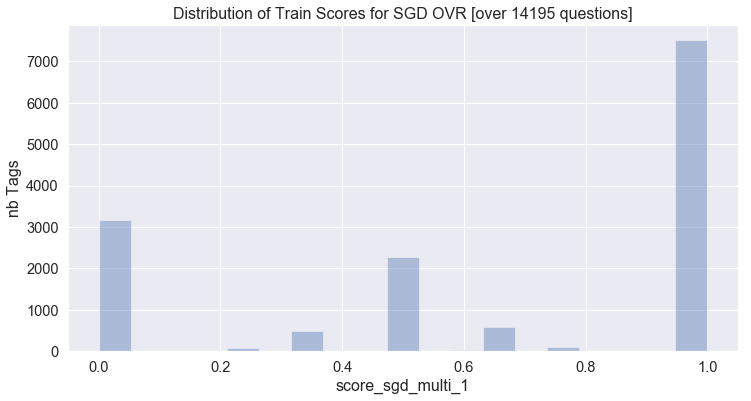

In [478]:
fig = plt.figure(figsize=(12, 6))
plt.title("Distribution of Train Scores for SGD OVR [over {} questions]".format(
    df_mdl_sup_1[df_mdl_sup_1.Train == True].shape[0]))
ax = sns.distplot(df_mdl_sup_1[df_model_1.Train == True]["score_sgd_multi_1"], 
                  kde=False)
ax.set_ylabel('nb Tags');

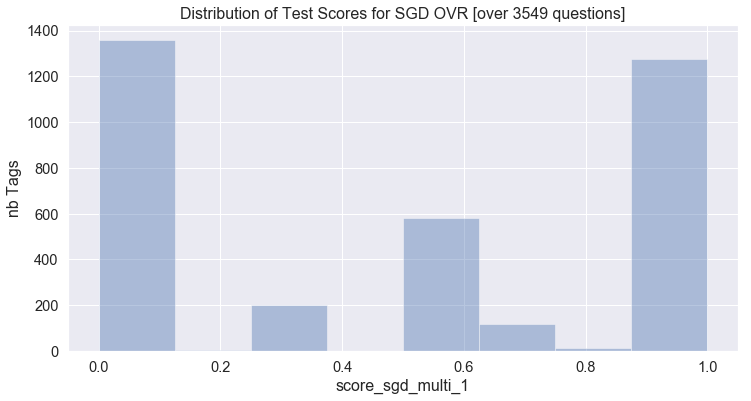

In [479]:
fig = plt.figure(figsize=(12, 6))
plt.title("Distribution of Test Scores for SGD OVR [over {} questions]".format(
    df_mdl_sup_1[df_mdl_sup_1.Train == False].shape[0]))
ax = sns.distplot(df_mdl_sup_1[df_model_1.Train == False]["score_sgd_multi_1"], 
                  kde=False)
ax.set_ylabel('nb Tags');

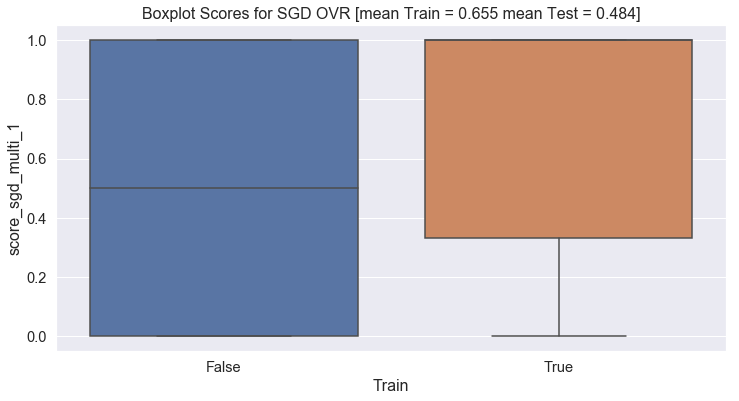

In [481]:
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplot Scores for SGD OVR [mean Train = {:.3f} mean Test = {:.3f}]".
          format(df_mdl_sup_1[df_mdl_sup_1.Train == True]\
                 ["score_sgd_multi_1"].mean(),
                 df_mdl_sup_1[df_mdl_sup_1.Train == False]\
                 ["score_sgd_multi_1"].mean()))
ax = sns.boxplot(y="score_sgd_multi_1", x='Train', data=df_mdl_sup_1)

##### At least one Tag ok

In [483]:
df_mdl_sup_1["score_OK_sgd_1"] = df_mdl_sup_1["score_sgd_multi_1"] > 0

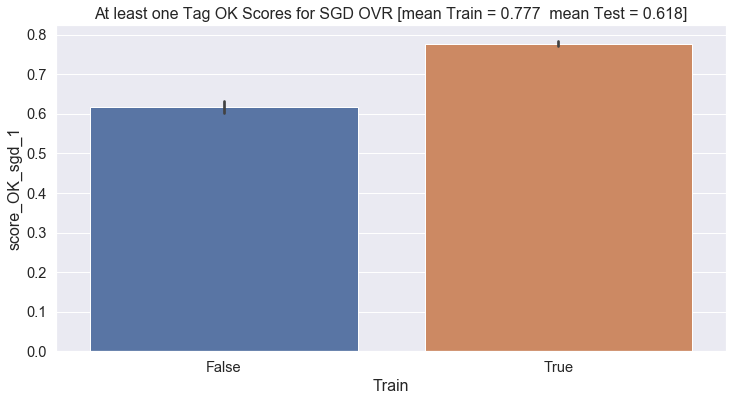

In [485]:
fig = plt.figure(figsize=(12, 6))
plt.title("At least one Tag OK Scores for SGD OVR [mean Train = {:.3f}  mean Test = {:.3f}]".
          format(df_mdl_sup_1[df_mdl_sup_1.Train == True]\
                 ["score_OK_sgd_1"].mean(),
                 df_mdl_sup_1[df_mdl_sup_1.Train == False]\
                 ["score_OK_sgd_1"].mean()))
ax = sns.barplot(y="score_OK_sgd_1", x='Train', data=df_mdl_sup_1)
#ax = sns.barplot(x="day", y="total_bill", data=tips)

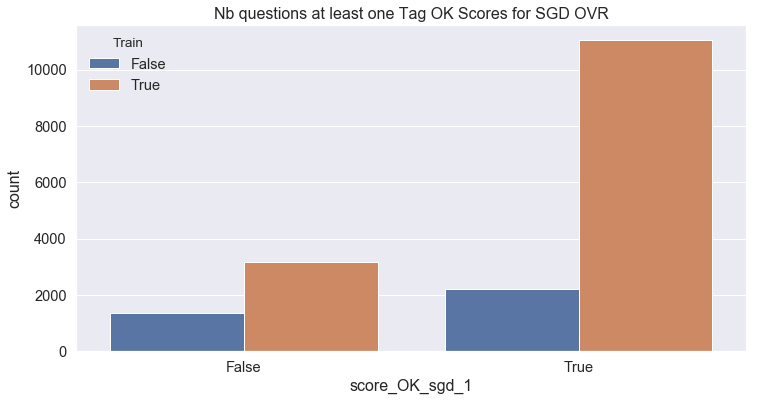

In [486]:
fig = plt.figure(figsize=(12, 6))
plt.title("Nb questions at least one Tag OK Scores for SGD OVR")
ax = sns.countplot(x="score_OK_sgd_1", hue="Train", data=df_mdl_sup_1)